
---
---

<img src="data/logoLCL.png" width=100px align="right"></span>
<img src="data/logoP1.png" width=160px align="right"></span>
<img src="data/logoMoSEF.jpeg" width=90px align="right"></span>

# <span style="background-color: "> **_PROJET SCORING_** </span>

### **_Modélisation des Risques de Crédit_**

<div style="text-align:right;">Octobre 2022 - Décembre 2022</div>

##### <div style="text-align:right;">Projet réalisé par : Gaoussou Diakité, Eunice Koffi, Camil Zahi</div>
---
---

**Objectifs :** 

Modéliser la tombée en défaut à 36 mois de dossiers immobiliers et construire une grille de score sur vos périmètres respectifs. Ce score a comme objectif d’aide à la décision au conseiller pour l’acceptation d’un dossier de crédit immobilier.

Ce projet constiste en la construction d'un score d'octroi. 
C'est un outil d'aide à la décision qui permettra qui intervient en amont de l'octroi d'un crédit
 
 <img src="data/Scores.jpg"></span>

# Préparation des données

## Construction de la base d’analyse 

### Définition du critère à modéliser

Il s’agit de fixer d’une manière objective les situations de défaut, à ce titre le comité de Bâle a arrêté 4 critères :

- L’incapacité de rembourser
- Le report de paiement associé à un abandon, une provision ou restauration.
- Le retard de paiement de plus de 90 jours
- Situation juridique de faillite.

### Visualisation de la base de donéees

In [11]:
# Librairies et modules

# Eviter les messages d'alerte
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt
import itertools
import re

from scipy import stats
from scipy.stats import chi2_contingency, skew

from sklearn import svm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_classif, RFE
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTENC, SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import scorecardpy as sc
import utils

import statsmodels.api as sm
from statsmodels.tools import tools
from statsmodels.iolib.summary import Summary

import statsmodels.api as sm
from statsmodels.tools import tools
from statsmodels.iolib.summary import Summary
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, precision_recall_curve
from sklearn.metrics import make_scorer, auc, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE

In [12]:
#Importation de la base de données
df = pd.read_csv("data/bases_connus.csv")
df.sample(n=5,random_state=14)

region_cri  date_debloc_avec_crd DAT_VALIDE_ACCORD_CRI  nb_pret  \
52915      ILE DE FRANCE                201603             27-Aug-15        1   
8787                PACA                201407             12-Jun-14        1   
92595           AUVERGNE                201607             16-Jun-16        2   
89571          GRAND EST                201607             28-May-16        1   
131221  PAYS DE LA LOIRE                201706             10-Mar-17        1   

        TOP_CONNU_BRP  TOP_SCI_BRP  ASU_BIEN_FIN_BRP  NAT_BIEN_FIN_BRP  \
52915               1            0                10                20   
8787                1            0                20                10   
92595               1            0                10                20   
89571               1            0                10                20   
131221              1            0                10                10   

        NBR_INT_BRP  NBR_TOT_COEMPR_CRI  ... Mt_credit_nb_ans_rev_prof  \
52915             2                   1  ...                  4.933149   
8787              2                   1  ...                  1.634442   
92595             2                   1  ...                  2.649658   
89571             2                   1  ...                  2.057007   
131221            1                   0  ...                  5.506835   

        Epargne_nb_ans_rev_prof rentabilite_loc  financement_tot   quotite  \
52915                  0.017082             NaN        392244.55  1.027166   
8787                   0.049699             NaN        135000.00  0.950704   
92595                  0.351810             NaN        191300.00  0.524541   
89571                  1.053735             NaN        122173.85  1.018115   
131221                 0.147209             NaN        136540.00  1.000733   

        top_locatif  top_pret_int_ext  top_autre_pret_int  top_autre_pret_ext  \
52915             0                 0                   0                   0   
8787              0                 1                   0                   0   
92595             0                 1                   0                   0   
89571             0                 1                   0                   0   
131221            0                 0                   0                   0   

        top_pers_seule  
52915                0  
8787                 0  
92595                0  
89571                0  
131221               1  

[5 rows x 123 columns]

In [13]:
# Dimension de la base des données 
print(f"La base de données fait {df.shape[0]} lignes et {df.shape[1]} colonnes.")

La base de données fait 163614 lignes et 123 colonnes.


In [14]:
# Type de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163614 entries, 0 to 163613
Columns: 123 entries, region_cri to top_pers_seule
dtypes: float64(72), int64(40), object(11)
memory usage: 153.5+ MB


defaut_36mois
0    162555
1      1059
dtype: int64


<AxesSubplot:ylabel='defaut_36mois'>

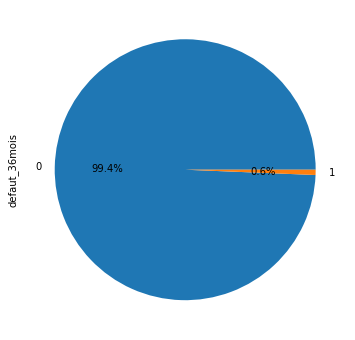

In [15]:
# Répartition de la variable à modéliser
print(df.groupby(['defaut_36mois']).size())

# Distribution par variable
plt.figure(figsize=(8, 6))
df["defaut_36mois"].value_counts().plot.pie(autopct = lambda x: str(round(x, 1)) + '%')

**_Nous remarquons que nous avons une faible proportion de défaut dans la base (0,6%)._**

### Vérification de la base des données

In [16]:
# Vérification du type des variables
col_categoricals = []
col_numericals = []

for col in df.columns :
    if df[col].dtypes == 'float64' or df[col].dtypes == 'int64':
        col_numericals.append(col)
    else :
        col_categoricals.append(col)

print(f"Liste des colonnes catégorielles :\n{col_categoricals}")
print(f"\nListe des colonnes numériques :\n{col_numericals}")

Liste des colonnes catégorielles :
['region_cri', 'DAT_VALIDE_ACCORD_CRI', 'COD_POSTAL_BIEN_CRI', 'CODPAY_BIEN_CRI', 'NAT_INT_MAX_BRP', 'TYP_CNT_TRA_MAX_BRP', 'CODPAY_NAT_EMPRUNTEUR_CRI', 'CODTYP_CRT_TRAVAIL_CRI', 'COD_TYPE_MARCHE_CRI', 'IND_INCIDENT_BDF_CRI', 'DEPARTEMENT_CRI']

Liste des colonnes numériques :
['date_debloc_avec_crd', 'nb_pret', 'TOP_CONNU_BRP', 'TOP_SCI_BRP', 'ASU_BIEN_FIN_BRP', 'NAT_BIEN_FIN_BRP', 'NBR_INT_BRP', 'NBR_TOT_COEMPR_CRI', 'TOP_GARANTIE_CL', 'CODTYPE_PROJET_CRI', 'COD_CPPOP_CRI', 'COD_ETA_BIEN_CRI', 'COD_USAGE_BIEN_CRI', 'BEST_APPORT_MT_BRP', 'BEST_APPORT_TX_BRP', 'PCT_APPORT_PERS_CRI', 'PCT_ENDETTMT_CRI', 'TOP_ETR_BRP', 'TOP_PRET_RELAIS_BRP', 'TX_APPORT_HF_AT_BRP', 'TX_APPORT_HF_HT_BRP', 'TX_APPORT_TF_AT_BRP', 'TX_APPORT_TF_HT_BRP', 'TX_APPORT_BRP', 'TX_APPORT_AGENCE_BRP', 'TX_FINANCEMENT_BRP', 'TX_FINANCEMENT_AGENCE_BRP', 'FINANCEMENT_LT_BRP', 'FINANCEMENT_PR_BRP', 'TX_APPORT_SE_BRP', 'LTV_OCTROI_BRP', 'LTV_ACPR_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exis

**_Nous constatons que certaines variables ne sont pas au bon format. Il s'agit de variables dates qui ne sont pas reconnues comme tel ou des variables catégorielles qui sont prises en compte comme des variables numériques. Il conviendra de les mettre au bon format._**

In [17]:
#Date de déblocage
df["date_debloc_avec_crd"] = pd.to_datetime(df["date_debloc_avec_crd"], format='%Y%m')

**_Nous vérifions également pour chaque variable, le nombre de modalités qu'elle contient. Etant donné le grand nombre de variables que nous avons, une méthode est utilisée afin d'afficher les résultats pour toutes les variables sans exception._**

In [18]:
# Nombres de modalités par variable
for var in df.select_dtypes('object'):
    print(var,":", df[var].nunique())
for var in df.select_dtypes('int'):
    print(var,":", df[var].nunique())

region_cri : 15
DAT_VALIDE_ACCORD_CRI : 1580
COD_POSTAL_BIEN_CRI : 11050
CODPAY_BIEN_CRI : 39
NAT_INT_MAX_BRP : 135
TYP_CNT_TRA_MAX_BRP : 13
CODPAY_NAT_EMPRUNTEUR_CRI : 130
CODTYP_CRT_TRAVAIL_CRI : 13
COD_TYPE_MARCHE_CRI : 3
IND_INCIDENT_BDF_CRI : 2
DEPARTEMENT_CRI : 213
nb_pret : 6
TOP_CONNU_BRP : 1
TOP_SCI_BRP : 2
ASU_BIEN_FIN_BRP : 7
NAT_BIEN_FIN_BRP : 15
NBR_INT_BRP : 7
NBR_TOT_COEMPR_CRI : 6
TOP_GARANTIE_CL : 2
CODTYPE_PROJET_CRI : 15
COD_CPPOP_CRI : 13
COD_ETA_BIEN_CRI : 12
COD_USAGE_BIEN_CRI : 7
PCT_APPORT_PERS_CRI : 114
TOP_ETR_BRP : 2
TOP_PRET_RELAIS_BRP : 2
TOP_SURFINANCEMENT_BRP : 2
top_exist_conso_revo_BRP : 2
NBR_DUREE_TOT_PRET_CRI : 322
AGE_INT_MAX_BRP : 81
ANC_OCC_LOG_ACT_BRP : 71
ANC_PROF_MAX_BRP : 61
NBR_ENF_CHAR_BRP : 10
NBR_AUT_CHAR_BRP : 13
TOP_ASC_DESC_BRP : 2
QUA_INT_1_BRP : 4
QUA_INT_MAX_BRP : 4
ROL_INT_MAX_BRP : 2
NBR_AGE_CLIENT_CRI : 80
NBR_ENF_ACHARGE_CRI : 10
NBR_OCCUP_CRI : 25
defaut_36mois : 2
TOP_BIEN_FR_CRI : 2
TOP_NAT_FR_CRI : 2
ID : 163614
top_locatif :

**_Nous constatons la présence d'une variable à une seule modalité (TOP_CONNU_BRP). Cette variable n'apporte aucune information et doit donc être supprimée du jeu de données._**

In [19]:
#Vérification des doublons
df['ID'].nunique()==df.shape[0]

True

**_La variable ID nous confirme que notre base de données ne contient pas de doublons. N'étant également pas informatif, nous la supprimons du jeu de données. Conformément aux instructions reçues, nous allons également supprimer la variable TOP_GARANTIE_CL. La variable TOP_CONNU_BRP doit également être supprimée._**

### Nettoyage des données (valeurs manquantes, extrêmes, …)

**_Nous constatons la présence de valeurs manquantes dans la base de données. Cependant, nous ne pouvons pas imputer les valeurs manquantes sans les avoir comprises au préalable. En effet, pour un bon traitement des valeurs manquantes et un bon nettoyage des données, il est important de comprendre chaque variable. A ce stade, une première sélection des variables est utile à la création de notre base d'analyse._**

In [20]:
taux_de_NAN = round((df[df.columns[df.isna().sum()>0]].isna().sum()*100/df.shape[0]).sort_values(ascending=False),5)
taux_de_NAN

TX_APPORT_AGENCE_BRP          97.13166
TX_FINANCEMENT_AGENCE_BRP     97.13166
FINANCEMENT_PR_BRP            97.11883
TX_APPORT_BRP                 97.09132
TX_FINANCEMENT_BRP            97.09132
mnt_pret_ext_brp              97.08888
SUM_LOYER_BRP                 95.98873
SUM_AUTRES_CHARG_BRP          91.63825
IRPRO_USAGE_V12_MAX           89.75393
rentabilite_loc               76.56007
SUM_RESS_IMMO_BRP             75.62617
SUM_MNT_PRE_EXTERNE_BRP       67.61218
SUM_MNT_PRE_INTERNE_BRP       49.56116
SUM_MTENCBIE_IMMO_BRP         40.23311
SUM_PATR_IMMO_BRP             40.23311
COUT_NOTAIRE_BRP              38.07559
COUT_ACQ_BRP                  38.03342
IND_PRIMO_ACCEDT_CRI          36.70591
AUTRES_COUT_BRP               25.85781
SUM_TAX_FISC_BRP              19.81187
BEST_APPORT_TX_BRP            18.75023
BEST_APPORT_MT_BRP            18.75023
LTV_OCTROI_BRP                18.18243
COUT_DOSSIER_BRP              15.54207
Epargne_nb_ans_rev_prof       15.03661
SUM_EPARGNE_BRP          

<AxesSubplot:>

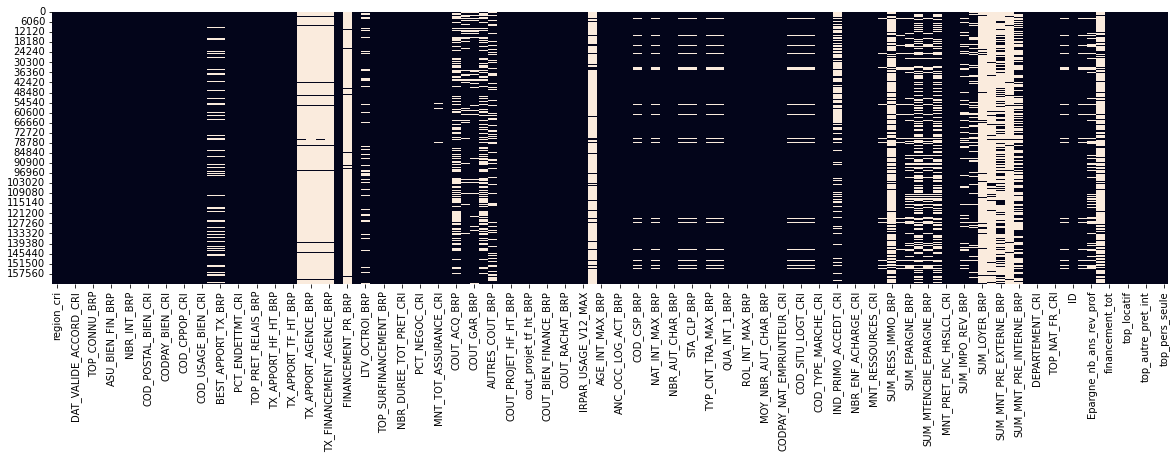

In [21]:
# Visualisation des valeurs manquantes de la nouvelle base
plt.figure(figsize=(20,5))
sns.heatmap(df.isna(), cbar=False)

Le graphique ci-dessus nous donne une vision des valeurs manquantes par variables et par lignes. Plus la zone blanche de la verticale est blanche, plus la variable correspondante contient des valeurs manquantes. Il en est de même pour l'horizontale qui donne une visualisation des valeurs manqauntes pour une ligne. Nous pouvons constater que certaines observations contiennent des valeurs manquantes pour des memes observations. En observant les valeurs manquantes suivant l'axe horizontal, nous constatons une certaine linéarité ou alignement des valeurs manquantes. Cette observations laisse présager que les valeurs manquantes de certaines variables ne sont pas aléatoires. En effet, si les valeurs manquantes de notre base de données étaient aléatoires, notre graphique aurait été semblable à un nuage de points blancs et noirs. Ce qui n'est pas le cas ici. Nous avons une représentation par blocs. La suite de notre analyse confirmera ou réfutera notre constat. 

<AxesSubplot:>

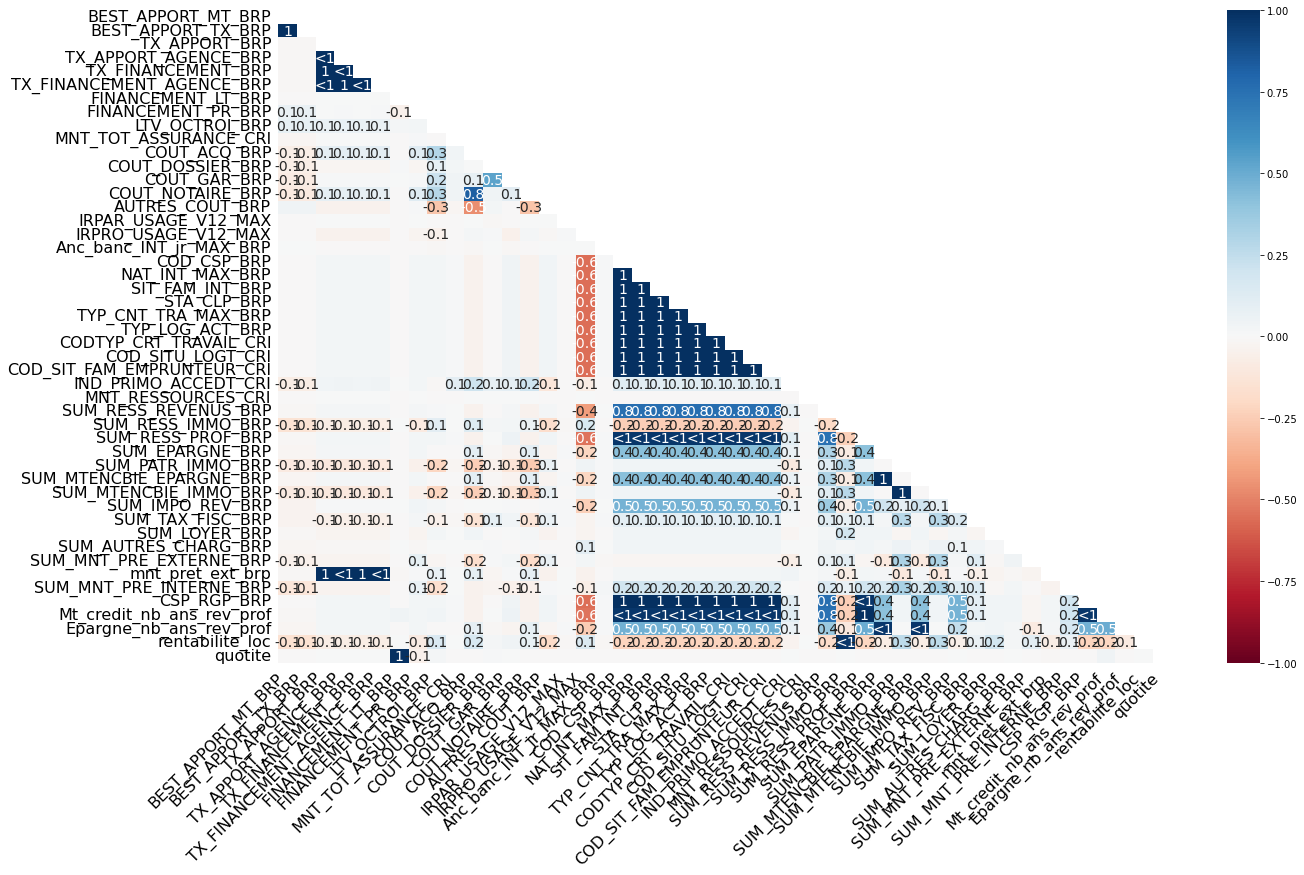

In [22]:
# Corrélation des valeurs manquantes des variables
msno.heatmap(df)

Ce graphique affiche la corrélation entre les valeurs manquantes des variables. Cette corrélation est comprise entre -1 et 1.

- -1 - La corrélation négative exacte signifie que si la valeur d’une variable est présente, la valeur des autres variables est définitivement absente.
- 0 - Aucune corrélation ne signifie que les valeurs des variables présentes ou absentes n’ont aucun effet les unes sur les autres.
- 1 - La corrélation positive exacte représente que si la valeur d’une variable est présente, la valeur de l’autre est définitivement présente.

Autres explications 

- Une valeur proche de -1 signifie que si une variable apparaît, il est fort probable que l'autre variable soit manquante.
- Une valeur proche de 0 signifie qu'il n'y a pas dépendance entre l'occurrence de valeurs manquantes.
- Une valeur proche de 1 signifie que si une variable apparaît, alors l'autre variable est très probablement présente

In [23]:
# Suppression des colonnes à plus de 50 %
col_to_del = df[df.columns[df.isna().sum()/df.shape[0] >=0.5]].columns
print(f"On va supprimer {len(col_to_del)} variables")
print(f'Les variables supprimées sont : {col_to_del}')

On va supprimer 12 variables
Les variables supprimées sont : Index(['TX_APPORT_BRP', 'TX_APPORT_AGENCE_BRP', 'TX_FINANCEMENT_BRP',
       'TX_FINANCEMENT_AGENCE_BRP', 'FINANCEMENT_PR_BRP',
       'IRPRO_USAGE_V12_MAX', 'SUM_RESS_IMMO_BRP', 'SUM_LOYER_BRP',
       'SUM_AUTRES_CHARG_BRP', 'SUM_MNT_PRE_EXTERNE_BRP', 'mnt_pret_ext_brp',
       'rentabilite_loc'],
      dtype='object')


Les variables supprimées sont les suivantes :

    - FINANCEMENT_PR_BRP                 Montant du prêt relais
    - mnt_pret_ext_brp                   Montant des prets externes
    - rentabilite_loc                    Rentabilité pour investissement locatif
    - SUM_AUTRES_CHARG_BRP               Somme des autres charges
    - SUM_LOYER_BRP                      Somme des loyers
    - SUM_RESS_IMMO_BRP                  Somme des revenus immobiliers liés au projet de tous les intervenants
    - TX_APPORT_AGENCE_BRP               Taux d'apport avec frais d'agence
    - TX_APPORT_BRP                      Taux d'apport
    - TX_FINANCEMENT_AGENCE_BRP          Taux financement avec frais d'agence
    - TX_FINANCEMENT_BRP                 Taux financement
    - IRPRO_USAGE_V12_MAX                Classe de risque (Professionnels) de l'intervenant principal
    - SUM_MNT_PRE_EXTERNE_BRP            Somme des montants des prets externes
    
Toutes ces valeurs manquantes sont inhérentes à la base de données. On dit qu'elles sont manquantes par construction. Elles sont donc légitimes en raison de la structure de la base de données. En effet, pour ces variables il n'existe des valeurs que si d'autres variables contiennent également des valeurs. On dit que ces variables sont corrélées. Notons également que la variable **Taux d'apport** apparait en doublons dans la base de données.

In [24]:
# Garder les colonnes avec moins de 50% de valeurs manquantes
def keep_some_columns(df_):

    df__ = df_[df_.columns[df_.isna().sum()/df_.shape[0] < 0.5]]

    return df__

df = keep_some_columns(df)

# Dimension de la base des données 
print(f"La base de données fait maintenant {df.shape[0]} lignes et {df.shape[1]} colonnes.")

La base de données fait maintenant 163614 lignes et 111 colonnes.


**_Présélection de variables niveau métier_**

A cette étape, il conviendra de préselectionner des variables d'un point de vue métier. En effet, pour la construction d'un score, il est indéniable d'inclure certaines variables caractéristiques de l'emprunteur, du bien financé et des termes du contrat. Ces variables sont des variables relatives aux critères suivants :
    
    Variables emprunteurs :
        - Epargne
        - Classe de risque (IRPAR)
        - Ancienneté professionnelle
        - Situation socio-professionnelle
        - Contrat de travail
        - Logement actuel
        - Nombre d'enfants à charge
        - Nationalité
        - Existence d'un prêt conso
        - Nature de l'intervenant
    
    Variables projets:
        - Taux d'intérêts
        - LVT octroi
        - Taux d'apport
        - Cout des travaux
        - Nature du projet
        - Etat du bien
        - Durée du prêt
        - Prêts relais
        - Localisation du bien


**_Méthodologie de sélection :_**

Pour chaque critère nous retrouvons plusieurs variables qui y sont rattachées dans la base de données. Une sélection des variables adéquates à chaque critère se fera selon certaines règles que sont : 
- la suppression des doublons
- la non pertinence des valeurs pour une variable
- un nombre important de valeurs manquantes
- un grand nombre de modalités de la variable (par exexmple nationalité car il y a trop de pays)

Pour voir le détail :
- ouvrir le notebook "Première sélection des variables" 
- les fichiers excel : 
    - train_connus.xlsx
    - Dictionnaire de données.xlsx
    - Lexique.xlsx
    - Présélection de variables.xlsx

In [25]:
# Nous obtenons les variables sélectionées ci-dessous, que nous enregistrons dans une liste.
selected_var=['nb_pret', 'ASU_BIEN_FIN_BRP', 'NAT_BIEN_FIN_BRP', 'NBR_INT_BRP','COD_ETA_BIEN_CRI', 'PCT_ENDETTMT_CRI', 'TOP_PRET_RELAIS_BRP', 'TX_APPORT_SE_BRP',
              'LTV_OCTROI_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exist_conso_revo_BRP', 'NBR_DUREE_TOT_PRET_CRI', 'MNT_PRET_CRI', 'PCT_NEGOC_CRI', 'PCT_TEG_TAEG_CRI',
              'MNT_TOT_ASSURANCE_CRI', 'MNT_COUT_TOT_CREDIT_CRI', 'cout_projet_tf_ht_BRP', 'COUT_TRAVAUX_BRP', 'COUT_BIEN_FINANCE_BRP', 'IRPAR_USAGE_V12_MAX', 'Anc_banc_INT_jr_MAX_BRP',
              'TOP_NAT_FR_CRI', 'NBR_ENF_CHAR_BRP', 'NBR_AUT_CHAR_BRP', 'SIT_FAM_INT_BRP', 'STA_CLP_BRP', 'TYP_CNT_TRA_MAX_BRP', 'QUA_INT_MAX_BRP', 'ROL_INT_MAX_BRP', 
              'COD_SITU_LOGT_CRI', 'COD_TYPE_MARCHE_CRI', 'IND_INCIDENT_BDF_CRI', 'IND_PRIMO_ACCEDT_CRI', 'NBR_AGE_CLIENT_CRI',
              'MNT_RESSOURCES_CRI', 'SUM_EPARGNE_BRP', 'SUM_PATR_IMMO_BRP', 'defaut_36mois', 'TOP_BIEN_FR_CRI', 'CSP_RGP_BRP', 'financement_tot', 'quotite', 'top_locatif',
              'top_pret_int_ext', 'top_pers_seule', 'MNT_PRET_ENC_HRSLCL_CRI', 'MNT_PRET_ENC_LCL_CRI', 'date_debloc_avec_crd']
              
len(selected_var)

49

In [26]:
# Nouvelle base avec les variables pré-sélectionnées
def select_some_columns(df_, selected_var):

    df__ = df_[selected_var]

    return df__

df = select_some_columns(df, selected_var)
# Dimension de la base des données 
print(f"La base de données fait maintenant {df.shape[0]} lignes et {df.shape[1]} colonnes.")

La base de données fait maintenant 163614 lignes et 49 colonnes.


In [27]:
# On inspecte les variables numériques et les variables catégorielles
col_categoricals = []
col_numericals_float = []
col_numericals_int = []
for col in df.columns :
    if df[col].dtypes == 'float64':
        col_numericals_float.append(col)
    elif df[col].dtypes == 'object' :
        col_categoricals.append(col)
    elif df[col].dtypes == 'int64':
        col_numericals_int.append(col)

print(f"Liste des colonnes catégorielles :\n{col_categoricals}")
print(f"\nListe des colonnes numériques décimales :\n{col_numericals_float}")
print(f"\nListe des colonnes numériques entières :\n{col_numericals_int}")

Liste des colonnes catégorielles :
['TYP_CNT_TRA_MAX_BRP', 'COD_TYPE_MARCHE_CRI', 'IND_INCIDENT_BDF_CRI']

Liste des colonnes numériques décimales :
['PCT_ENDETTMT_CRI', 'TX_APPORT_SE_BRP', 'LTV_OCTROI_BRP', 'MNT_PRET_CRI', 'PCT_NEGOC_CRI', 'PCT_TEG_TAEG_CRI', 'MNT_TOT_ASSURANCE_CRI', 'MNT_COUT_TOT_CREDIT_CRI', 'cout_projet_tf_ht_BRP', 'COUT_TRAVAUX_BRP', 'COUT_BIEN_FINANCE_BRP', 'IRPAR_USAGE_V12_MAX', 'Anc_banc_INT_jr_MAX_BRP', 'SIT_FAM_INT_BRP', 'STA_CLP_BRP', 'COD_SITU_LOGT_CRI', 'IND_PRIMO_ACCEDT_CRI', 'MNT_RESSOURCES_CRI', 'SUM_EPARGNE_BRP', 'SUM_PATR_IMMO_BRP', 'CSP_RGP_BRP', 'financement_tot', 'quotite', 'MNT_PRET_ENC_HRSLCL_CRI', 'MNT_PRET_ENC_LCL_CRI']

Liste des colonnes numériques entières :
['nb_pret', 'ASU_BIEN_FIN_BRP', 'NAT_BIEN_FIN_BRP', 'NBR_INT_BRP', 'COD_ETA_BIEN_CRI', 'TOP_PRET_RELAIS_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exist_conso_revo_BRP', 'NBR_DUREE_TOT_PRET_CRI', 'TOP_NAT_FR_CRI', 'NBR_ENF_CHAR_BRP', 'NBR_AUT_CHAR_BRP', 'QUA_INT_MAX_BRP', 'ROL_INT_MAX_BRP', 'N

**Transformation des variables**

In [28]:
for col in col_categoricals:
    print(col, df[col].unique())

TYP_CNT_TRA_MAX_BRP ['1' '8' '4' 'Z' '2' 'Y' '6' nan '3' '9' '5' 'B' '7' 'A']
COD_TYPE_MARCHE_CRI ['M1' 'M21' 'M2']
IND_INCIDENT_BDF_CRI ['N' 'O']


In [29]:
for col in col_numericals_float:
    print(col, df[col].unique())

PCT_ENDETTMT_CRI [30.01519 49.03698 41.2031  ... 28.17822 23.82627 31.5687 ]
TX_APPORT_SE_BRP [0.3665 0.     0.4587 ... 0.811  0.9486 0.8945]
LTV_OCTROI_BRP [1.33907129 4.39502236 0.54131535 ... 0.07856792 0.6436791  1.06982081]
MNT_PRET_CRI [ 58000. 321000.  50000. ...  58517. 431265. 185079.]
PCT_NEGOC_CRI [4.1000e+00 3.9500e+00 3.7000e+00 4.1500e+00 3.6000e+00 4.0000e+00
 4.0500e+00 3.8000e+00 4.2500e+00 3.7500e+00 3.8500e+00 3.1910e+00
 3.6800e+00 3.9000e+00 3.4500e+00 2.1500e+00 3.3000e+00 3.4000e+00
 3.8300e+00 3.6500e+00 3.5000e+00 3.3500e+00 2.5500e+00 2.6500e+00
 3.0000e+00 4.4000e+00 2.7000e+00 3.2000e+00 2.5000e+00 3.5300e+00
 3.7800e+00 3.3170e+00 3.1500e+00 4.2000e+00 2.9000e+00 2.9500e+00
 0.0000e+00 2.8500e+00 2.8000e+00 3.8700e+00 2.3400e+00 2.1800e+00
 3.5500e+00 3.0500e+00 2.6000e+00 2.7700e+00 2.7500e+00 2.0000e+00
 3.2500e+00 1.9000e+00 3.1000e+00 2.4750e+00 2.3000e+00 2.2000e+00
 2.8230e+00 2.2500e+00 4.3500e+00 3.3800e+00 2.6300e+00 2.0100e+00
 2.1000e+00 2.9730e+

In [30]:
# Il faudra mettre toutes nos variables au bon format.
df['TYP_CNT_TRA_MAX_BRP'] = df['TYP_CNT_TRA_MAX_BRP'].replace('A' ,10)
df['TYP_CNT_TRA_MAX_BRP'] = df['TYP_CNT_TRA_MAX_BRP'].replace('B' ,11)
df['TYP_CNT_TRA_MAX_BRP'] = df['TYP_CNT_TRA_MAX_BRP'].replace('Y' ,12)
df['TYP_CNT_TRA_MAX_BRP'] = df['TYP_CNT_TRA_MAX_BRP'].replace('Z' ,13)

df['TYP_CNT_TRA_MAX_BRP'] = df['TYP_CNT_TRA_MAX_BRP'].astype(str)

In [31]:
variables_float_object = ['IRPAR_USAGE_V12_MAX', 'SIT_FAM_INT_BRP', 'STA_CLP_BRP', 'COD_SITU_LOGT_CRI', 'IND_PRIMO_ACCEDT_CRI', 'CSP_RGP_BRP'] 
df[variables_float_object] = df[variables_float_object].astype('Int64').astype(str)

In [32]:
variables_int_object = ['ASU_BIEN_FIN_BRP', 'NAT_BIEN_FIN_BRP', 'COD_ETA_BIEN_CRI', 'QUA_INT_MAX_BRP']
df[variables_int_object] = df[variables_int_object].astype(str)

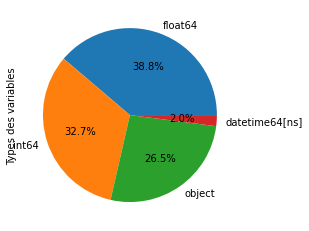

In [33]:
df.dtypes.value_counts().plot(kind="pie",ylabel='Types des variables', autopct = lambda x: str(round(x, 1)) + '%')
plt.show()

In [34]:
# On inspecte les variables numériques et les variables catégorielles
col_categoricals = []
col_numericals_float = []
col_numericals_int = []
for col in df.columns :
    if df[col].dtypes == 'float64':
        col_numericals_float.append(col)
    elif df[col].dtypes == 'object' :
        col_categoricals.append(col)
    elif df[col].dtypes == 'int64':
        col_numericals_int.append(col)

print(f"Liste des colonnes catégorielles :\n{col_categoricals}")
print(f"\nListe des colonnes numériques décimales :\n{col_numericals_float}")
print(f"\nListe des colonnes numériques entières :\n{col_numericals_int}")

Liste des colonnes catégorielles :
['ASU_BIEN_FIN_BRP', 'NAT_BIEN_FIN_BRP', 'COD_ETA_BIEN_CRI', 'IRPAR_USAGE_V12_MAX', 'SIT_FAM_INT_BRP', 'STA_CLP_BRP', 'TYP_CNT_TRA_MAX_BRP', 'QUA_INT_MAX_BRP', 'COD_SITU_LOGT_CRI', 'COD_TYPE_MARCHE_CRI', 'IND_INCIDENT_BDF_CRI', 'IND_PRIMO_ACCEDT_CRI', 'CSP_RGP_BRP']

Liste des colonnes numériques décimales :
['PCT_ENDETTMT_CRI', 'TX_APPORT_SE_BRP', 'LTV_OCTROI_BRP', 'MNT_PRET_CRI', 'PCT_NEGOC_CRI', 'PCT_TEG_TAEG_CRI', 'MNT_TOT_ASSURANCE_CRI', 'MNT_COUT_TOT_CREDIT_CRI', 'cout_projet_tf_ht_BRP', 'COUT_TRAVAUX_BRP', 'COUT_BIEN_FINANCE_BRP', 'Anc_banc_INT_jr_MAX_BRP', 'MNT_RESSOURCES_CRI', 'SUM_EPARGNE_BRP', 'SUM_PATR_IMMO_BRP', 'financement_tot', 'quotite', 'MNT_PRET_ENC_HRSLCL_CRI', 'MNT_PRET_ENC_LCL_CRI']

Liste des colonnes numériques entières :
['nb_pret', 'NBR_INT_BRP', 'TOP_PRET_RELAIS_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exist_conso_revo_BRP', 'NBR_DUREE_TOT_PRET_CRI', 'TOP_NAT_FR_CRI', 'NBR_ENF_CHAR_BRP', 'NBR_AUT_CHAR_BRP', 'ROL_INT_MAX_BRP', 'N

In [35]:
for col in col_categoricals:
    print(col, df[col].unique())

ASU_BIEN_FIN_BRP ['10' '20' '40' '50' '60' '30' '80']
NAT_BIEN_FIN_BRP ['20' '10' '50' '90' '80' '100' '30' '40' '70' '60' '140' '130' '120'
 '110' '150']
COD_ETA_BIEN_CRI ['60' '20' '10' '30' '50' '40' '120' '140' '130' '70' '110' '150']
IRPAR_USAGE_V12_MAX ['1' '2' '5' '6' '3' '4' '8' '7' '9' '<NA>']
SIT_FAM_INT_BRP ['3' '5' '2' '1' '4' '<NA>' '6']
STA_CLP_BRP ['2' '1' '<NA>' '3' '4']
TYP_CNT_TRA_MAX_BRP ['1' '8' '4' '13' '2' '12' '6' 'nan' '3' '9' '5' '11' '7' '10']
QUA_INT_MAX_BRP ['4' '3' '2' '5']
COD_SITU_LOGT_CRI ['10' '40' '70' '20' '30' '60' '<NA>' '50' '900' '90']
COD_TYPE_MARCHE_CRI ['M1' 'M21' 'M2']
IND_INCIDENT_BDF_CRI ['N' 'O']
IND_PRIMO_ACCEDT_CRI ['2' '1' '<NA>']
CSP_RGP_BRP ['3' '7' '5' '4' '2' '6' '8' '<NA>' '1' '9']


# Sélection des variables

## Statistiques descriptives

In [36]:
# Statistiques descriptives
df.select_dtypes("float").describe()

PCT_ENDETTMT_CRI  TX_APPORT_SE_BRP  LTV_OCTROI_BRP  MNT_PRET_CRI  \
count     163614.000000     163614.000000   133865.000000  1.636140e+05   
mean          33.572435          0.192973        0.763841  1.735032e+05   
std           17.105735          0.232756        0.267408  1.697095e+05   
min            0.000000          0.000000        0.000452  1.000000e+02   
25%           25.750988          0.000000        0.570718  7.680625e+04   
50%           32.550930          0.092200        0.835449  1.410170e+05   
75%           39.645657          0.329700        1.000000  2.210000e+05   
max          998.092480          1.025300        4.395022  1.280000e+07   

       PCT_NEGOC_CRI  PCT_TEG_TAEG_CRI  MNT_TOT_ASSURANCE_CRI  \
count  163614.000000     163614.000000          160255.000000   
mean        1.827250          2.834497            9403.724226   
std         0.659781          0.807864           12181.231467   
min         0.000000          0.000000               0.000000   
25%         1.400000          2.287747            1276.490000   
50%         1.750000          2.763869            5665.650000   
75%         2.230000          3.305687           13127.895000   
max         4.970000         16.870178          512038.000000   

       MNT_COUT_TOT_CREDIT_CRI  cout_projet_tf_ht_BRP  COUT_TRAVAUX_BRP  \
count             1.636140e+05           1.636140e+05      1.636140e+05   
mean              4.053068e+04           2.165116e+05      9.477021e+03   
std               4.308790e+04           2.291692e+05      3.733238e+04   
min               0.000000e+00           0.000000e+00      0.000000e+00   
25%               1.196449e+04           9.377010e+04      0.000000e+00   
50%               2.889912e+04           1.750285e+05      0.000000e+00   
75%               5.568859e+04           2.745000e+05      0.000000e+00   
max               2.994231e+06           1.495200e+07      2.441822e+06   

       COUT_BIEN_FINANCE_BRP  Anc_banc_INT_jr_MAX_BRP  MNT_RESSOURCES_CRI  \
count           1.636140e+05            163135.000000        1.636120e+05   
mean            2.273183e+05              5733.202047        8.191430e+04   
std             2.344691e+05              4094.855414        2.055786e+05   
min             0.000000e+00                 0.000000        0.000000e+00   
25%             1.070000e+05              2234.000000        3.949200e+04   
50%             1.891076e+05              5076.000000        5.918100e+04   
75%             2.850000e+05              9000.000000        9.391900e+04   
max             1.400000e+07             24884.000000        5.555724e+07   

       SUM_EPARGNE_BRP  SUM_PATR_IMMO_BRP  financement_tot        quotite  \
count     1.401440e+05       9.778700e+04     1.636140e+05  163600.000000   
mean      2.130911e+05       9.829818e+05     1.716463e+05       0.879295   
std       1.405257e+06       1.661094e+06     1.631495e+05       0.229653   
min       0.000000e+00       0.000000e+00     0.000000e+00       0.000000   
25%       8.700000e+03       2.389410e+05     7.770000e+04       0.791203   
50%       3.217000e+04       4.850000e+05     1.426065e+05       1.000000   
75%       1.078500e+05       1.080000e+06     2.209321e+05       1.025820   
max       1.792100e+08       1.000000e+08     1.280000e+07       5.294118   

       MNT_PRET_ENC_HRSLCL_CRI  MNT_PRET_ENC_LCL_CRI  
count             1.636140e+05          1.636140e+05  
mean              1.737390e+03          5.224167e+04  
std               2.070368e+04          1.453785e+05  
min               0.000000e+00          0.000000e+00  
25%               0.000000e+00          0.000000e+00  
50%               0.000000e+00          0.000000e+00  
75%               0.000000e+00          2.815649e+04  
max               1.700000e+06          1.238756e+07

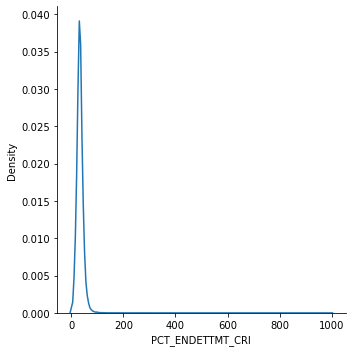

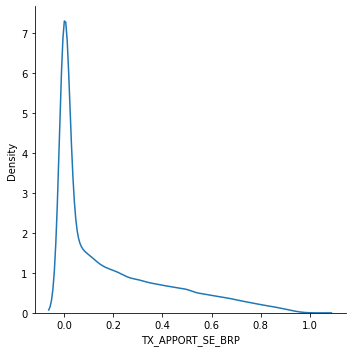

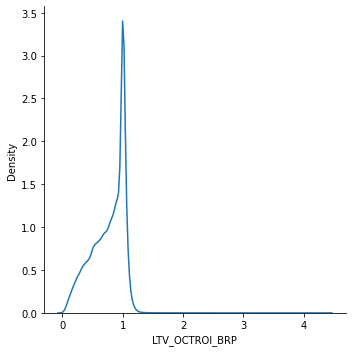

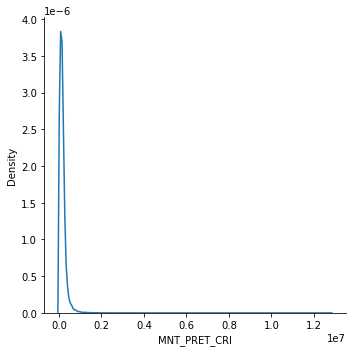

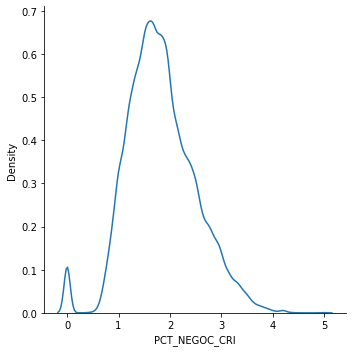

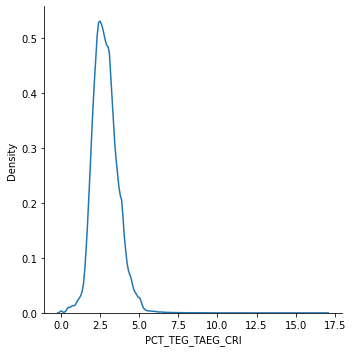

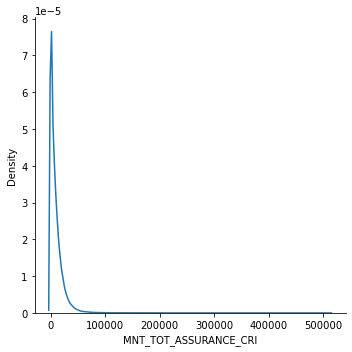

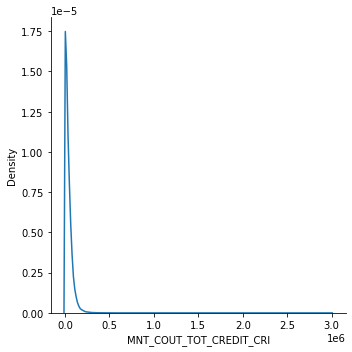

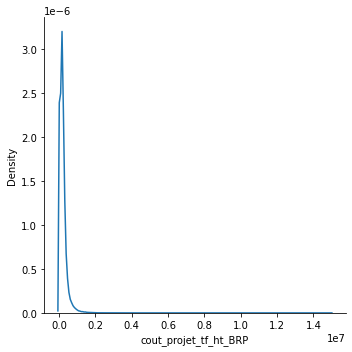

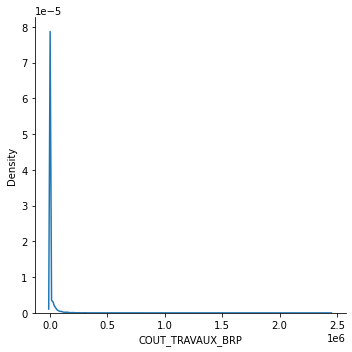

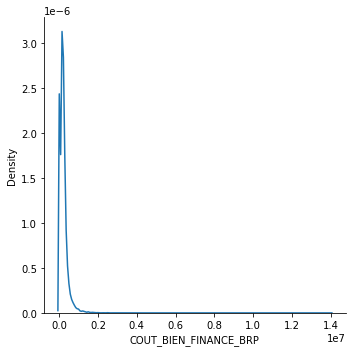

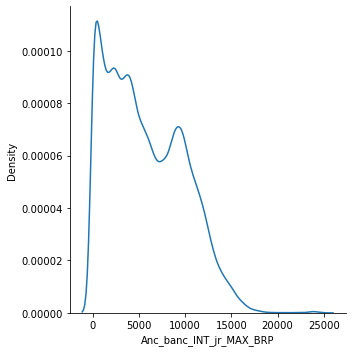

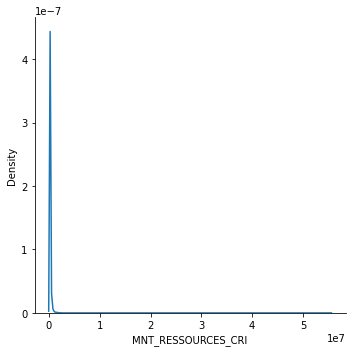

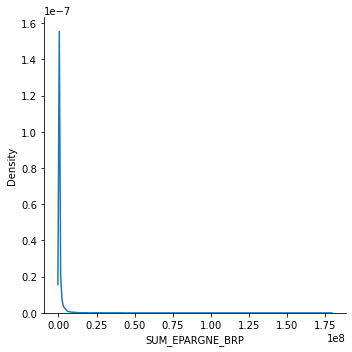

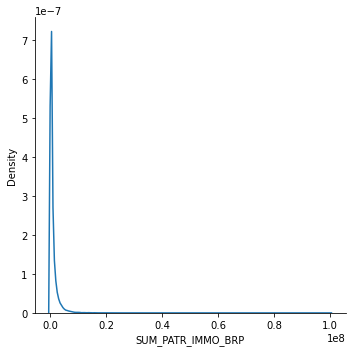

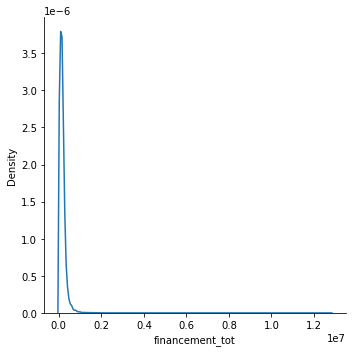

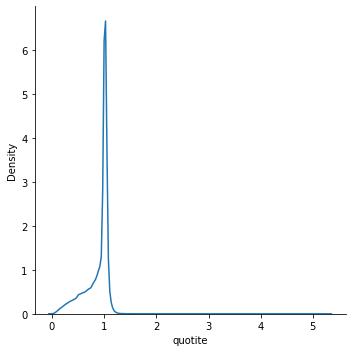

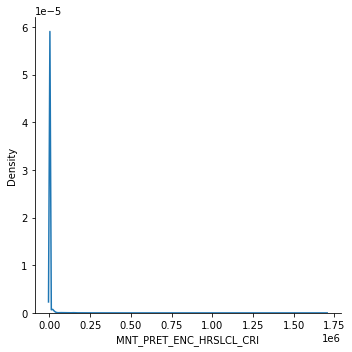

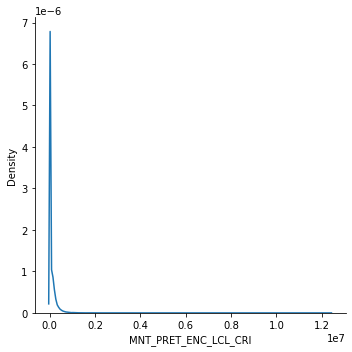

In [37]:
for col in col_numericals_float:
    sns.displot(df[col],kind="kde")
    plt.show()

**_Nous remarquons que la moyenne est souvent assez éloigné de la médiane. Nous allons donc regarder les distributions._**

**_Nous avons des distributions asymétriques. Il faut donc imputer par la médiane. Cependant, l'une des hypothèses pour l'imputation des valeurs manquantes d'une variable est qu'elles doivent être aléatoires. Cela n'est pas le cas pour l'une des variables. Pour cette variable, nous n'imputerons pas les valeurs manquantes mais nous la discrétiserons avec une classe "Manquant" pour les valeurs manquantes._**

**_Variables catégorielles_**

In [38]:
for col in col_categoricals:
    print(col, df[col].unique())

ASU_BIEN_FIN_BRP ['10' '20' '40' '50' '60' '30' '80']
NAT_BIEN_FIN_BRP ['20' '10' '50' '90' '80' '100' '30' '40' '70' '60' '140' '130' '120'
 '110' '150']
COD_ETA_BIEN_CRI ['60' '20' '10' '30' '50' '40' '120' '140' '130' '70' '110' '150']
IRPAR_USAGE_V12_MAX ['1' '2' '5' '6' '3' '4' '8' '7' '9' '<NA>']
SIT_FAM_INT_BRP ['3' '5' '2' '1' '4' '<NA>' '6']
STA_CLP_BRP ['2' '1' '<NA>' '3' '4']
TYP_CNT_TRA_MAX_BRP ['1' '8' '4' '13' '2' '12' '6' 'nan' '3' '9' '5' '11' '7' '10']
QUA_INT_MAX_BRP ['4' '3' '2' '5']
COD_SITU_LOGT_CRI ['10' '40' '70' '20' '30' '60' '<NA>' '50' '900' '90']
COD_TYPE_MARCHE_CRI ['M1' 'M21' 'M2']
IND_INCIDENT_BDF_CRI ['N' 'O']
IND_PRIMO_ACCEDT_CRI ['2' '1' '<NA>']
CSP_RGP_BRP ['3' '7' '5' '4' '2' '6' '8' '<NA>' '1' '9']


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163614 entries, 0 to 163613
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   nb_pret                   163614 non-null  int64         
 1   ASU_BIEN_FIN_BRP          163614 non-null  object        
 2   NAT_BIEN_FIN_BRP          163614 non-null  object        
 3   NBR_INT_BRP               163614 non-null  int64         
 4   COD_ETA_BIEN_CRI          163614 non-null  object        
 5   PCT_ENDETTMT_CRI          163614 non-null  float64       
 6   TOP_PRET_RELAIS_BRP       163614 non-null  int64         
 7   TX_APPORT_SE_BRP          163614 non-null  float64       
 8   LTV_OCTROI_BRP            133865 non-null  float64       
 9   TOP_SURFINANCEMENT_BRP    163614 non-null  int64         
 10  top_exist_conso_revo_BRP  163614 non-null  int64         
 11  NBR_DUREE_TOT_PRET_CRI    163614 non-null  int64         
 12  MN

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - ASU_BIEN_FIN_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



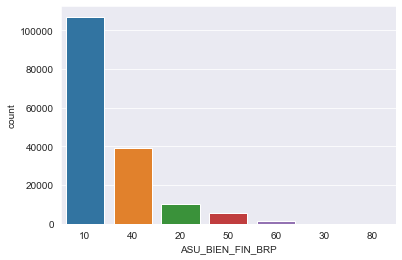

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - NAT_BIEN_FIN_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



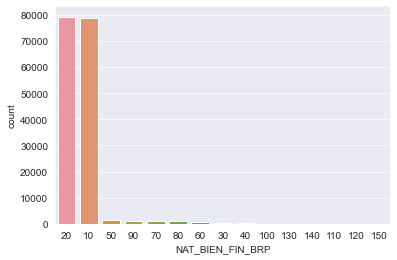

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - COD_ETA_BIEN_CRI -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



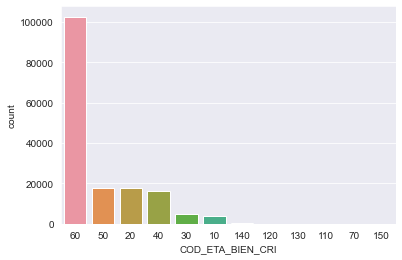

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - IRPAR_USAGE_V12_MAX -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



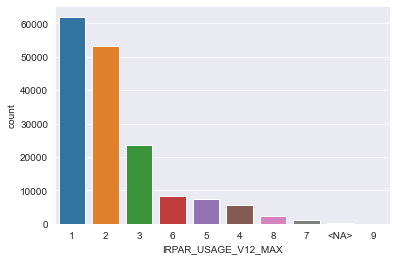

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - SIT_FAM_INT_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



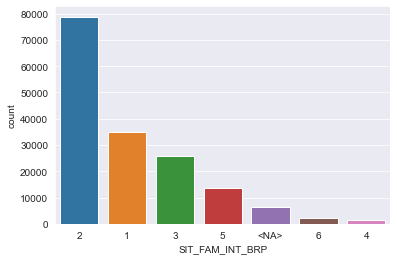

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - STA_CLP_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



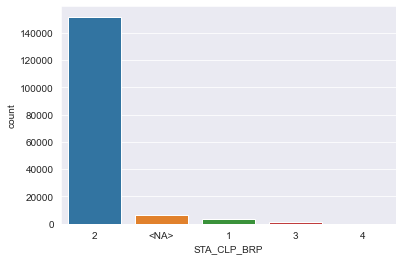

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - TYP_CNT_TRA_MAX_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



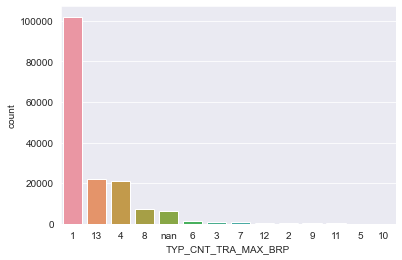

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - QUA_INT_MAX_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



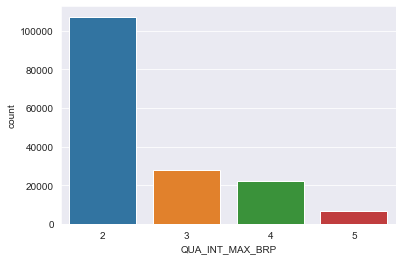

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - COD_SITU_LOGT_CRI -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



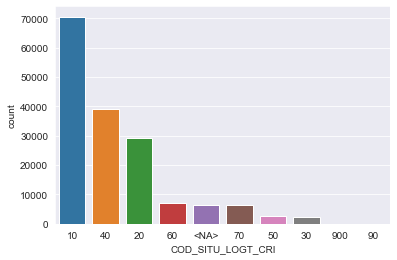

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - COD_TYPE_MARCHE_CRI -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



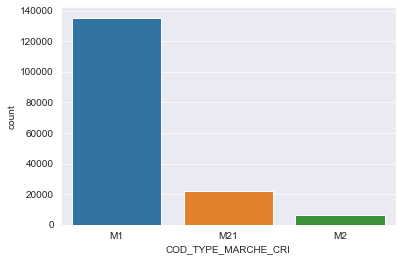

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - IND_INCIDENT_BDF_CRI -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



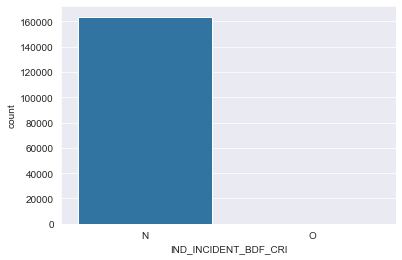

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - IND_PRIMO_ACCEDT_CRI -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



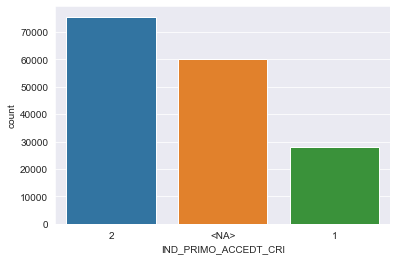

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - CSP_RGP_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



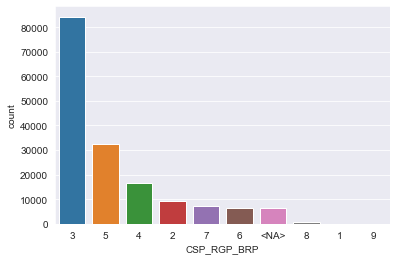

In [40]:
sns.set_style("darkgrid")
for col in [col for col in col_categoricals if col !="date_debloc_avec_crd"]:
    print(15*' - ' + col + 15*' - ' +'\n') 
    try:
        sns.countplot(df[col], order = df[col].value_counts().index)
        plt.show()
    except :
        pass

In [41]:
# Affichage du nombre de modalités par variable
var_cate = [col for col in df.columns if df[col].dtype=='O']
for col in var_cate:
    print(f"La variable {col} contient {df[col].nunique()} modalités.") 

La variable ASU_BIEN_FIN_BRP contient 7 modalités.
La variable NAT_BIEN_FIN_BRP contient 15 modalités.
La variable COD_ETA_BIEN_CRI contient 12 modalités.
La variable IRPAR_USAGE_V12_MAX contient 10 modalités.
La variable SIT_FAM_INT_BRP contient 7 modalités.
La variable STA_CLP_BRP contient 5 modalités.
La variable TYP_CNT_TRA_MAX_BRP contient 14 modalités.
La variable QUA_INT_MAX_BRP contient 4 modalités.
La variable COD_SITU_LOGT_CRI contient 10 modalités.
La variable COD_TYPE_MARCHE_CRI contient 3 modalités.
La variable IND_INCIDENT_BDF_CRI contient 2 modalités.
La variable IND_PRIMO_ACCEDT_CRI contient 3 modalités.
La variable CSP_RGP_BRP contient 10 modalités.


In [42]:
# À supprimer ? 
df["IND_INCIDENT_BDF_CRI"].value_counts()

N    163607
O         7
Name: IND_INCIDENT_BDF_CRI, dtype: int64


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - ASU_BIEN_FIN_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



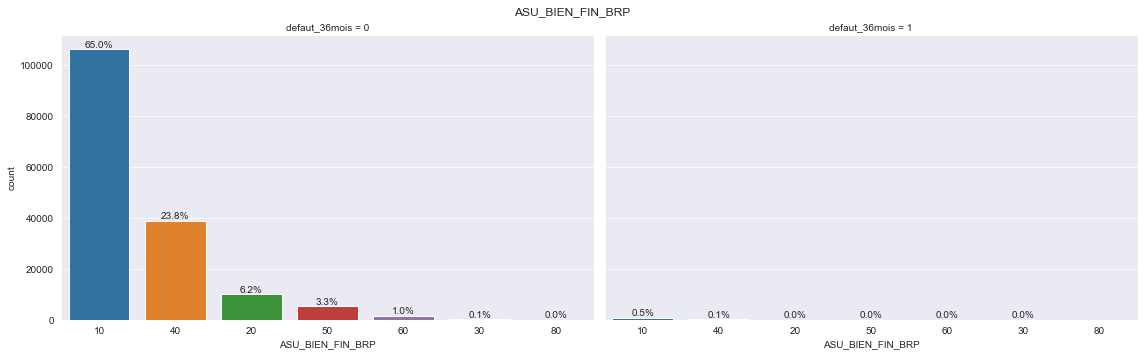


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - NAT_BIEN_FIN_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



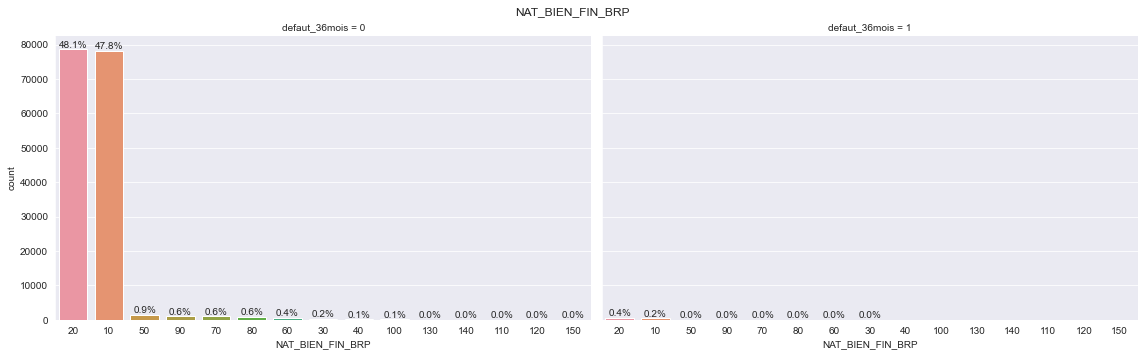


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - COD_ETA_BIEN_CRI -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



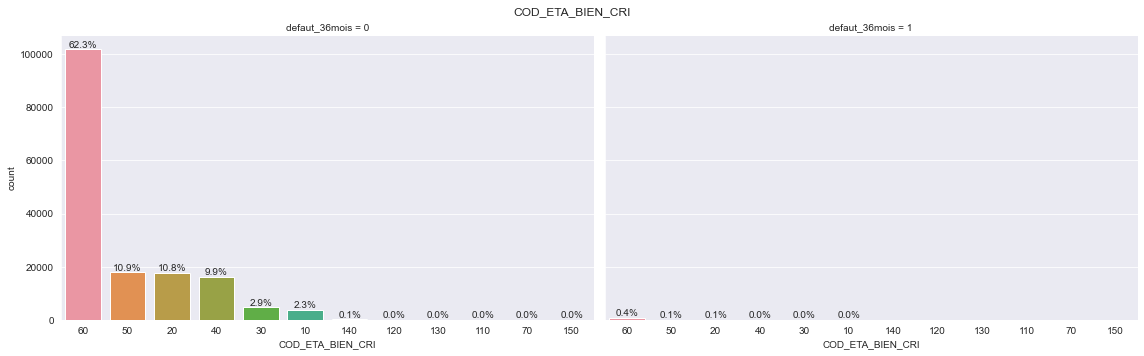


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - IRPAR_USAGE_V12_MAX -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



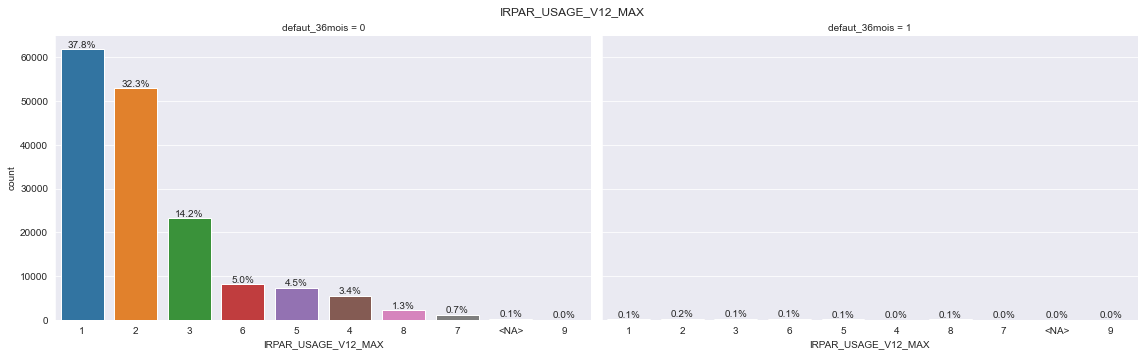


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - SIT_FAM_INT_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



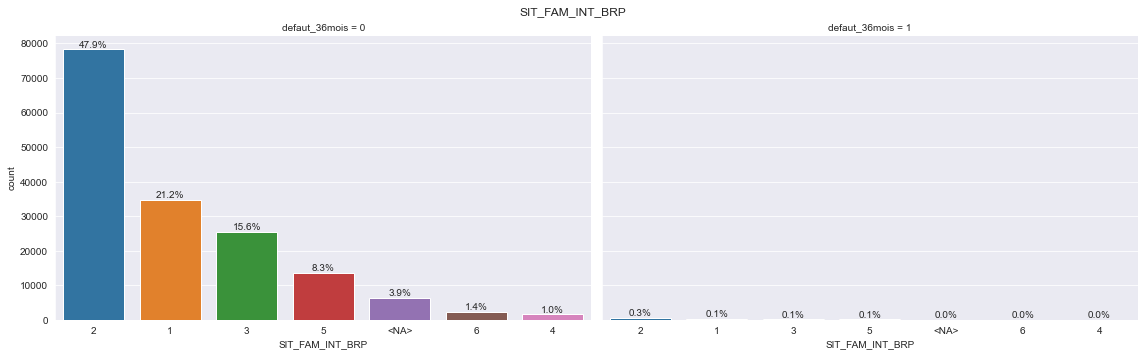


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - STA_CLP_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



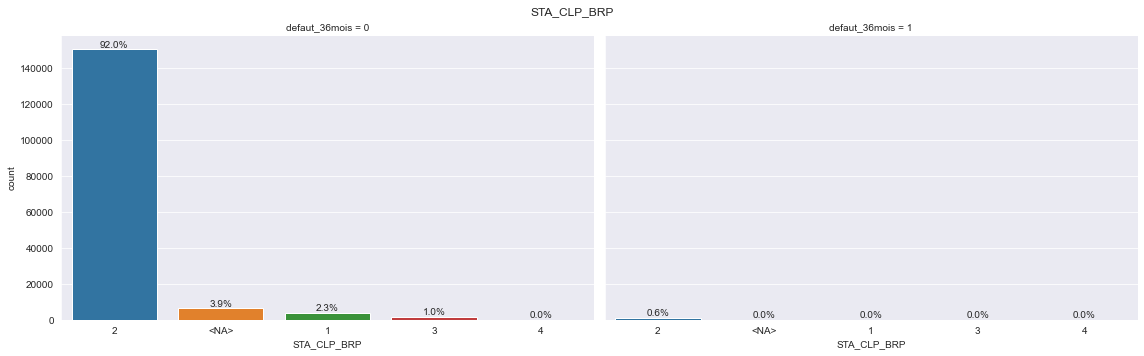


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - TYP_CNT_TRA_MAX_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



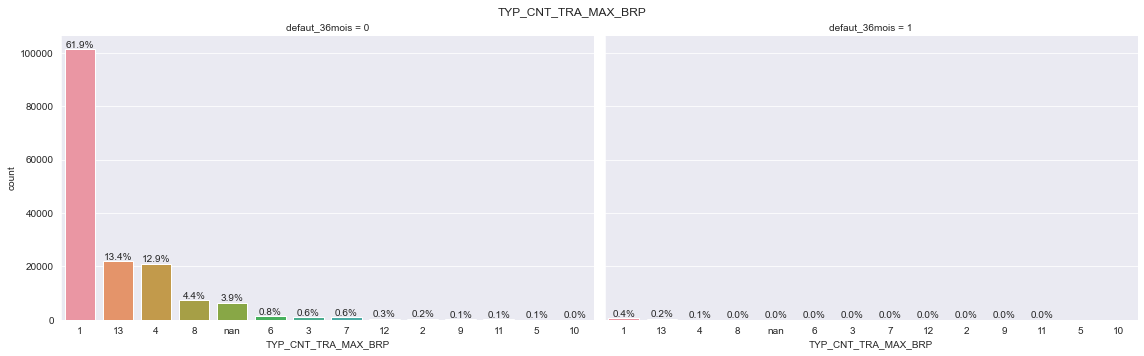


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - QUA_INT_MAX_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



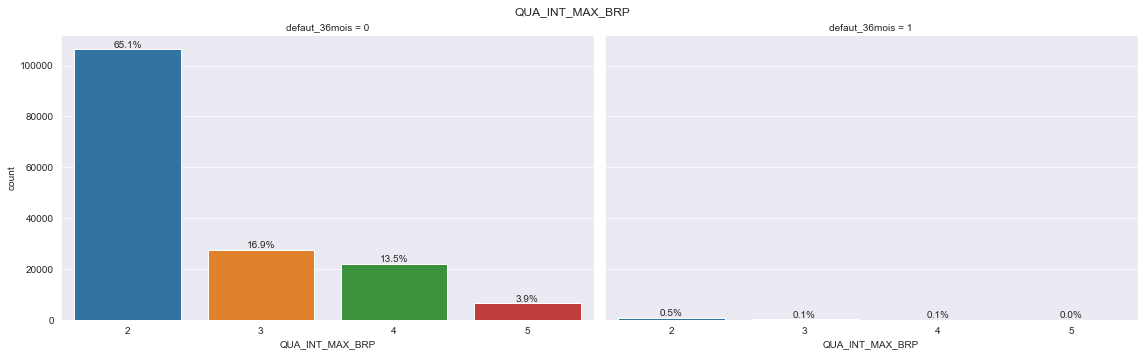


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - COD_SITU_LOGT_CRI -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



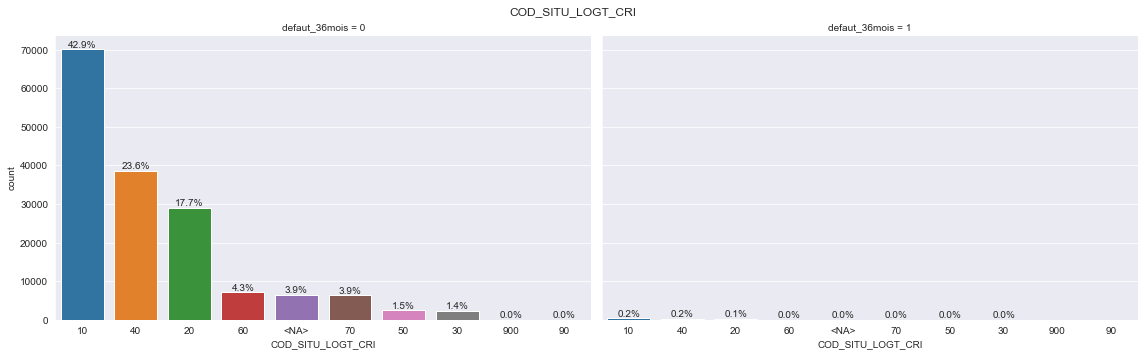


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - COD_TYPE_MARCHE_CRI -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



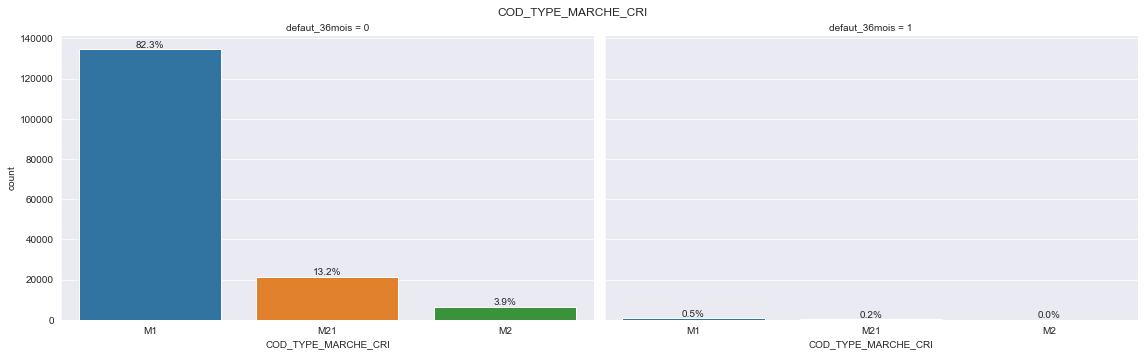


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - IND_INCIDENT_BDF_CRI -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



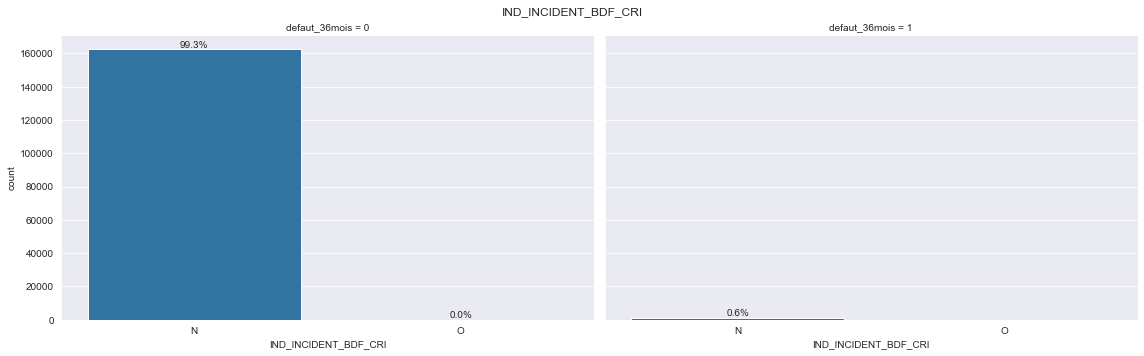


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - IND_PRIMO_ACCEDT_CRI -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



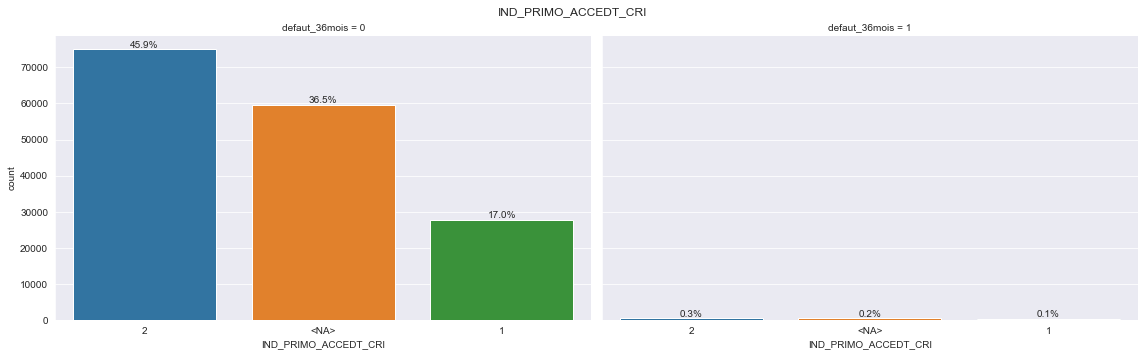


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  - CSP_RGP_BRP -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



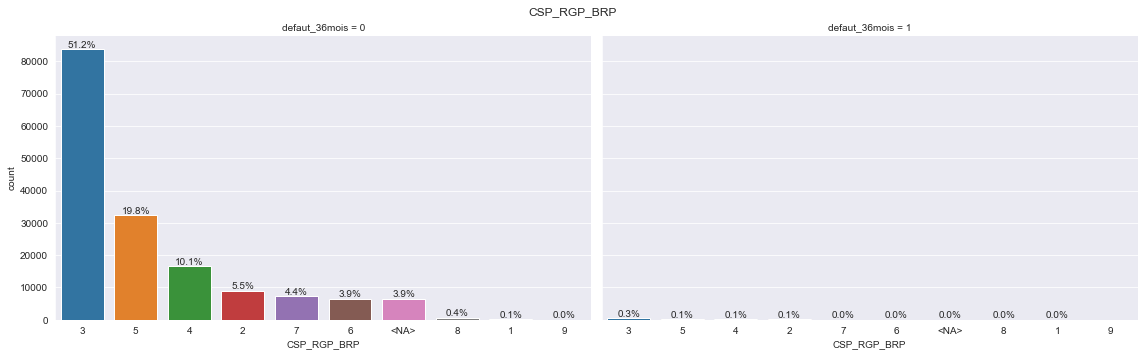

In [43]:
for col in col_categoricals:
    print('\n' + 15*' - ' + col + 15*' - ' +'\n')
    fg = sns.catplot(data=df, kind='count', x=col,  col='defaut_36mois', order = df[col].value_counts().index, height=5, aspect=8/5)
    fg.fig.subplots_adjust(top=0.9)
    
    fg.fig.suptitle(str(col))

    for ax in fg.axes.ravel():
        
        for c in ax.containers:

            labels = [f'{h/df[col].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]

            ax.bar_label(c, labels=labels, label_type='edge')

    plt.show()

**_Certaines variables contiennent trop de modalités avec de faibles effectifs. Il faudra donc faire un regroupement de modalités pour plus de clarté dans notre code._**

**Split de la base de données**

In [44]:
train, test = train_test_split(df, test_size=0.2, random_state=123, stratify=df['defaut_36mois'])

## Test de liaisons (Pearson, Khi-2, Kruskall-Wallis, ...)

In [45]:
# Test de Chi-deux
# Dictionnaire contenant les résultats du test
chi2_check = {}

# Calcul de la statistique de test et de la p_value
for column in col_categoricals :
    chi, p, dof, ex = chi2_contingency(pd.crosstab(train['defaut_36mois'], train[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('Statistique',[]).append(chi)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# Convertion du dictionnaire en DataFrame
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

In [46]:
chi2_result

Feature  Statistique       p-value
0    IRPAR_USAGE_V12_MAX  1511.536937  0.000000e+00
1    TYP_CNT_TRA_MAX_BRP   114.032337  0.000000e+00
2    COD_TYPE_MARCHE_CRI    74.510288  0.000000e+00
3            CSP_RGP_BRP    70.431594  0.000000e+00
4       NAT_BIEN_FIN_BRP    77.409246  1.000000e-10
5      COD_SITU_LOGT_CRI    32.028730  1.968643e-04
6        QUA_INT_MAX_BRP    14.646680  2.144887e-03
7            STA_CLP_BRP    16.253021  2.697778e-03
8       ASU_BIEN_FIN_BRP    19.245903  3.767881e-03
9       COD_ETA_BIEN_CRI    24.880831  9.489923e-03
10  IND_PRIMO_ACCEDT_CRI     8.777836  1.241415e-02
11       SIT_FAM_INT_BRP     6.796127  3.401136e-01
12  IND_INCIDENT_BDF_CRI     0.000000  1.000000e+00

**_Au seuil de 5%, nous décidons de sélectionner les 10 premières variables catégorielles._**

In [47]:
# Test de Kruskal Wallis
# Redéfinir la liste des variables quantitatives
col_numericals = col_numericals_float + col_numericals_int

# Dictionnaire contenant les résultats du test
kruskal_wallis_test = {}

# Calcul de la statistique de test et de la p_value
for column in col_numericals :
    kstat, pval = stats.kruskal(*[group[column].values for name, group in train.groupby('defaut_36mois')], nan_policy='omit')
    kruskal_wallis_test.setdefault('Feature',[]).append(column)
    kruskal_wallis_test.setdefault('Statistique',[]).append(kstat)
    kruskal_wallis_test.setdefault('p-value',[]).append(round(pval, 10))
    
# Convertion du dictionnaire en DataFrame
kruskal_wallis_test_result = pd.DataFrame(data = kruskal_wallis_test)
kruskal_wallis_test_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

In [48]:
kruskal_wallis_test_result

Feature    Statistique       p-value
0              defaut_36mois  130890.000000  0.000000e+00
1           PCT_TEG_TAEG_CRI      65.631159  0.000000e+00
2      MNT_TOT_ASSURANCE_CRI      81.405208  0.000000e+00
3    MNT_COUT_TOT_CREDIT_CRI      75.171593  0.000000e+00
4   top_exist_conso_revo_BRP     122.756453  0.000000e+00
5    Anc_banc_INT_jr_MAX_BRP      54.038911  0.000000e+00
6            SUM_EPARGNE_BRP      75.812306  0.000000e+00
7     NBR_DUREE_TOT_PRET_CRI      42.754829  1.000000e-10
8           TX_APPORT_SE_BRP      40.376342  2.000000e-10
9              PCT_NEGOC_CRI      41.028207  2.000000e-10
10              MNT_PRET_CRI      26.524401  2.602000e-07
11            LTV_OCTROI_BRP      26.030963  3.360000e-07
12           financement_tot      20.202154  6.967400e-06
13          NBR_ENF_CHAR_BRP      16.089890  6.040570e-05
14               top_locatif      14.632117  1.306686e-04
15            TOP_NAT_FR_CRI      14.451221  1.438366e-04
16                   quotite      13.700505  2.143969e-04
17          PCT_ENDETTMT_CRI      12.245597  4.663574e-04
18          COUT_TRAVAUX_BRP      10.477871  1.208129e-03
19        MNT_RESSOURCES_CRI       8.043179  4.567531e-03
20       TOP_PRET_RELAIS_BRP       4.435407  3.520082e-02
21               NBR_INT_BRP       4.191601  4.062470e-02
22         SUM_PATR_IMMO_BRP       2.170529  1.406779e-01
23     cout_projet_tf_ht_BRP       1.722104  1.894224e-01
24          top_pret_int_ext       1.502833  2.202360e-01
25    TOP_SURFINANCEMENT_BRP       1.437020  2.306221e-01
26      MNT_PRET_ENC_LCL_CRI       0.837320  3.601643e-01
27                   nb_pret       0.525130  4.686615e-01
28     COUT_BIEN_FINANCE_BRP       0.180522  6.709253e-01
29           ROL_INT_MAX_BRP       0.131742  7.166331e-01
30            top_pers_seule       0.097078  7.553648e-01
31        NBR_AGE_CLIENT_CRI       0.026022  8.718468e-01
32   MNT_PRET_ENC_HRSLCL_CRI       0.015270  9.016551e-01
33          NBR_AUT_CHAR_BRP       0.014441  9.043470e-01
34           TOP_BIEN_FR_CRI       0.001080  9.737788e-01

## **Supression de variables après les tests**

In [49]:
# Récupérer les colonnes à supprimer
drop_columns_list = chi2_result.iloc[11:, 0].to_list()
drop_columns_list.extend(kruskal_wallis_test_result.iloc[22:, 0].to_list())

In [50]:
# Suppresssion des colonnes du DataFrame
train = train.drop(drop_columns_list, axis=1)
test = test.drop(drop_columns_list, axis=1)

In [51]:
train.head()

ASU_BIEN_FIN_BRP NAT_BIEN_FIN_BRP  NBR_INT_BRP COD_ETA_BIEN_CRI  \
59633               40               10            2               20   
82777               40               10            2               10   
94072               10               20            2               50   
91990               10               10            2               20   
6203                10               10            1               60   

       PCT_ENDETTMT_CRI  TOP_PRET_RELAIS_BRP  TX_APPORT_SE_BRP  \
59633          14.68363                    0            0.4805   
82777          37.78482                    0            0.0000   
94072          40.22856                    0            0.6023   
91990          58.23243                    0            0.0000   
6203           25.26246                    0            0.2391   

       LTV_OCTROI_BRP  top_exist_conso_revo_BRP  NBR_DUREE_TOT_PRET_CRI  ...  \
59633        0.519481                         0                     132  ...   
82777        1.014472                         1                     324  ...   
94072        0.397692                         1                     180  ...   
91990        1.000610                         1                     324  ...   
6203         0.760870                         0                     180  ...   

       COD_TYPE_MARCHE_CRI  IND_PRIMO_ACCEDT_CRI  MNT_RESSOURCES_CRI  \
59633                   M1                  <NA>             76598.0   
82777                   M1                     2             64237.0   
94072                   M1                  <NA>            163642.0   
91990                   M1                     1             39979.0   
6203                    M1                  <NA>             22803.0   

       SUM_EPARGNE_BRP  defaut_36mois  CSP_RGP_BRP financement_tot   quotite  \
59633         45994.00              0            3         80000.0  0.519481   
82777         31244.00              0            4        146997.0  1.014472   
94072        168000.00              0            2        357923.0  1.028748   
91990         15317.49              0            6        246050.0  1.000610   
6203          55039.69              0            6         70000.0  0.760870   

       top_locatif  date_debloc_avec_crd  
59633            1            2016-05-01  
82777            1            2016-11-01  
94072            0            2016-12-01  
91990            0            2016-11-01  
6203             0            2014-06-01  

[5 rows x 34 columns]

<AxesSubplot:>

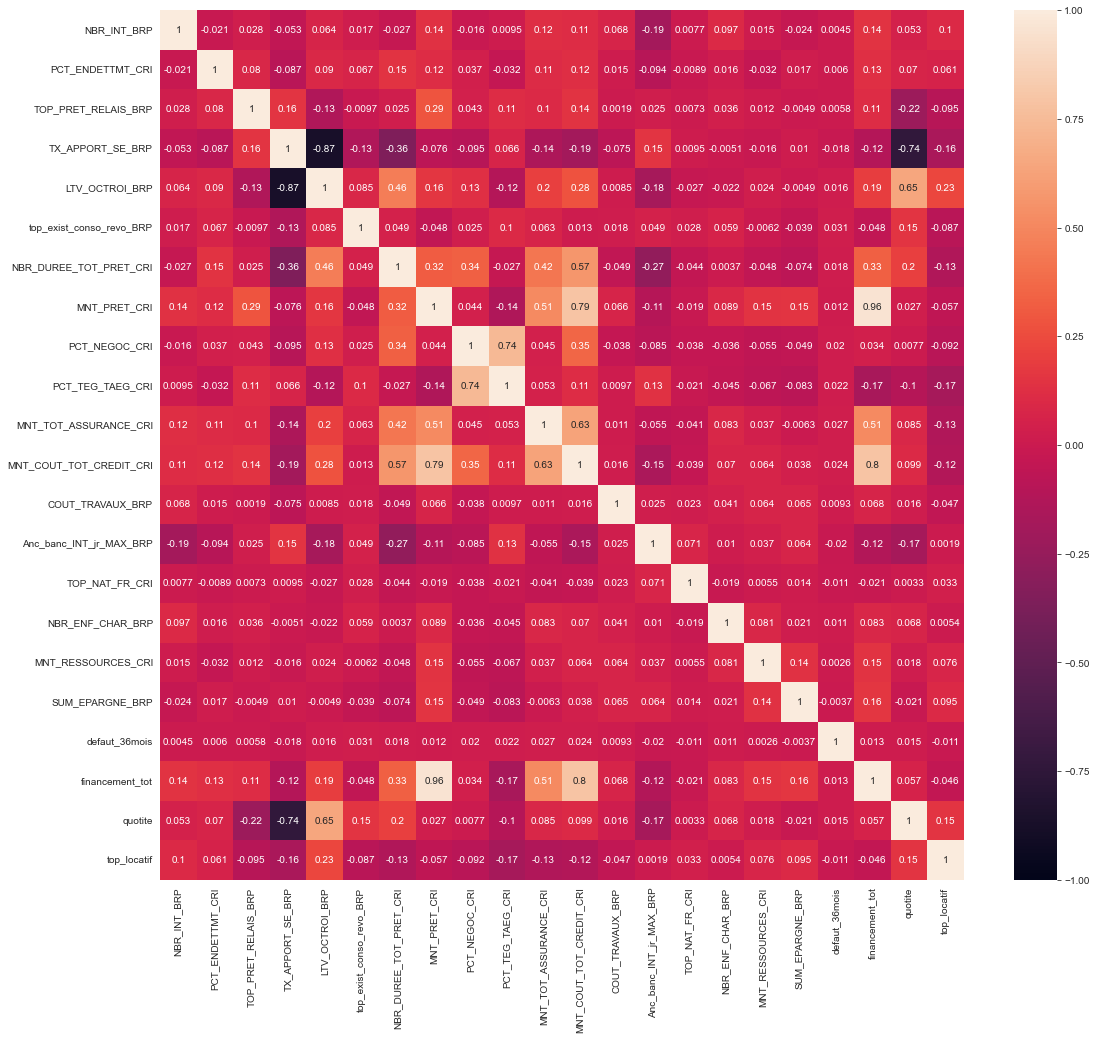

In [52]:
plt.figure(figsize = (18, 16))
sns.heatmap(train.corr(), annot=True,vmin=-1,vmax=1)

In [53]:
# Supression des colonnes
train=train.drop(['financement_tot', 'quotite', 'LTV_OCTROI_BRP', 'MNT_COUT_TOT_CREDIT_CRI',
                                      'PCT_TEG_TAEG_CRI', 'MNT_TOT_ASSURANCE_CRI', 'NBR_DUREE_TOT_PRET_CRI'], axis=1)

test=test.drop(['financement_tot', 'quotite', 'LTV_OCTROI_BRP', 'MNT_COUT_TOT_CREDIT_CRI',
                                      'PCT_TEG_TAEG_CRI', 'MNT_TOT_ASSURANCE_CRI', 'NBR_DUREE_TOT_PRET_CRI'], axis=1)

<AxesSubplot:>

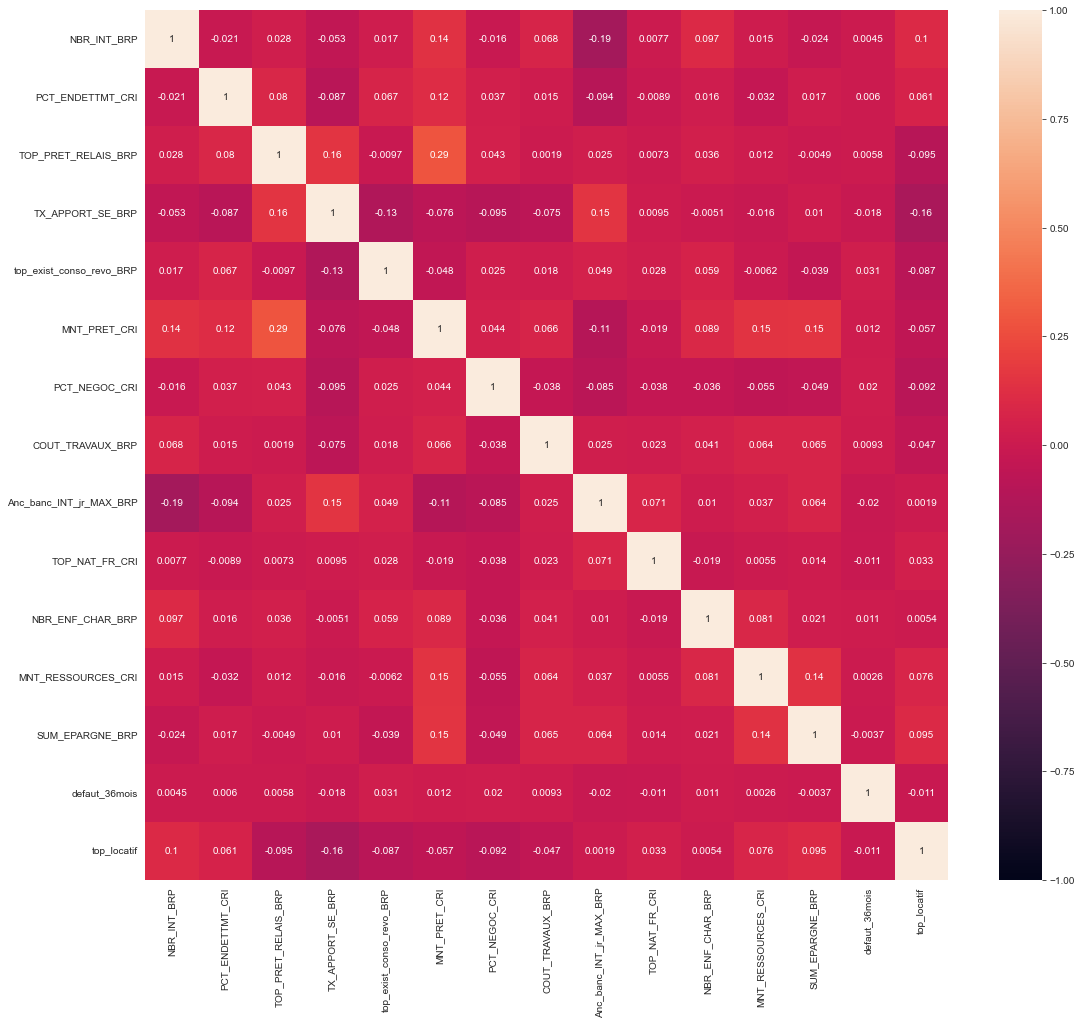

In [54]:
# Corrélation entre les variables 
plt.figure(figsize = (18, 16))
sns.heatmap(train.corr(), annot=True,vmin=-1,vmax=1)

In [55]:
# Taux de valeurs manquantes  sur la nouvelle base des données 
taux_de_NAN = round((train.isna().sum()*100/train.shape[0]).sort_values(ascending=True),4)
taux_de_NAN

ASU_BIEN_FIN_BRP             0.0000
CSP_RGP_BRP                  0.0000
defaut_36mois                0.0000
IND_PRIMO_ACCEDT_CRI         0.0000
COD_TYPE_MARCHE_CRI          0.0000
COD_SITU_LOGT_CRI            0.0000
QUA_INT_MAX_BRP              0.0000
TYP_CNT_TRA_MAX_BRP          0.0000
STA_CLP_BRP                  0.0000
NBR_ENF_CHAR_BRP             0.0000
top_locatif                  0.0000
TOP_NAT_FR_CRI               0.0000
COUT_TRAVAUX_BRP             0.0000
PCT_NEGOC_CRI                0.0000
MNT_PRET_CRI                 0.0000
top_exist_conso_revo_BRP     0.0000
TX_APPORT_SE_BRP             0.0000
TOP_PRET_RELAIS_BRP          0.0000
PCT_ENDETTMT_CRI             0.0000
COD_ETA_BIEN_CRI             0.0000
NBR_INT_BRP                  0.0000
NAT_BIEN_FIN_BRP             0.0000
IRPAR_USAGE_V12_MAX          0.0000
date_debloc_avec_crd         0.0000
MNT_RESSOURCES_CRI           0.0008
Anc_banc_INT_jr_MAX_BRP      0.2842
SUM_EPARGNE_BRP             14.3417
dtype: float64

In [56]:
train.shape

(130891, 27)

In [57]:
test.shape

(32723, 27)

In [58]:
taux_de_NAN = round((test.isna().sum()*100/test.shape[0]).sort_values(ascending=True),4)
taux_de_NAN

ASU_BIEN_FIN_BRP             0.0000
CSP_RGP_BRP                  0.0000
defaut_36mois                0.0000
IND_PRIMO_ACCEDT_CRI         0.0000
COD_TYPE_MARCHE_CRI          0.0000
COD_SITU_LOGT_CRI            0.0000
QUA_INT_MAX_BRP              0.0000
TYP_CNT_TRA_MAX_BRP          0.0000
STA_CLP_BRP                  0.0000
NBR_ENF_CHAR_BRP             0.0000
top_locatif                  0.0000
TOP_NAT_FR_CRI               0.0000
COUT_TRAVAUX_BRP             0.0000
PCT_NEGOC_CRI                0.0000
MNT_PRET_CRI                 0.0000
top_exist_conso_revo_BRP     0.0000
TX_APPORT_SE_BRP             0.0000
TOP_PRET_RELAIS_BRP          0.0000
PCT_ENDETTMT_CRI             0.0000
COD_ETA_BIEN_CRI             0.0000
NBR_INT_BRP                  0.0000
NAT_BIEN_FIN_BRP             0.0000
IRPAR_USAGE_V12_MAX          0.0000
date_debloc_avec_crd         0.0000
MNT_RESSOURCES_CRI           0.0031
Anc_banc_INT_jr_MAX_BRP      0.3270
SUM_EPARGNE_BRP             14.3569
dtype: float64

In [59]:
# Dimension de la base des données 
print(f"La base de données d'entrainement fait maintenant {train.shape[0]} lignes et {train.shape[1]} colonnes.")
print(f"La base de données de test fait maintenant {test.shape[0]} lignes et {test.shape[1]} colonnes.")

La base de données d'entrainement fait maintenant 130891 lignes et 27 colonnes.
La base de données de test fait maintenant 32723 lignes et 27 colonnes.


---

**Sur-échantillonage**

Notre jeu de données est très déséquilibré. En effet, nous avons une très faible proportion de défaut dans notre base de données. Ce déséquilibre de classe est un assez fréquent dans plusieurs cas réels tels que : la détection de fraude, la détection d’intrusion, la détection d’activité suspecte pour n’en nommer que quelques-uns. Cette structure de la base données nous est défavorable dans le sens où notre classification binaire donnera un poids plus important à la population majoritaire (la plus fréquente) au détriment de la classe minoritaire (la moins fréquente). Si nous travaillons avec un tel jeu de données, notre modèle identifiera mal la classe minoritaire mais prédira le plus souvent la classe majoritaire sur laquelle il a appris le plus. Dans notre contexte, mal prédire un défaut coûtera énormément comme pour toute activité. Pour avoir une meilleure performance du modèle, il faudra donc rééquilibrer notre base de données. 
Pour se faire nous utiliserons la méthode de sur-échantillonnage avec la fonction resample de scikit-learn. Cette méthode rajoutera des observations en faisant un tirage aléatoire avec remise des individus de la classe minoritaire afin de rehausser leur proportion.

In [60]:
# Distribution du défaut avant sur-échantilonnage
# sns.countplot(train['defaut_36mois'])
# plt.show()

**Traitement de valeurs manquantes**

In [61]:
# Imputation des valeurs par la médiane pour les variables quantitatives
colnum=['MNT_RESSOURCES_CRI', 'SUM_EPARGNE_BRP', 'Anc_banc_INT_jr_MAX_BRP']
for col in colnum :
    med = train[col].median()
    train[col] = train[col].fillna(value = med)
    test[col]  = test[col].fillna(value = med)
    
# Création de classe pour les variables qualitatives  
colcat=['IRPAR_USAGE_V12_MAX', 'STA_CLP_BRP', 'TYP_CNT_TRA_MAX_BRP', 'COD_SITU_LOGT_CRI', 'IND_PRIMO_ACCEDT_CRI', 'CSP_RGP_BRP']
for col in colcat :
    train[col] = train[col].fillna(value = '<NA>')
    test[col]  =  test[col].fillna(value = '<NA>') 

In [62]:
train.isna().sum()

ASU_BIEN_FIN_BRP            0
NAT_BIEN_FIN_BRP            0
NBR_INT_BRP                 0
COD_ETA_BIEN_CRI            0
PCT_ENDETTMT_CRI            0
TOP_PRET_RELAIS_BRP         0
TX_APPORT_SE_BRP            0
top_exist_conso_revo_BRP    0
MNT_PRET_CRI                0
PCT_NEGOC_CRI               0
COUT_TRAVAUX_BRP            0
IRPAR_USAGE_V12_MAX         0
Anc_banc_INT_jr_MAX_BRP     0
TOP_NAT_FR_CRI              0
NBR_ENF_CHAR_BRP            0
STA_CLP_BRP                 0
TYP_CNT_TRA_MAX_BRP         0
QUA_INT_MAX_BRP             0
COD_SITU_LOGT_CRI           0
COD_TYPE_MARCHE_CRI         0
IND_PRIMO_ACCEDT_CRI        0
MNT_RESSOURCES_CRI          0
SUM_EPARGNE_BRP             0
defaut_36mois               0
CSP_RGP_BRP                 0
top_locatif                 0
date_debloc_avec_crd        0
dtype: int64

In [63]:
test.isna().sum()

ASU_BIEN_FIN_BRP            0
NAT_BIEN_FIN_BRP            0
NBR_INT_BRP                 0
COD_ETA_BIEN_CRI            0
PCT_ENDETTMT_CRI            0
TOP_PRET_RELAIS_BRP         0
TX_APPORT_SE_BRP            0
top_exist_conso_revo_BRP    0
MNT_PRET_CRI                0
PCT_NEGOC_CRI               0
COUT_TRAVAUX_BRP            0
IRPAR_USAGE_V12_MAX         0
Anc_banc_INT_jr_MAX_BRP     0
TOP_NAT_FR_CRI              0
NBR_ENF_CHAR_BRP            0
STA_CLP_BRP                 0
TYP_CNT_TRA_MAX_BRP         0
QUA_INT_MAX_BRP             0
COD_SITU_LOGT_CRI           0
COD_TYPE_MARCHE_CRI         0
IND_PRIMO_ACCEDT_CRI        0
MNT_RESSOURCES_CRI          0
SUM_EPARGNE_BRP             0
defaut_36mois               0
CSP_RGP_BRP                 0
top_locatif                 0
date_debloc_avec_crd        0
dtype: int64

In [64]:
# Séparer les features de la target 
X_train = train.drop(['defaut_36mois','date_debloc_avec_crd'], axis=1)
y_train = train['defaut_36mois']

**Suréchantillonage par la méthode resample**

In [65]:
from sklearn.utils import resample 

X2 = train.copy()

X2['defaut_36mois']= y_train.values

# Définition de la classe minoritaire
class_minority=X2[X2.defaut_36mois == 1]

# Définition de la classe majoritaire
class_majority=X2[X2.defaut_36mois == 0]

In [66]:
minority_upsampled = resample(class_minority, replace = True, n_samples=len(class_majority), random_state=42)

train_up = pd.concat([class_majority, minority_upsampled]) 


La base de données contient  260088 observations.

Distribution du défaut après sur-échantilonnage simple



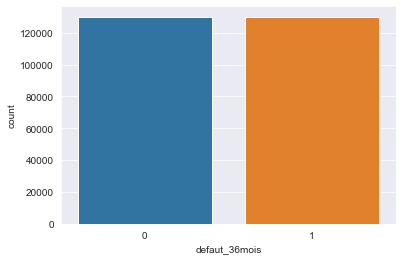

In [67]:
# Distribution du défaut après sur-échantilonnage
print("\nLa base de données contient ", train_up.shape[0], "observations.\n")
print("Distribution du défaut après sur-échantilonnage simple\n")
sns.countplot(train_up['defaut_36mois'])
plt.show()

**Export de la base de données**

In [68]:
# Reconstitution de la base
base_up = pd.concat([train_up, test])

print(base_up.shape)

(292811, 27)


In [69]:
# Exportation

base_up.to_csv('data/base_up.csv', index=False)
train_up.to_csv('data/train_up.csv', index=False)

test.to_csv('data/test.csv', index=False)

## Discrétisation

Etant donné que la discrétisation utilisant l'agorithme WOE ne fonctionne pas avec notre version installée da Anaconda nous l'effectuons sous R. Ensuite nous importons les résultats pour la suite de notre analyse sous python.

In [70]:
# Importation de la base de données 

train_up_woe = pd.read_csv("data/train_up_woe.csv")     # Train discrétisé
test_up_woe  = pd.read_csv("data/test_up_woe.csv")      # Test discrétisé
base_up_woe  = pd.read_csv("data/base_up_woe.csv")      # Base entière discrétisée


discret_up   = pd.read_csv("data/discret_up_woe.csv")   # Information des classes obtenues
classes      = pd.read_json("data/classes.json")        # Information des classes obtenues

**Etude de la stabilité temporelle**

In [71]:
var = base_up_woe.columns


----------Stabilité mensuelle en volume des classes----------



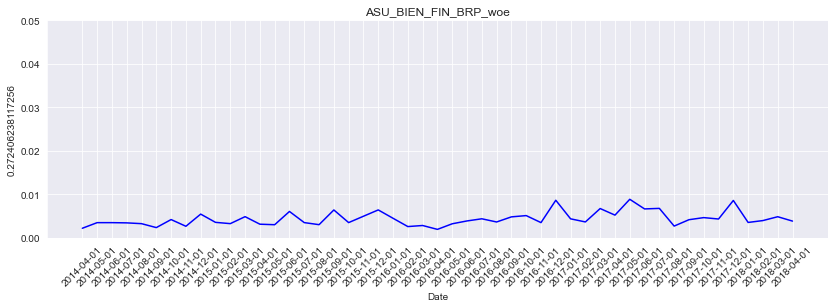

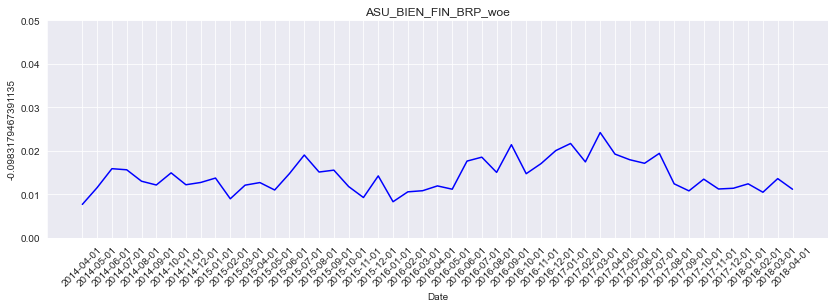

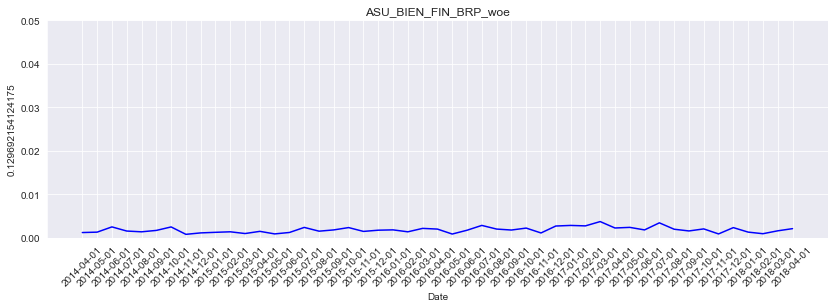

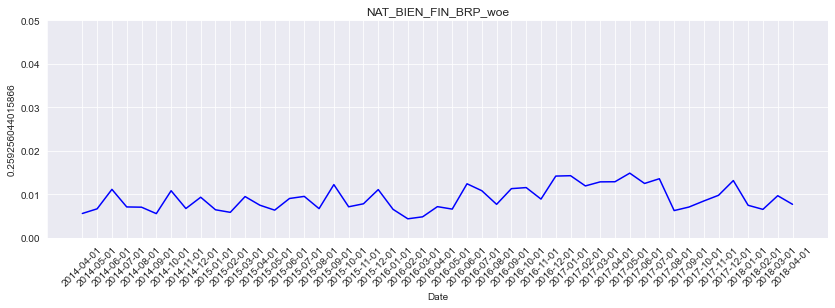

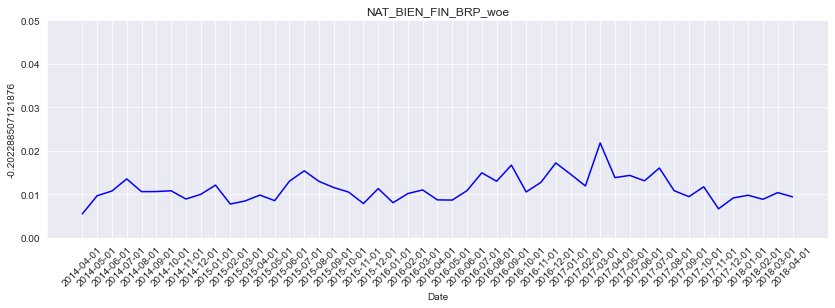

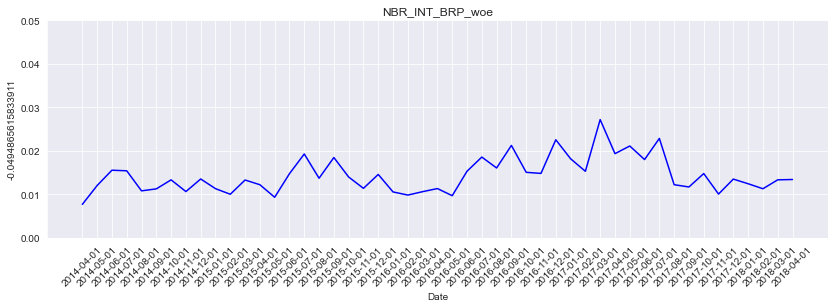

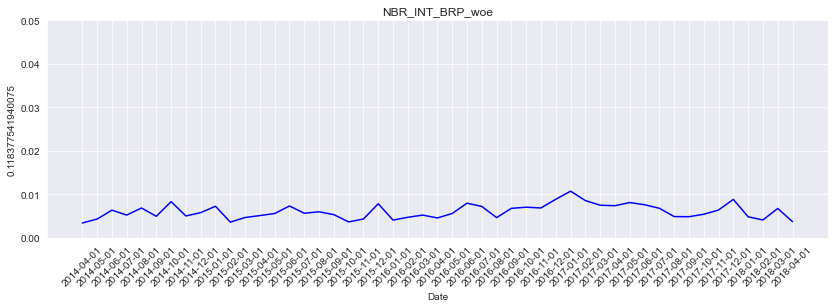

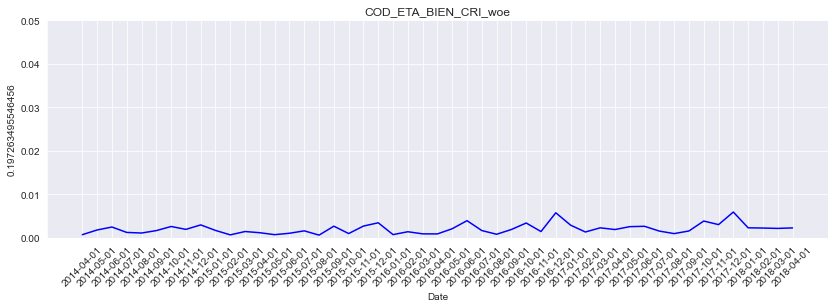

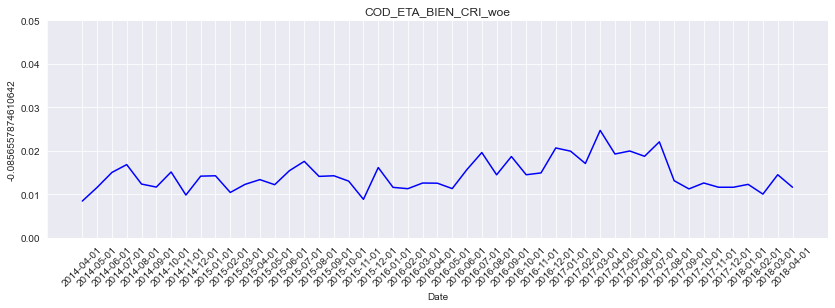

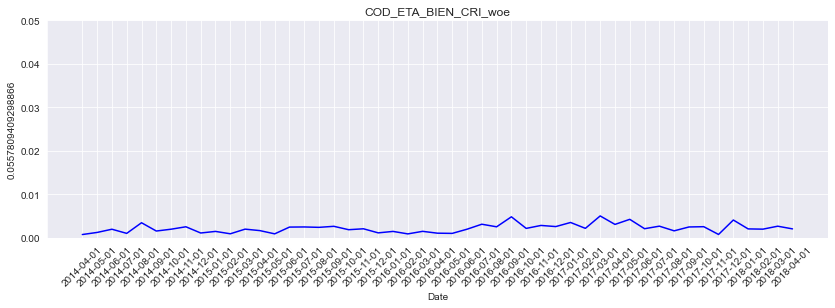

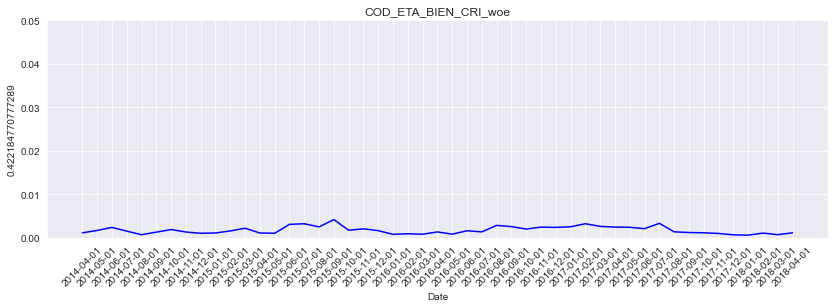

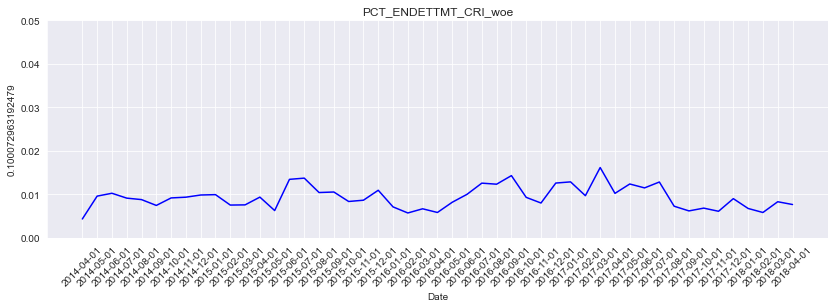

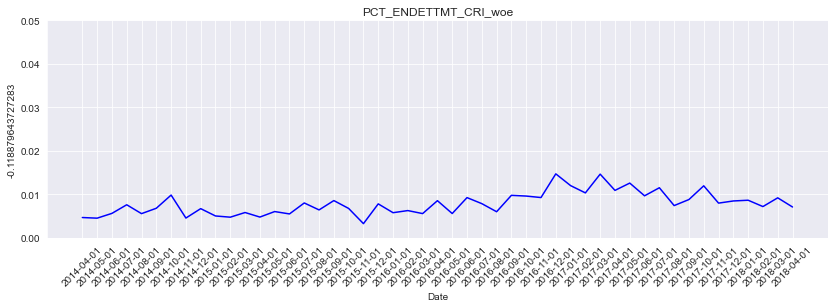

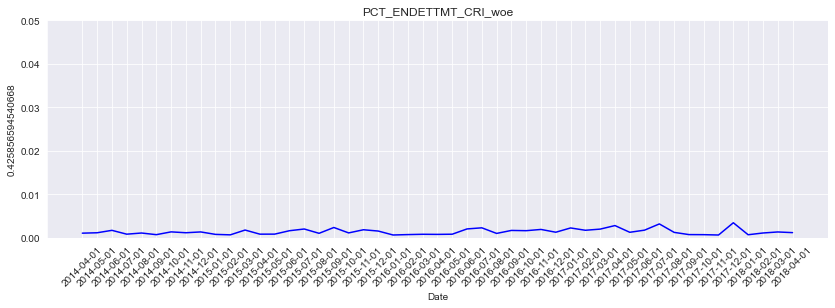

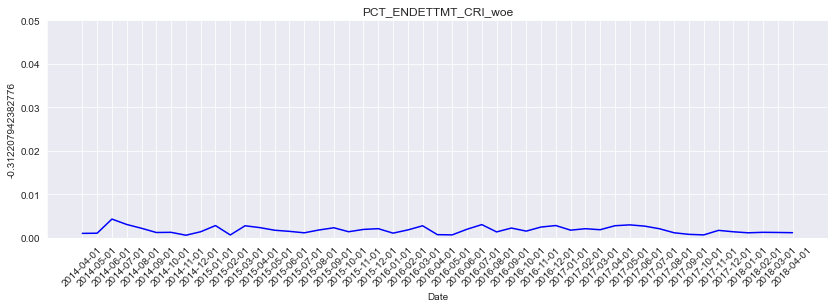

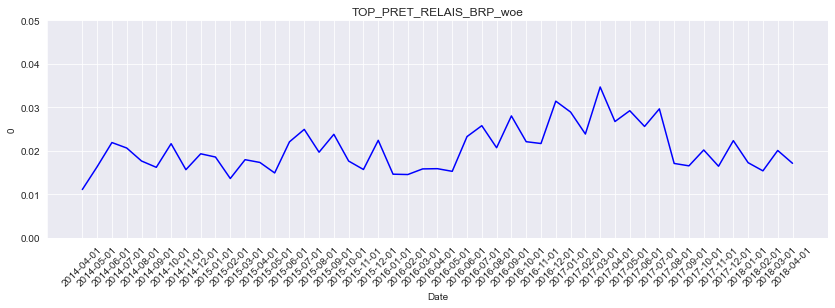

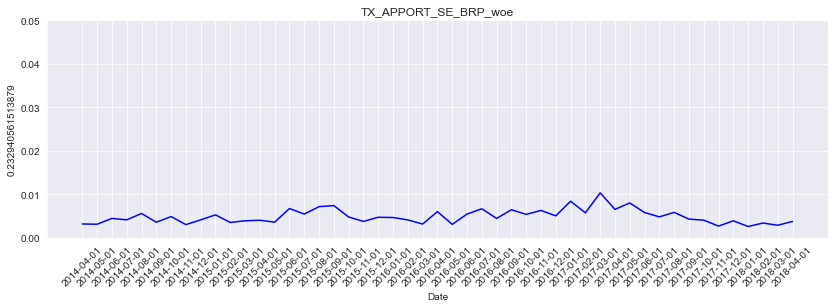

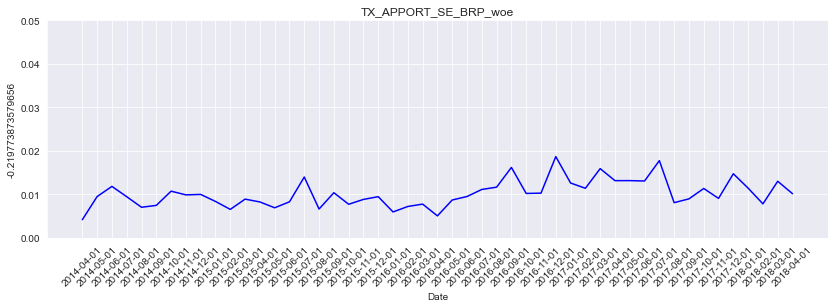

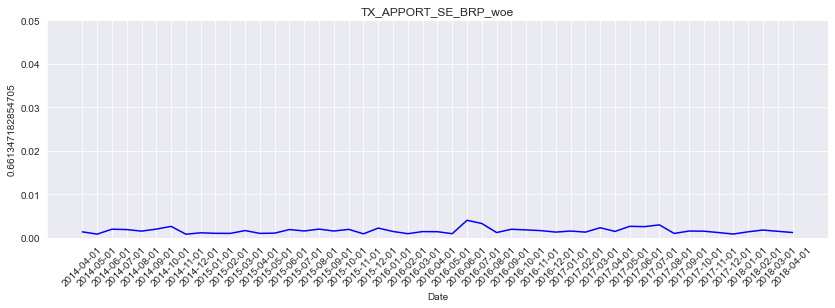

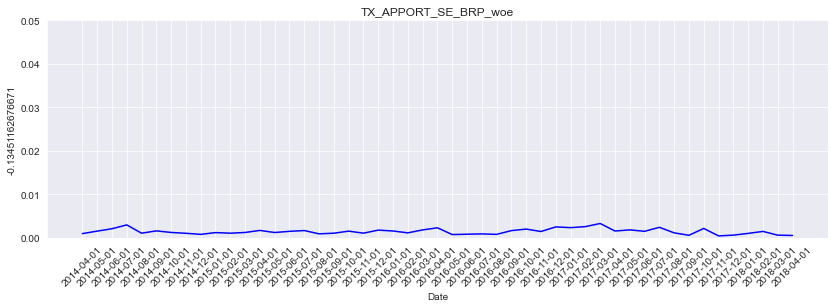

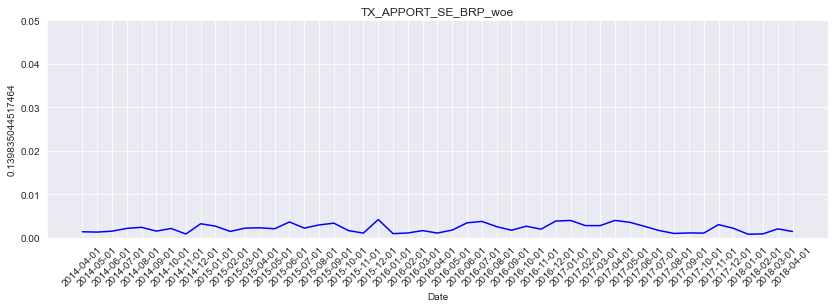

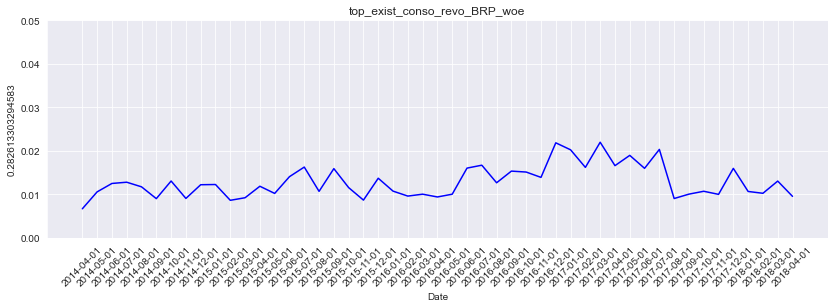

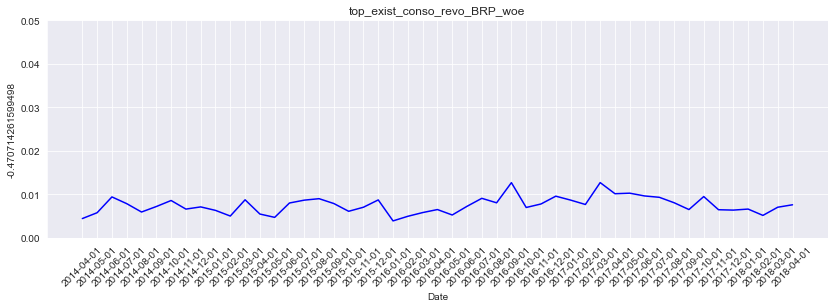

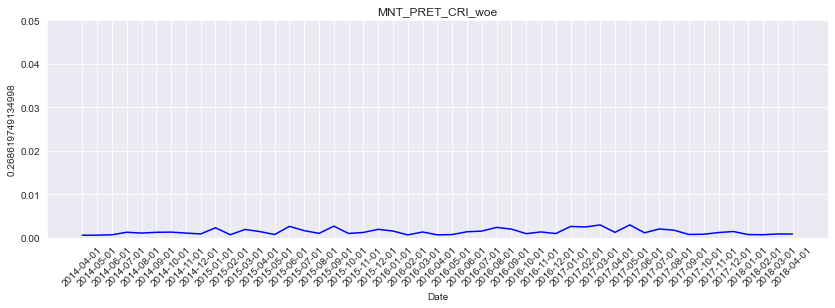

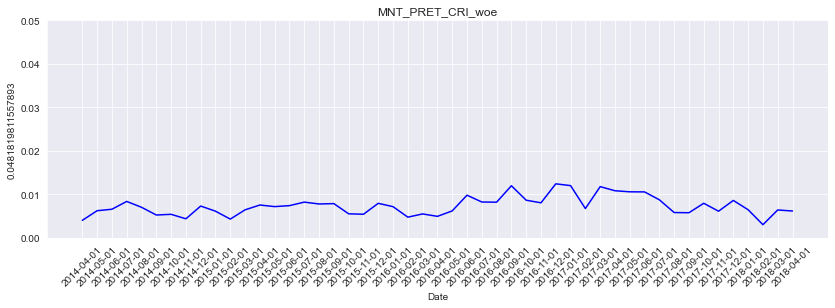

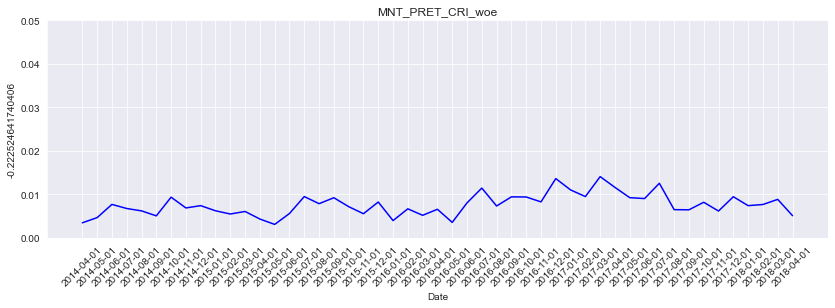

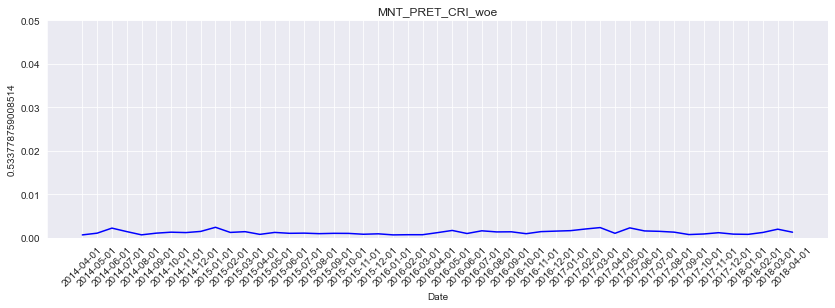

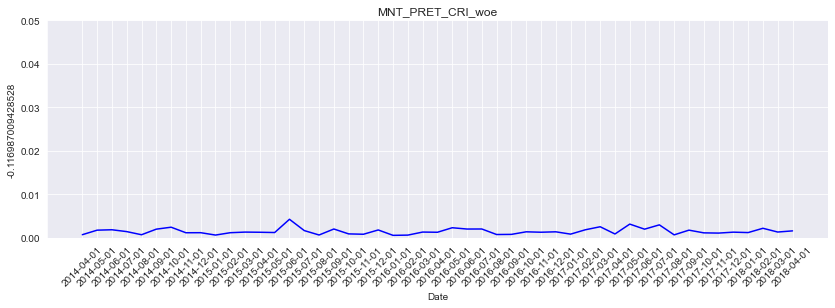

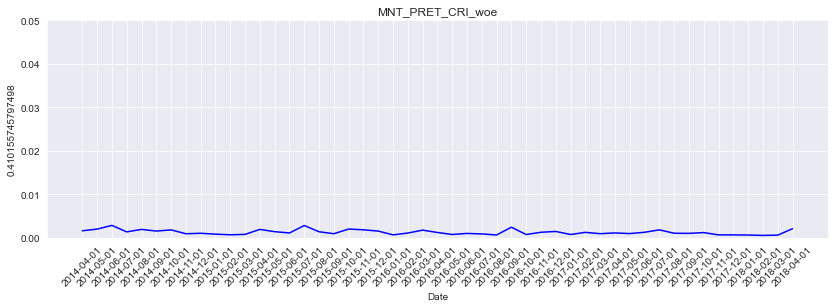

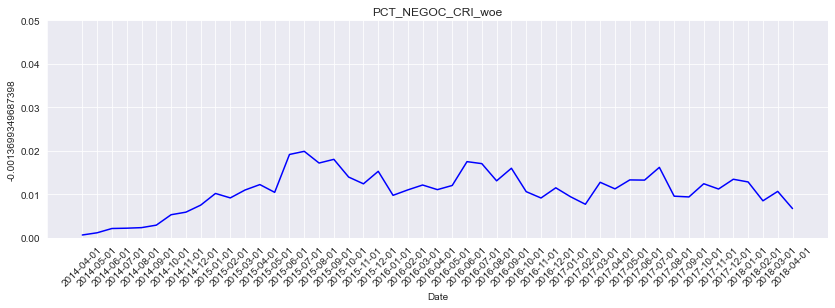

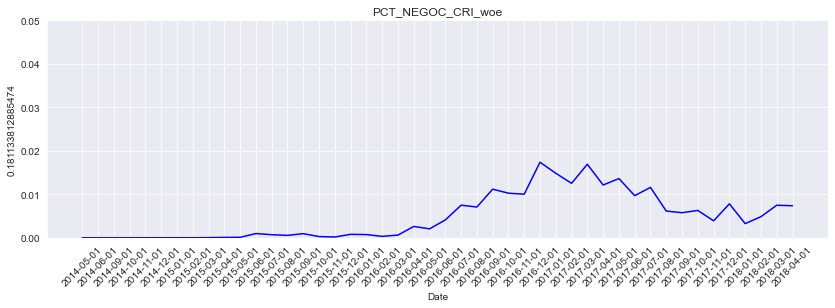

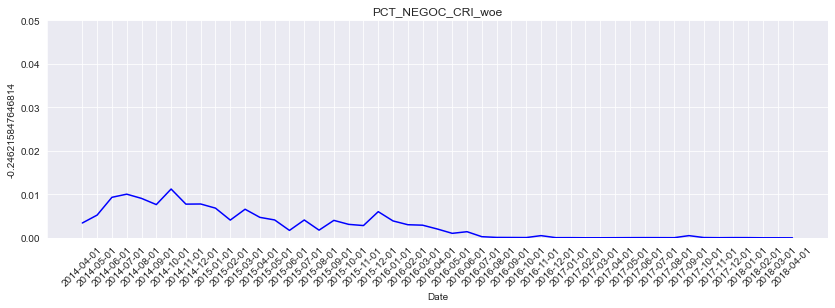

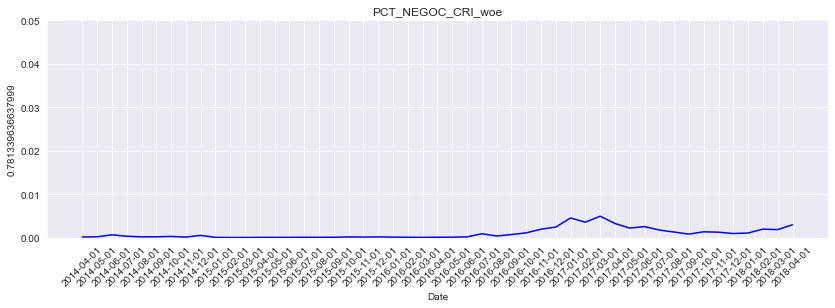

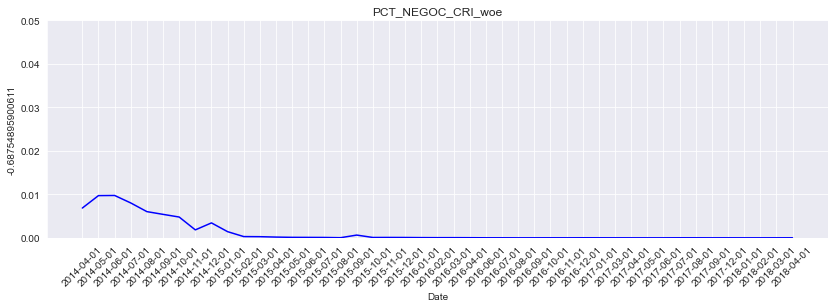

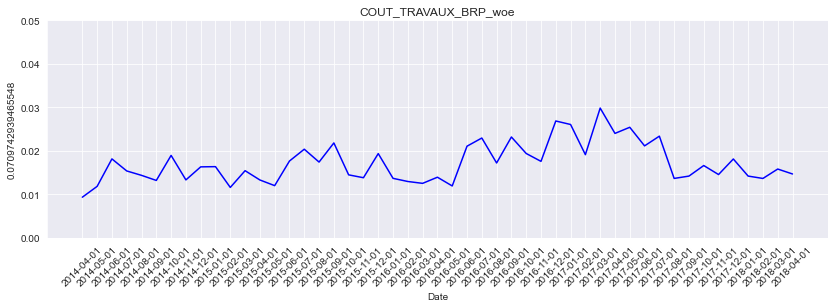

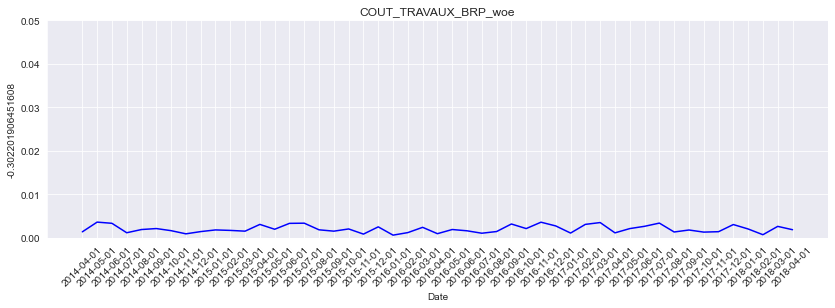

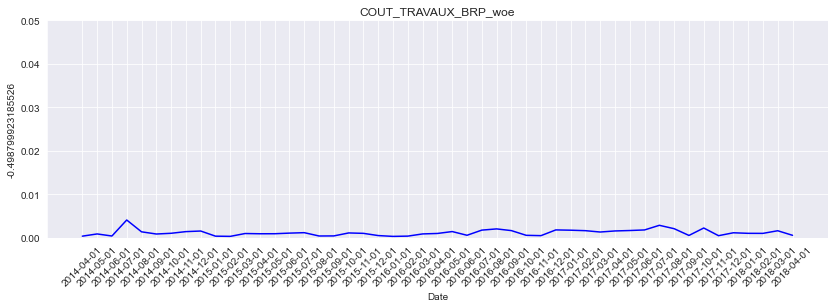

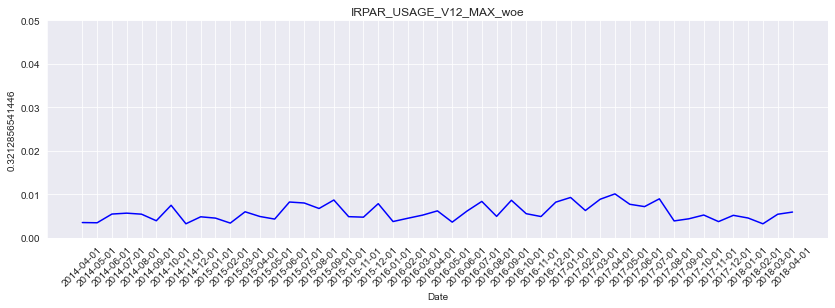

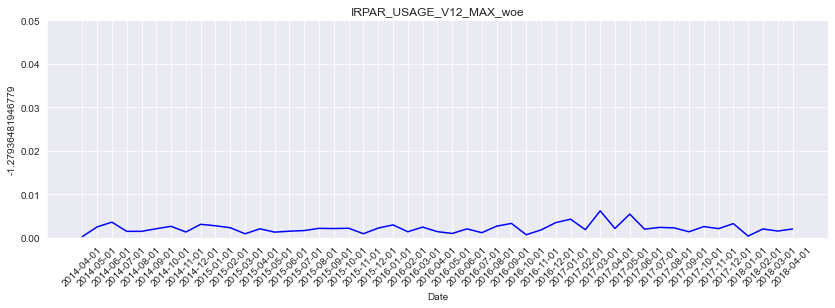

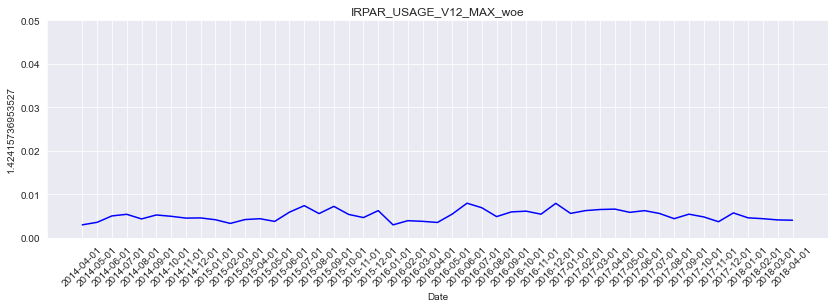

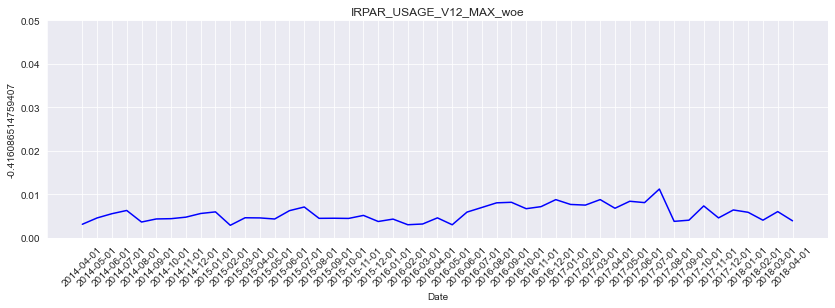

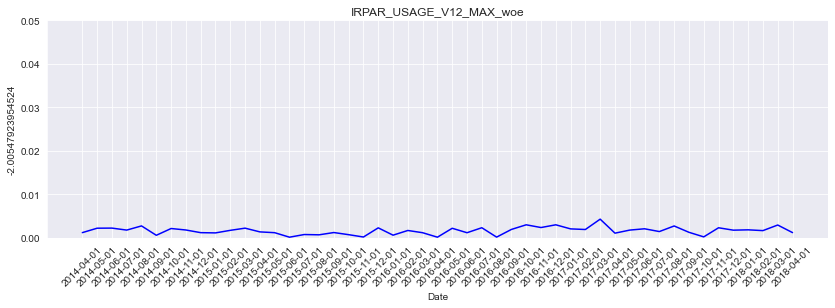

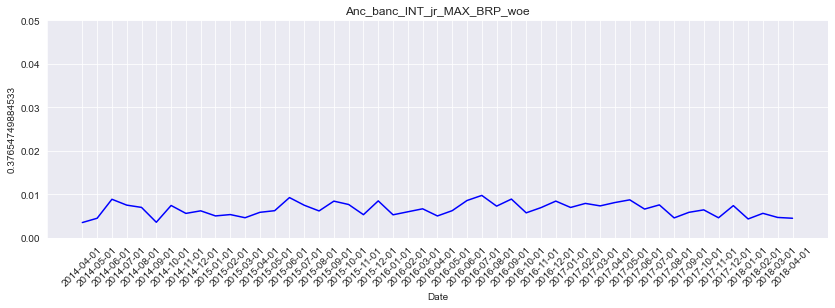

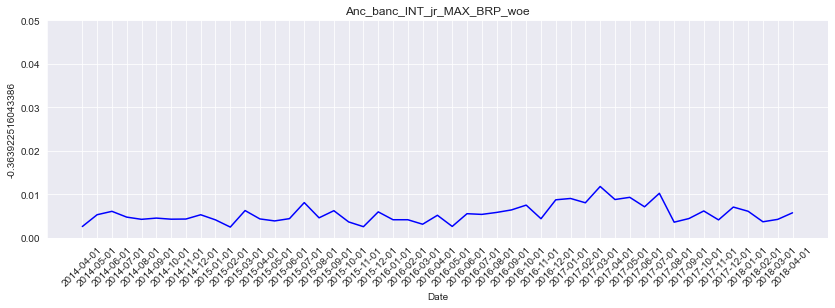

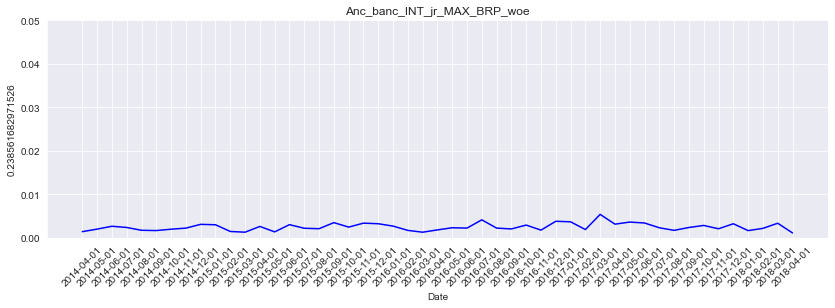

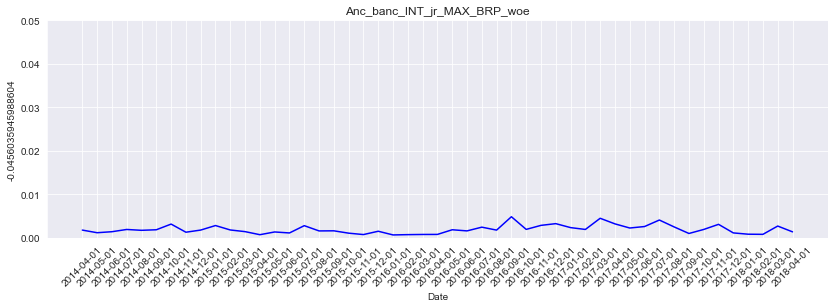

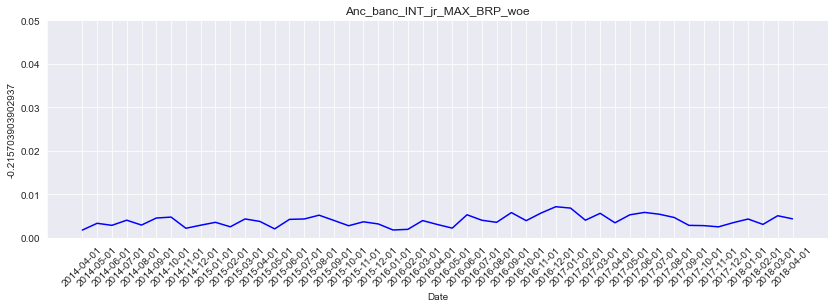

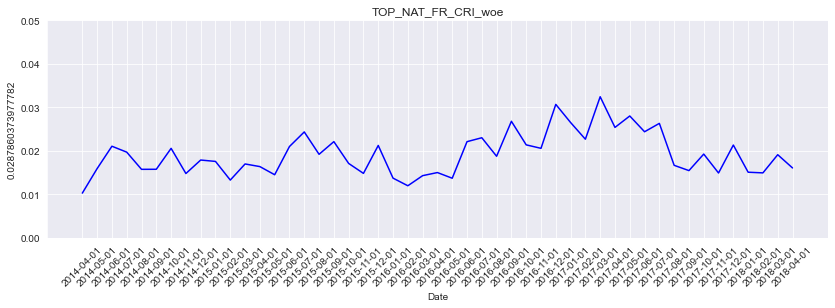

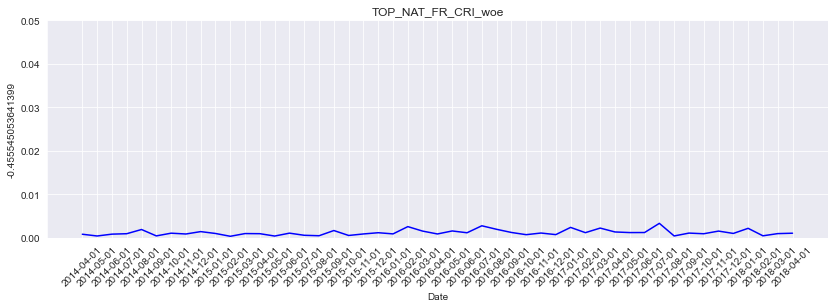

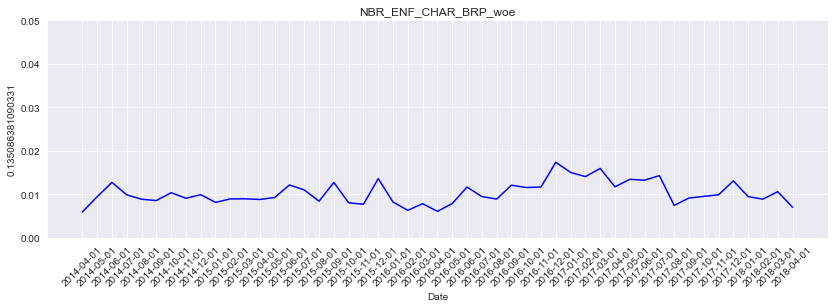

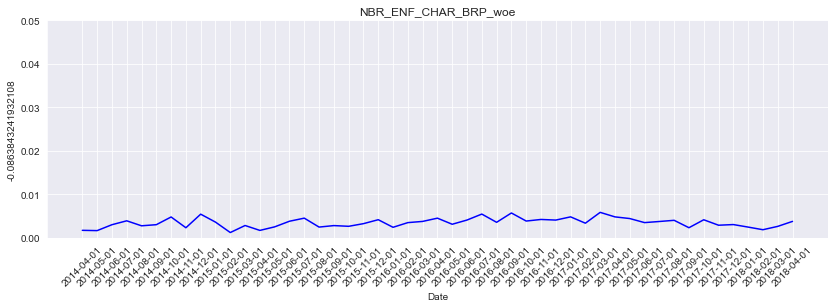

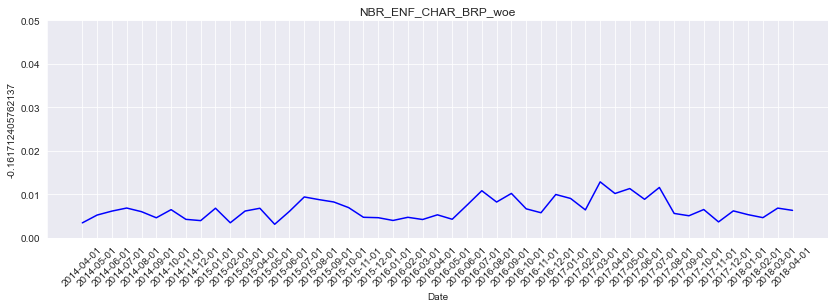

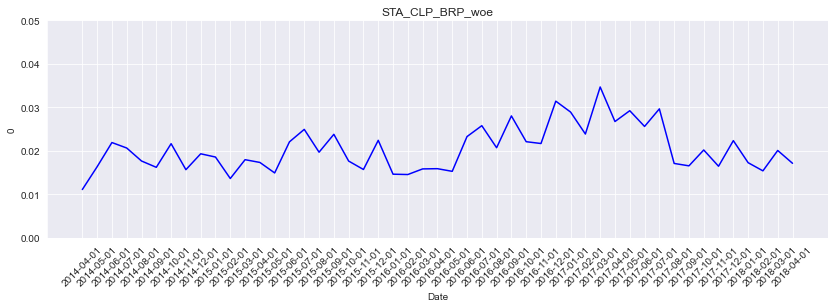

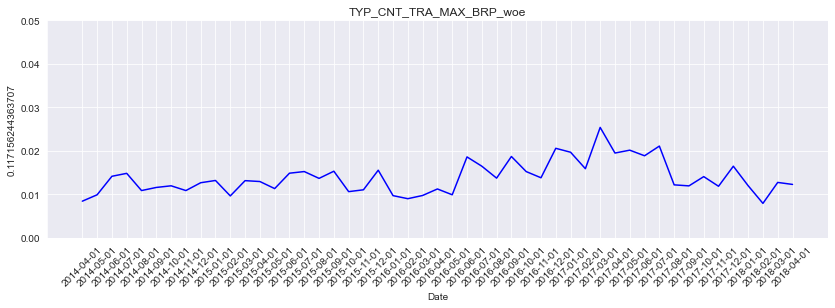

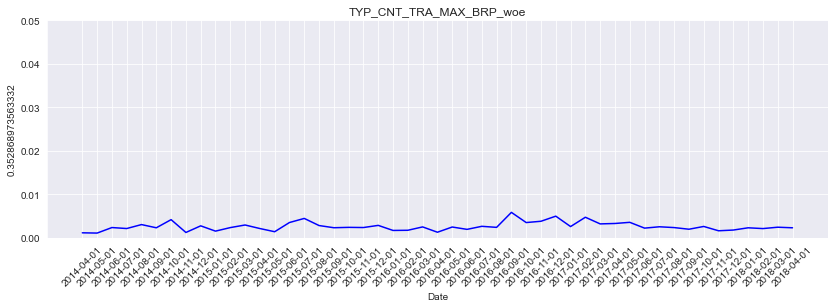

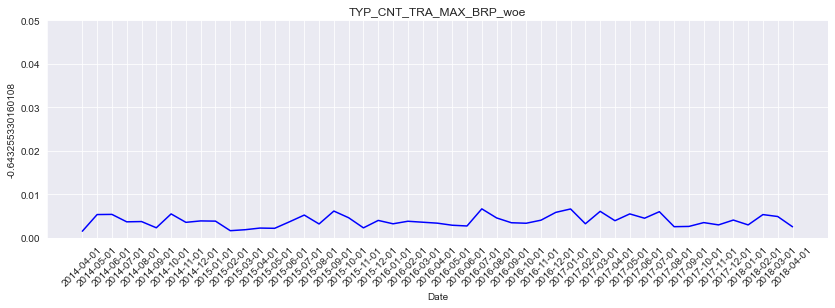

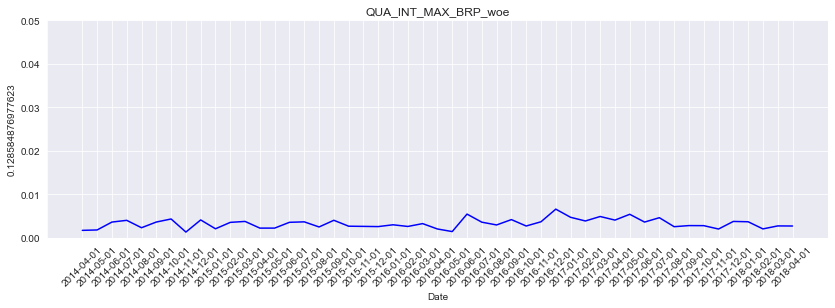

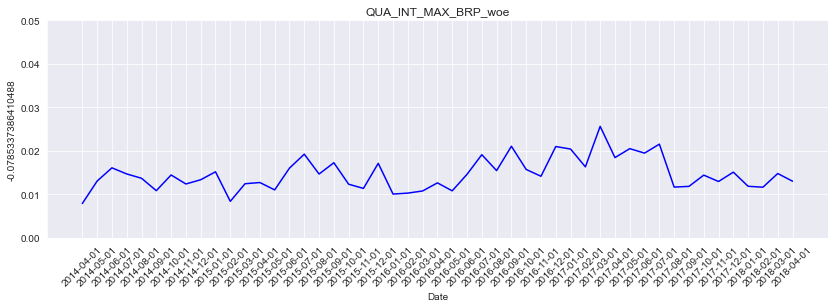

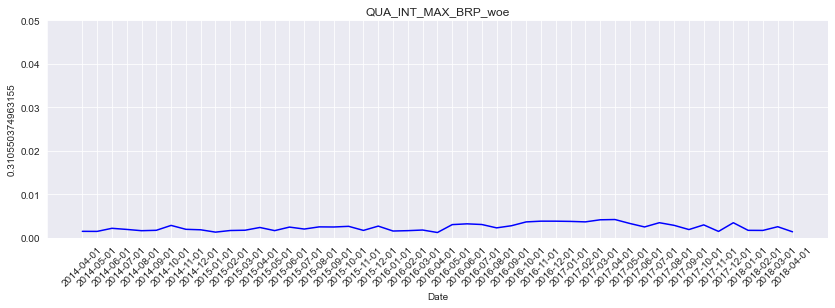

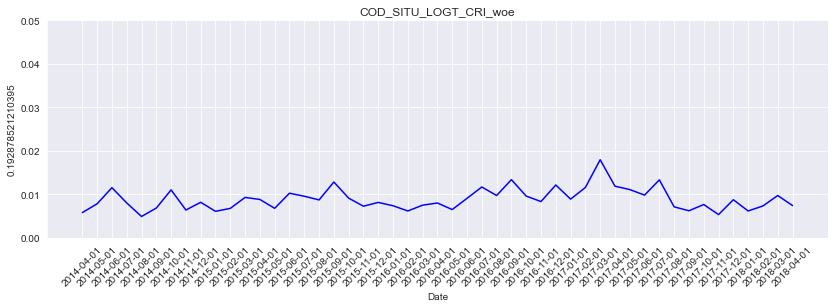

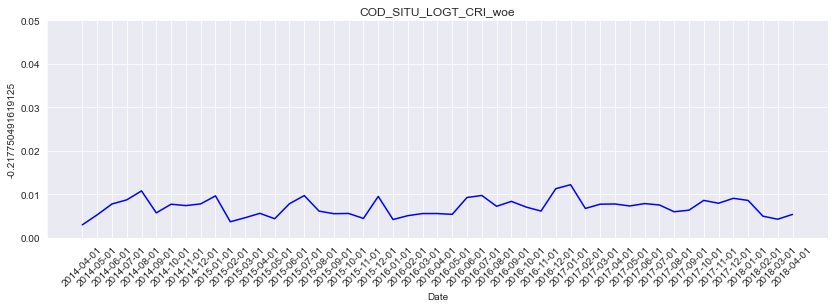

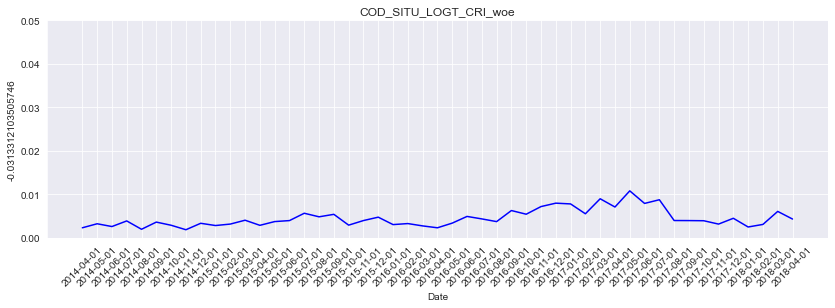

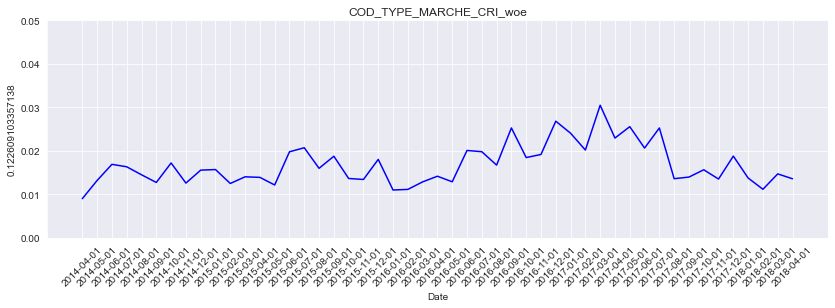

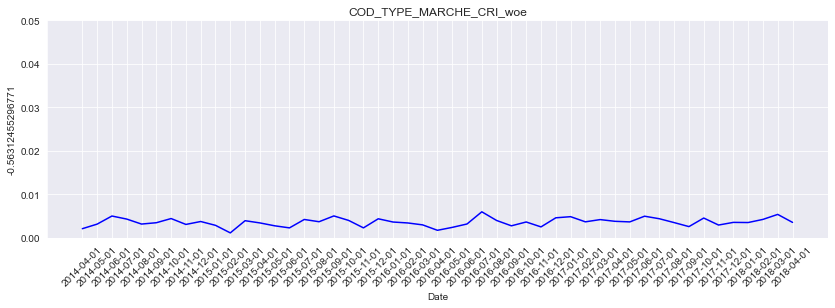

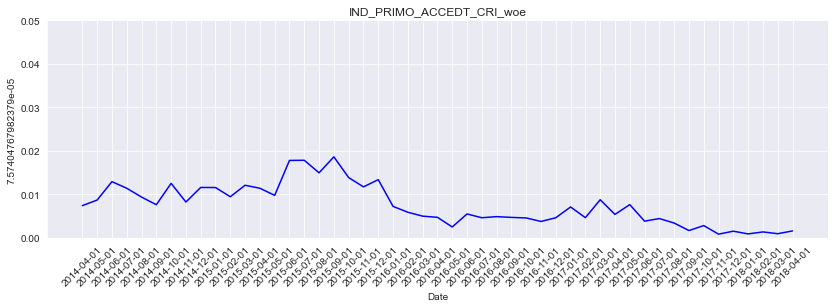

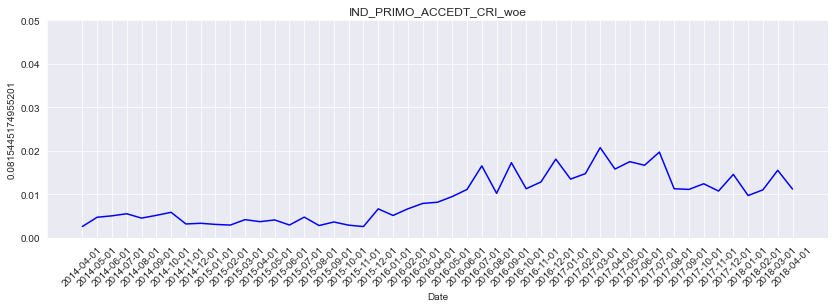

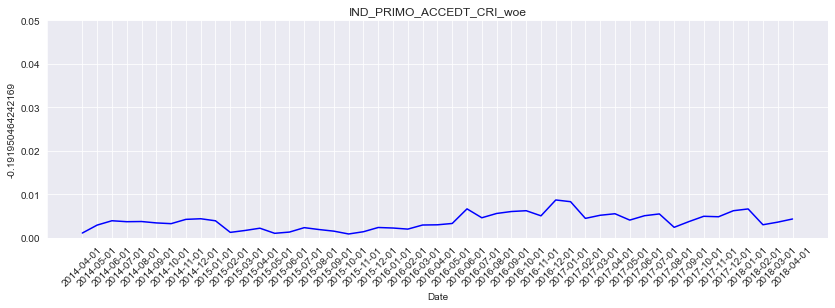

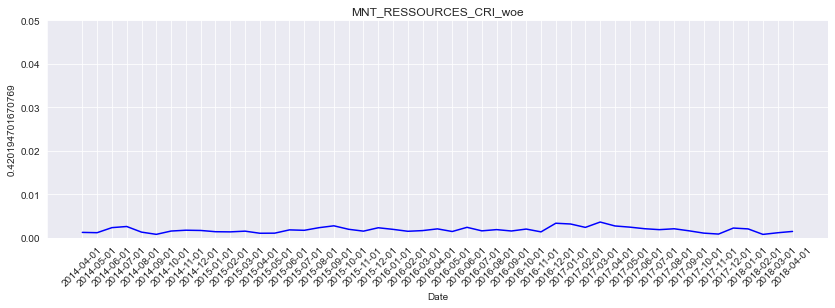

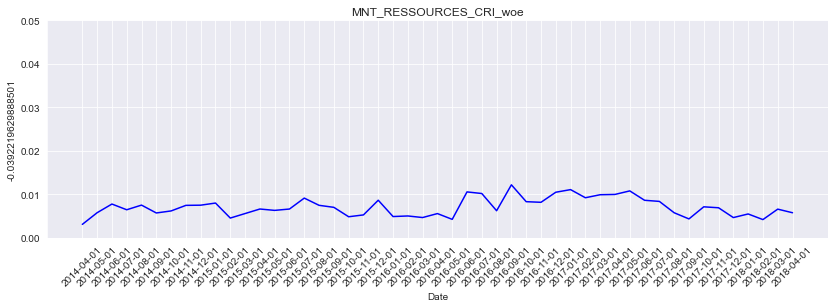

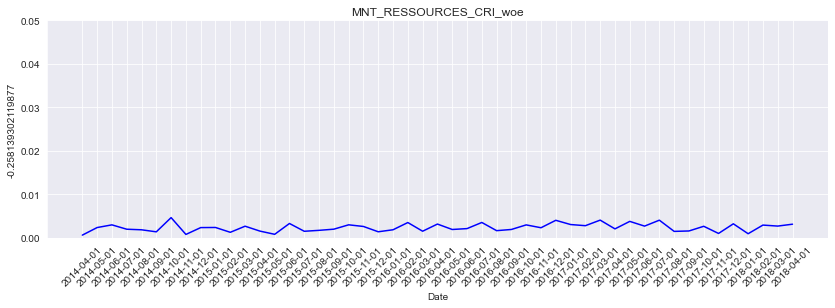

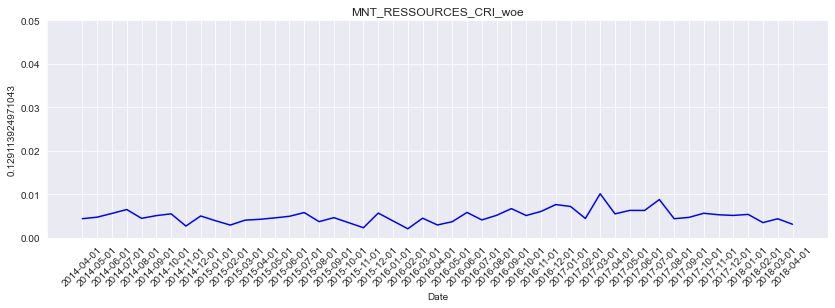

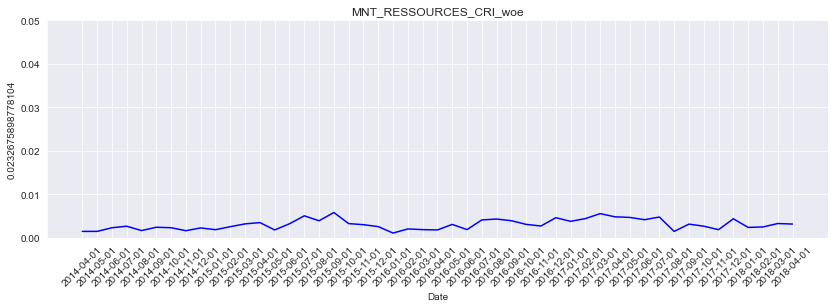

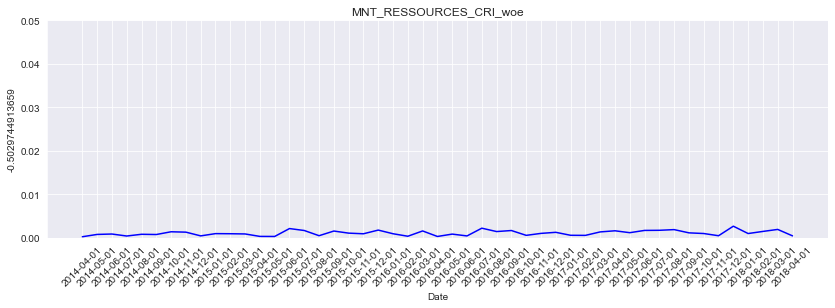

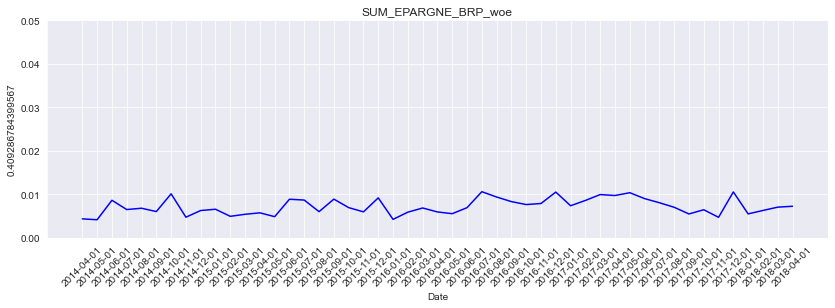

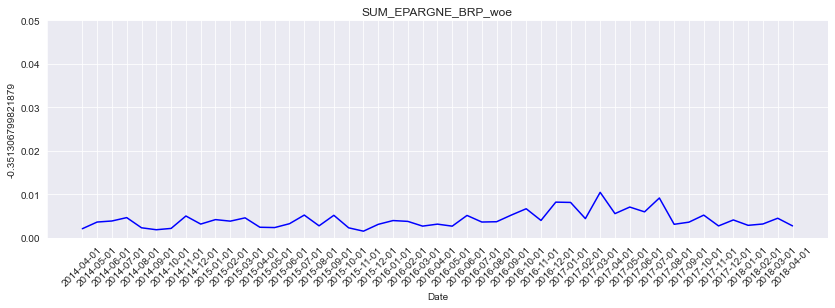

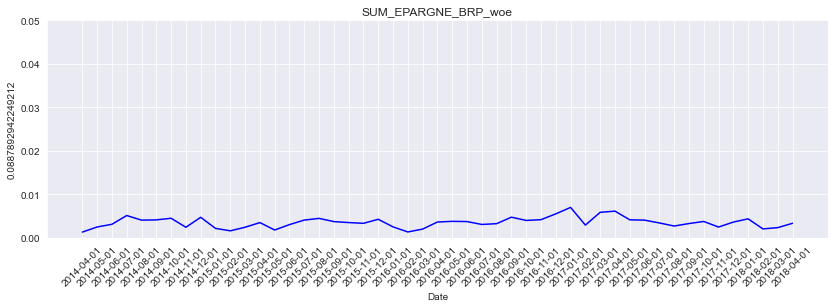

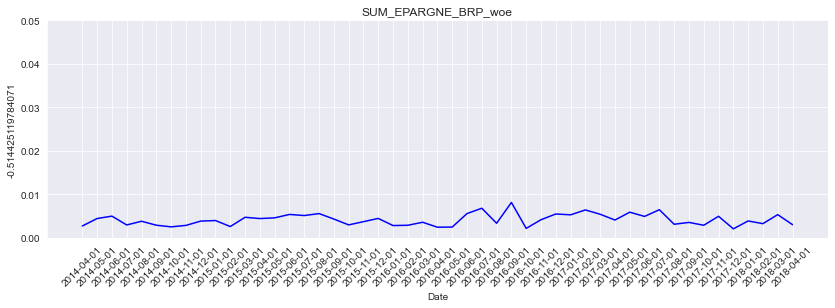

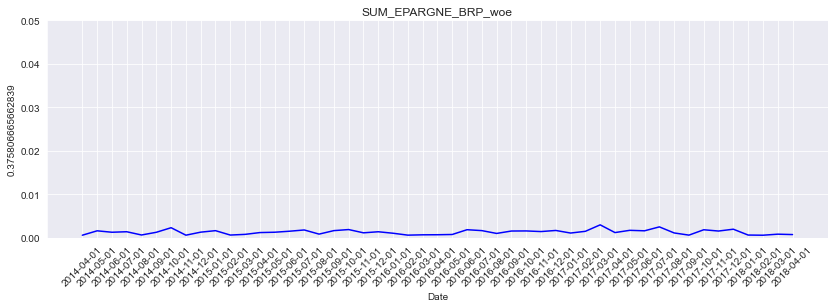

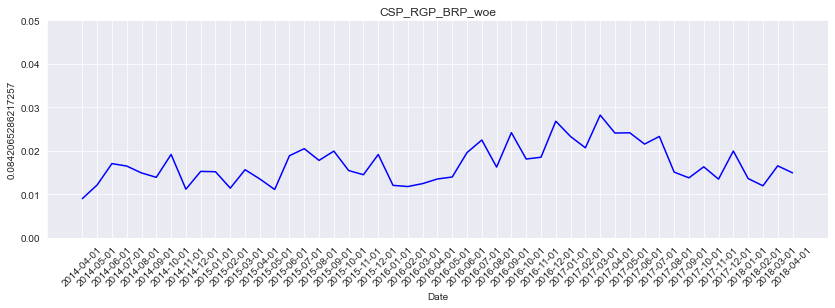

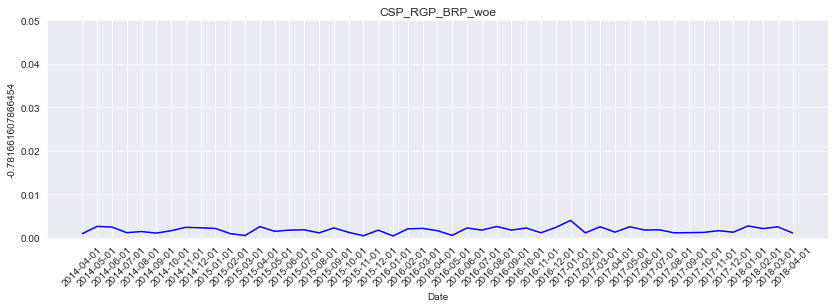

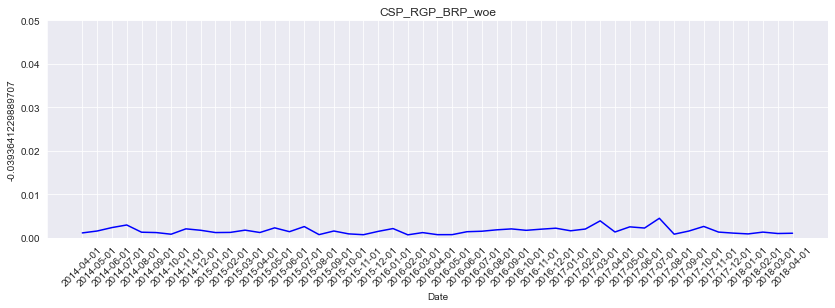

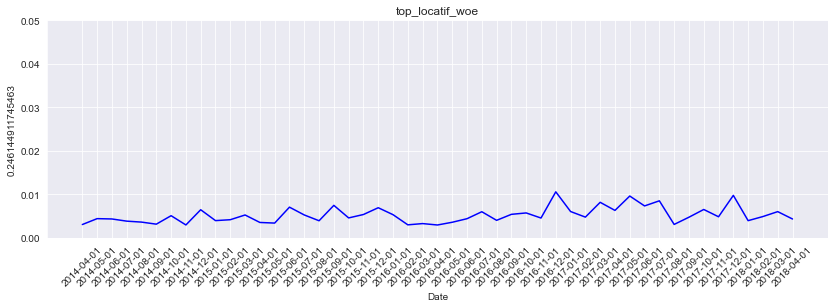

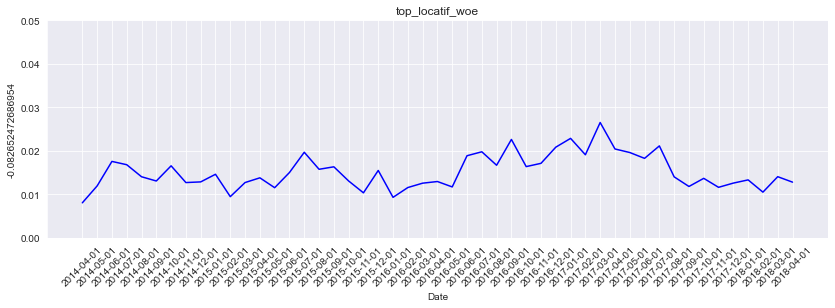

In [72]:
#Stabilité en volume des variables catégorielles
print ('\n' + 10*'-' + 'Stabilité mensuelle en volume des classes' + 10*'-' + '\n')
for col in base_up_woe.columns:
    if col not in ['defaut_36mois', 'date_debloc_avec_crd']:
        for group in base_up_woe[col].unique():
            volume = base_up_woe[base_up_woe[col]==group].groupby(['date_debloc_avec_crd']).count()/base_up_woe.shape[0]
            plt.figure(figsize = (14, 4))
            plt.plot(volume[col], color='b')
            plt.title(col)
            plt.xlabel("Date")
            plt.xticks(rotation = 45)
            plt.ylim(0.000, 0.05)
            plt.ylabel(group)
            plt.show()


----------Stabilité mensuelle en risque des classes----------



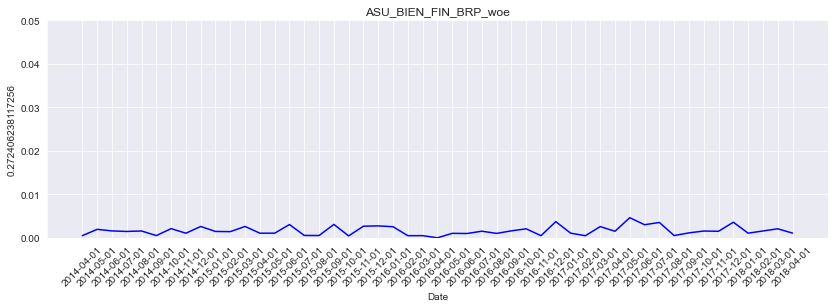

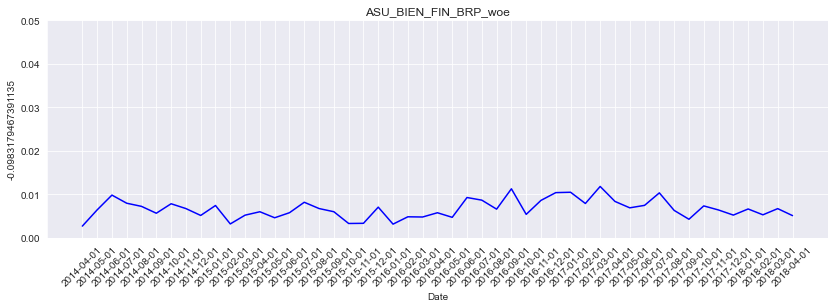

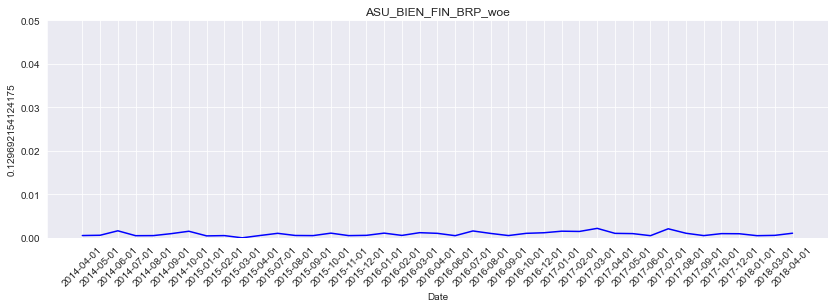

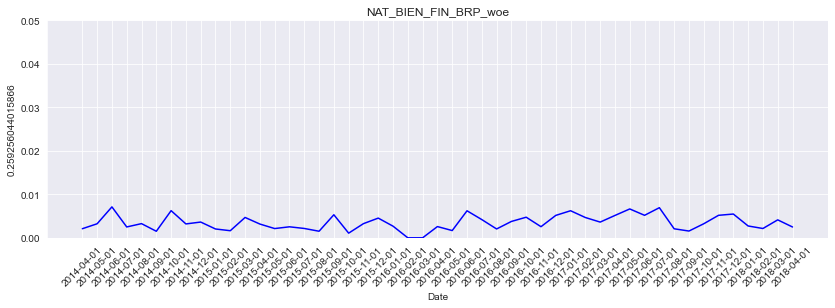

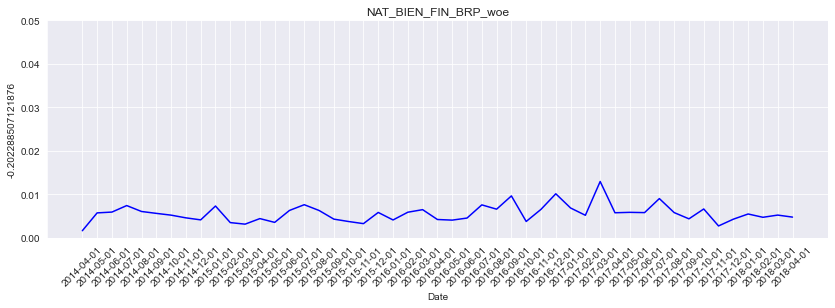

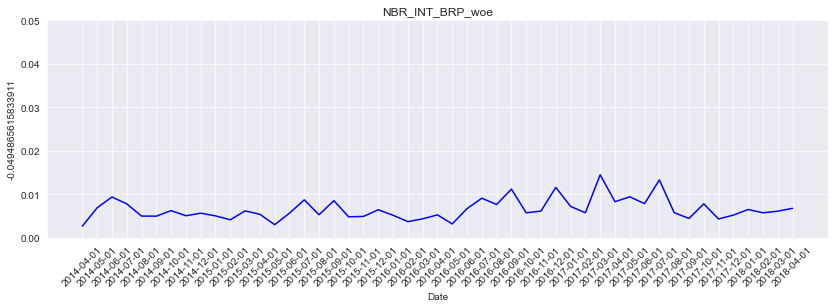

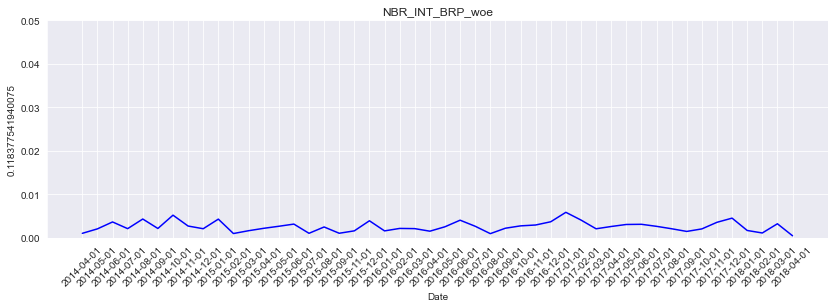

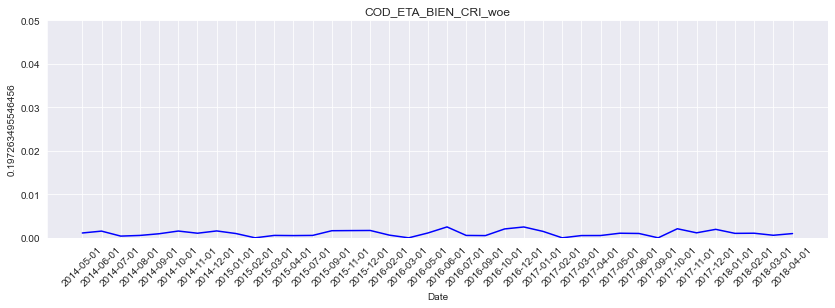

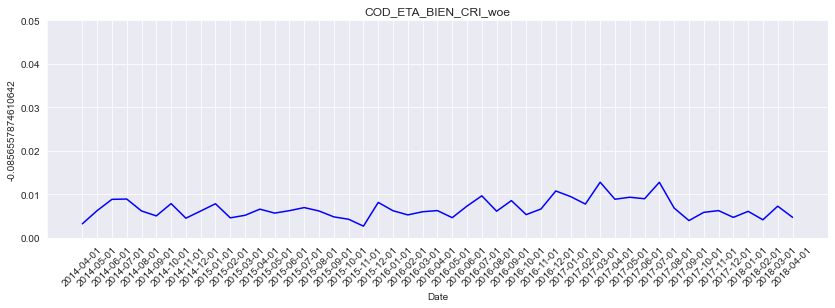

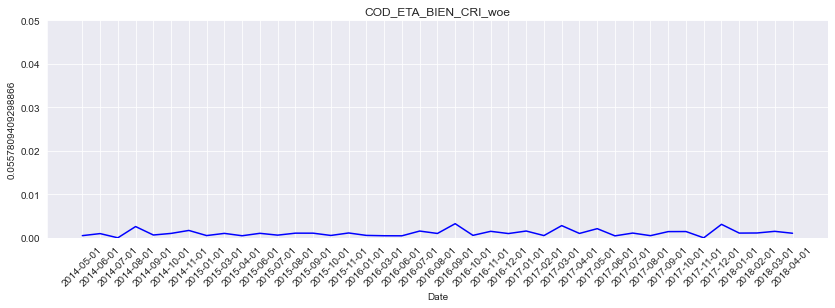

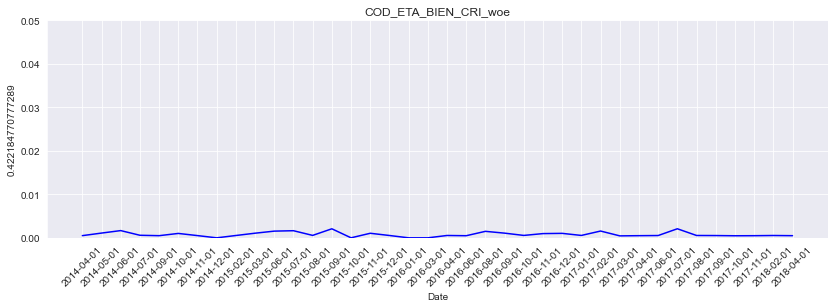

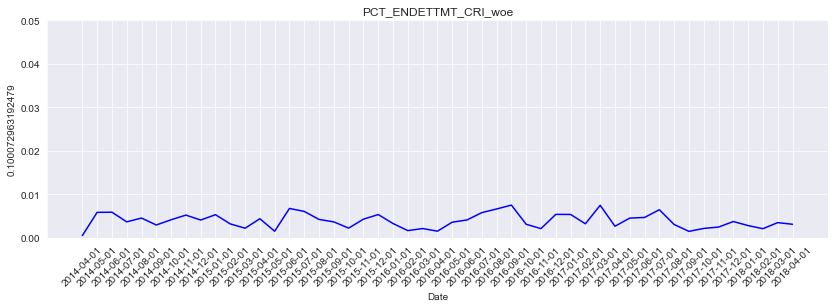

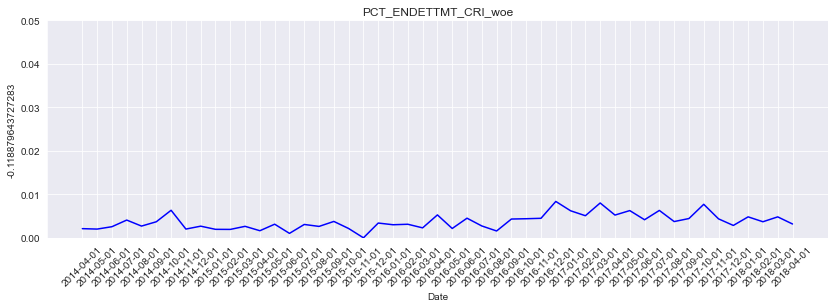

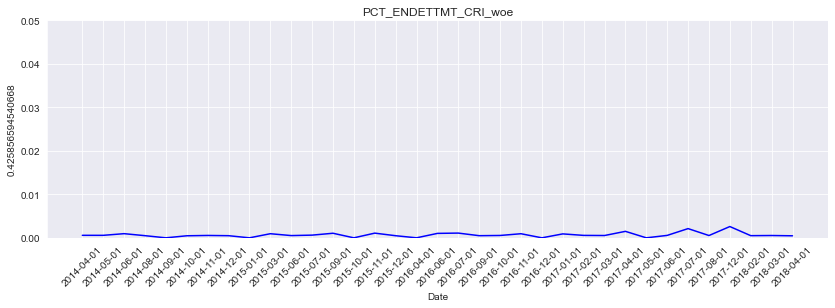

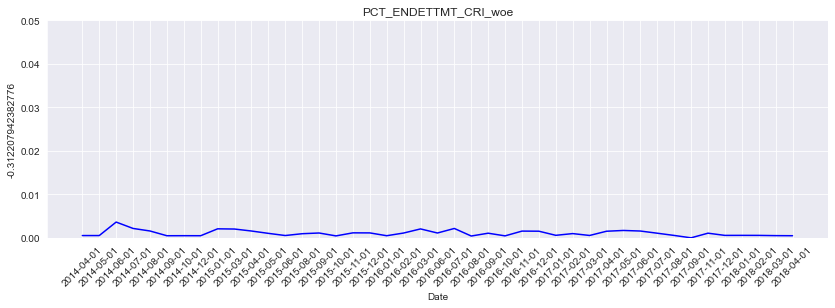

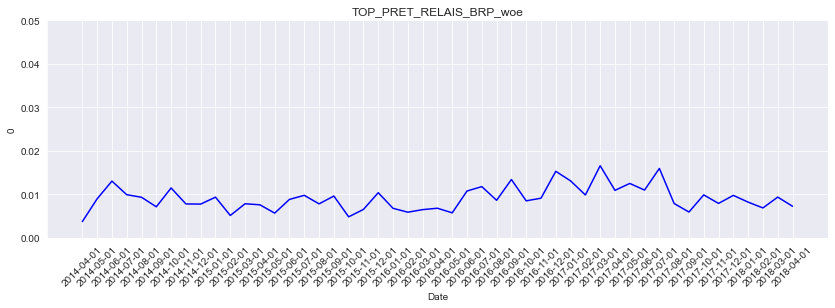

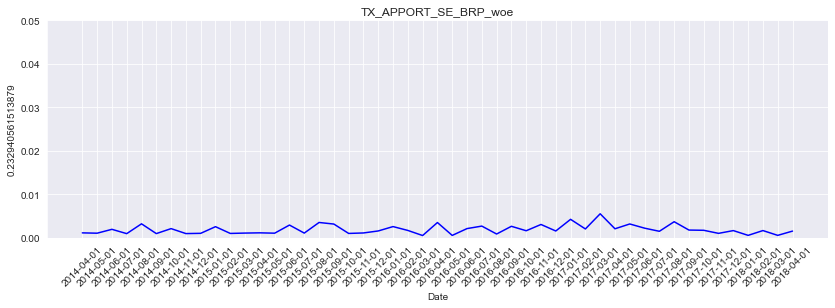

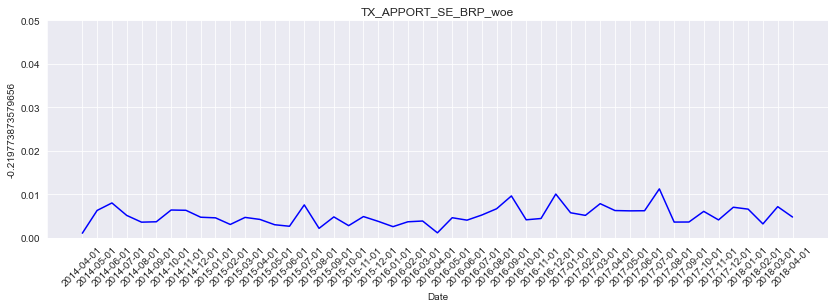

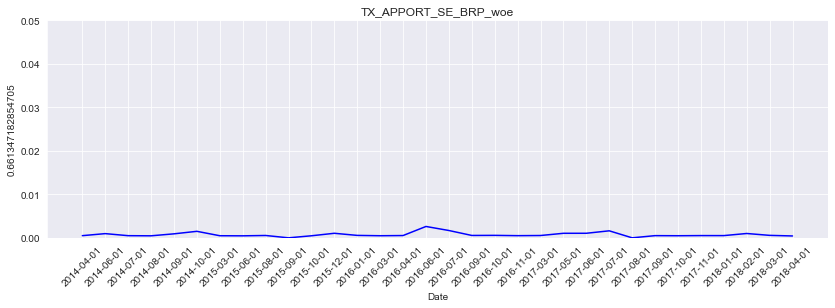

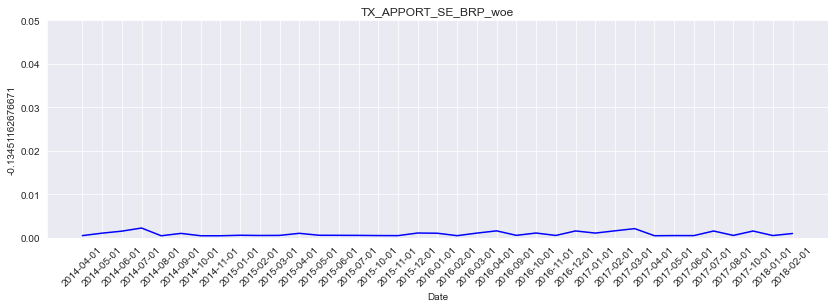

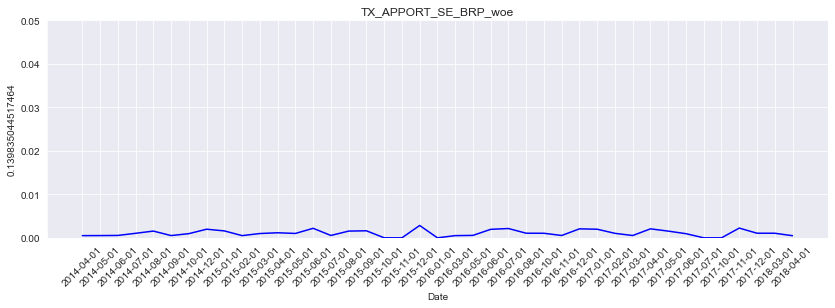

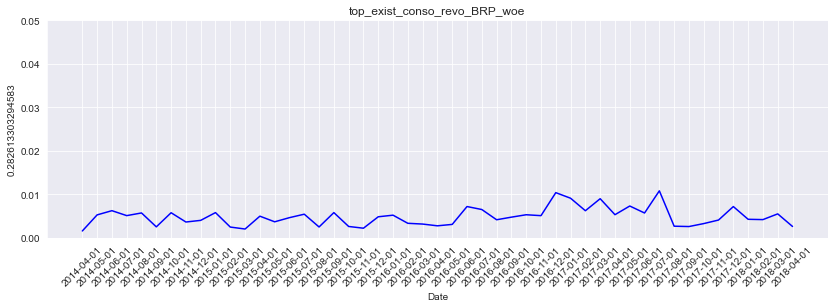

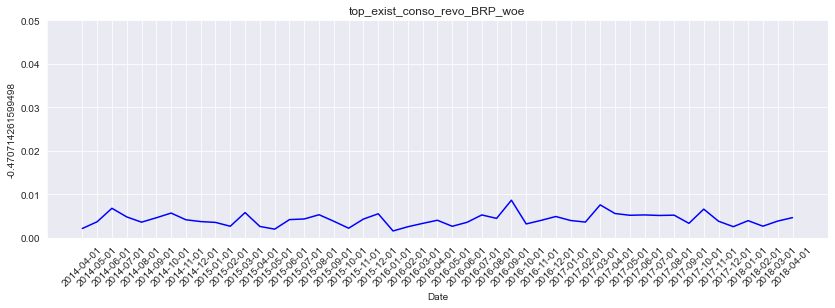

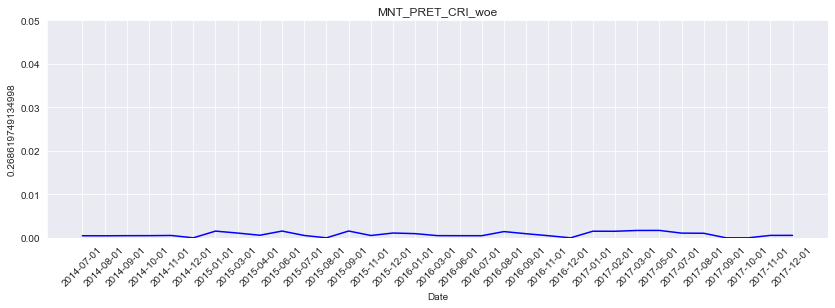

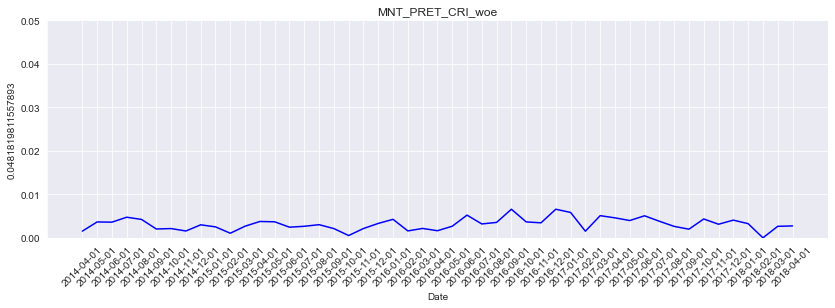

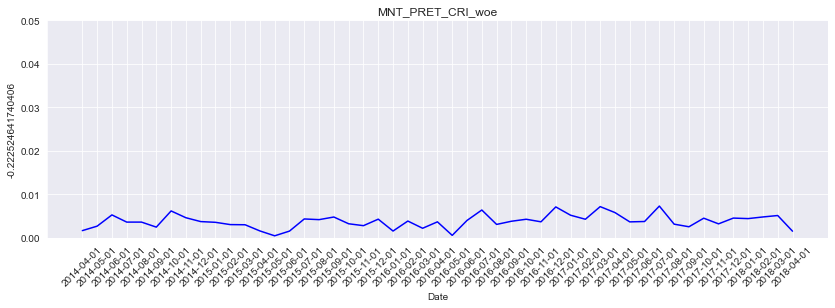

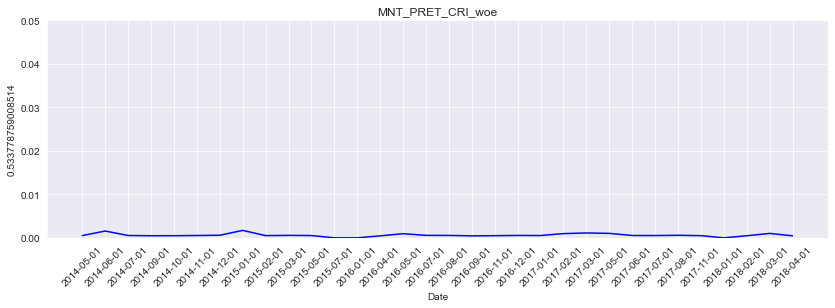

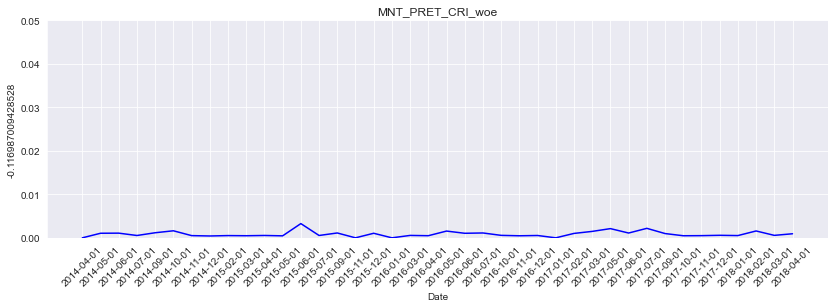

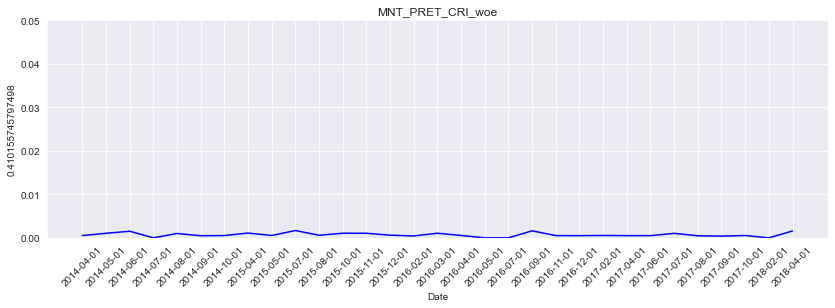

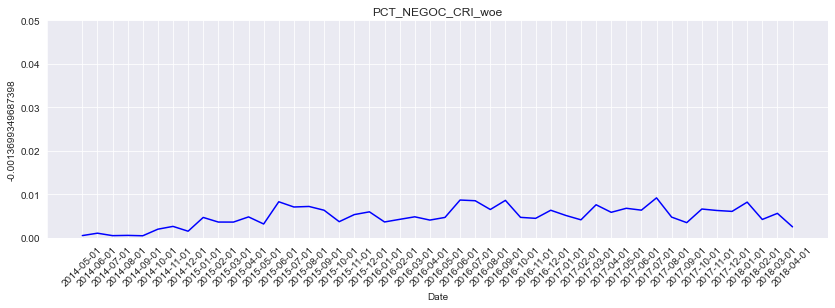

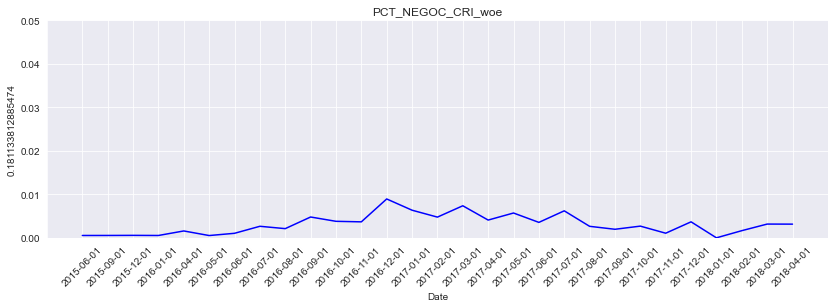

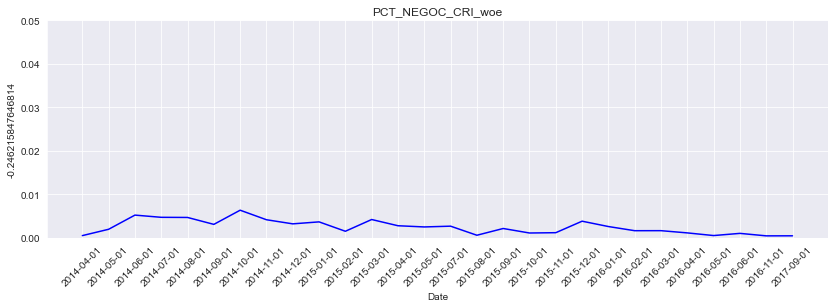

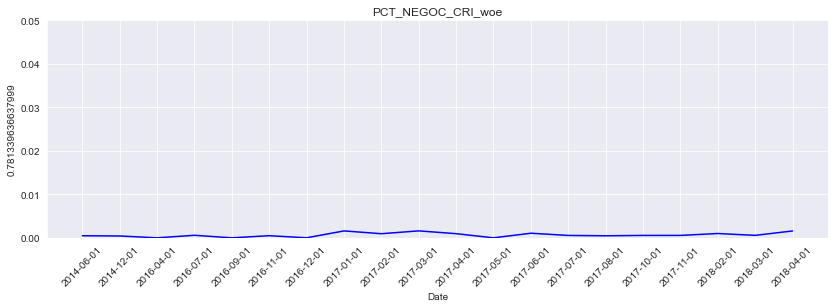

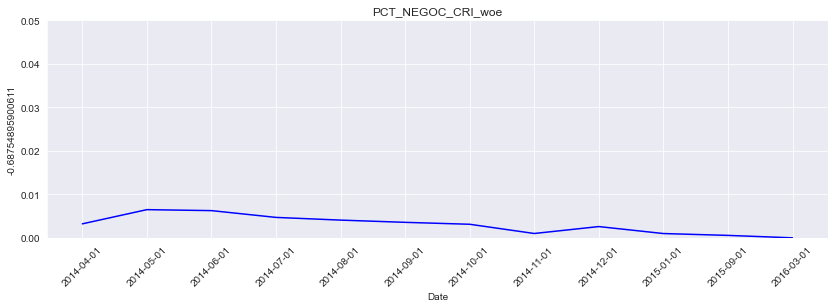

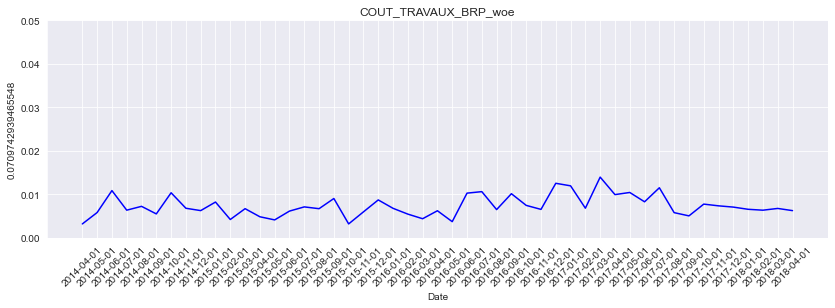

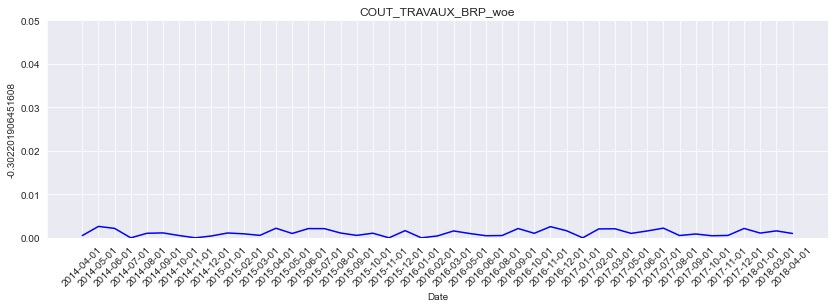

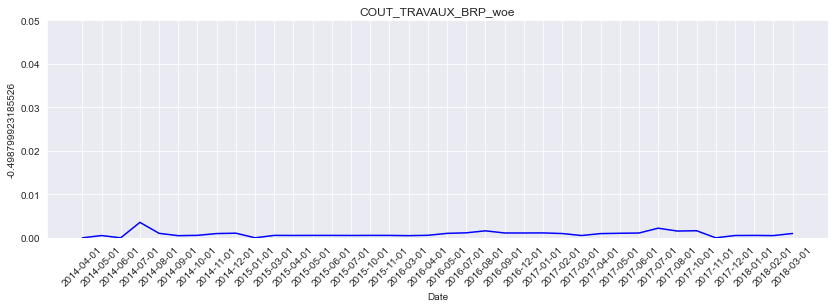

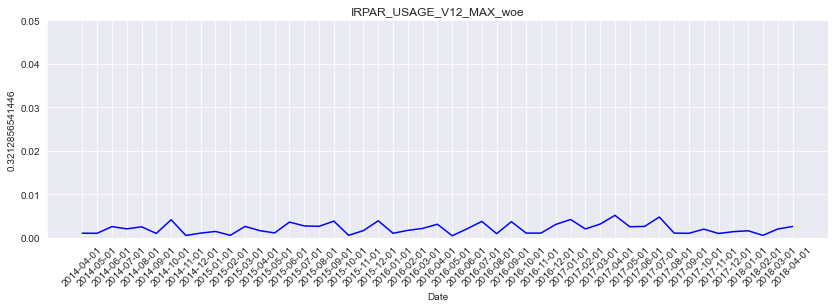

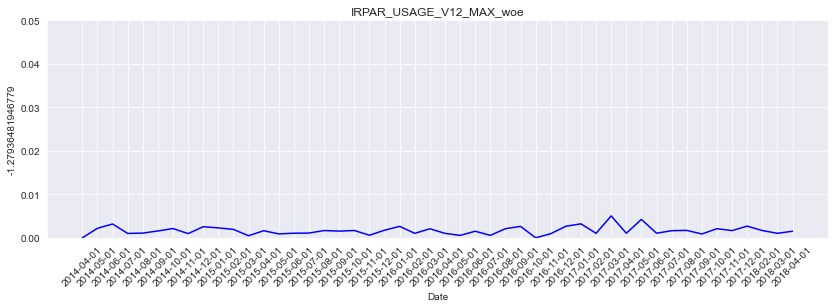

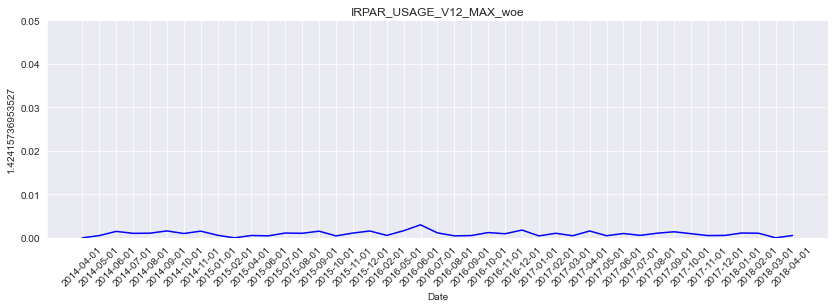

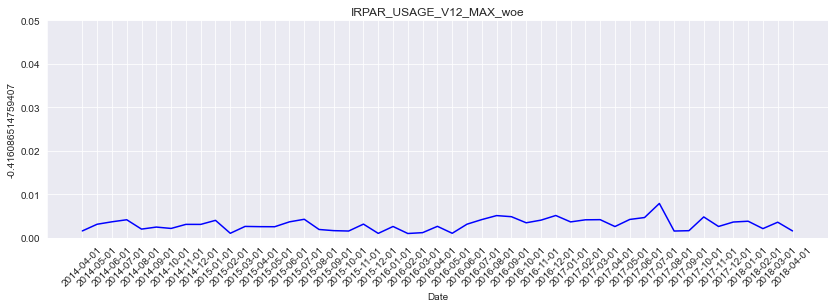

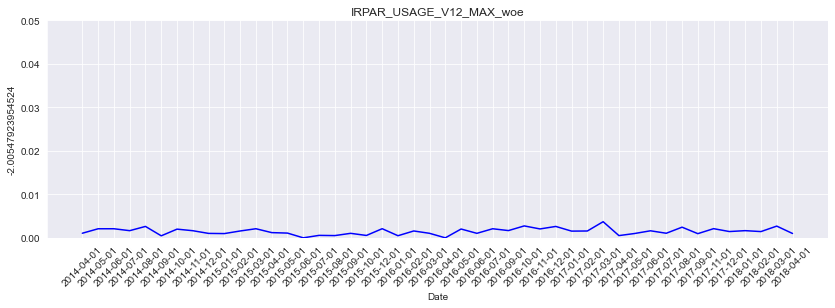

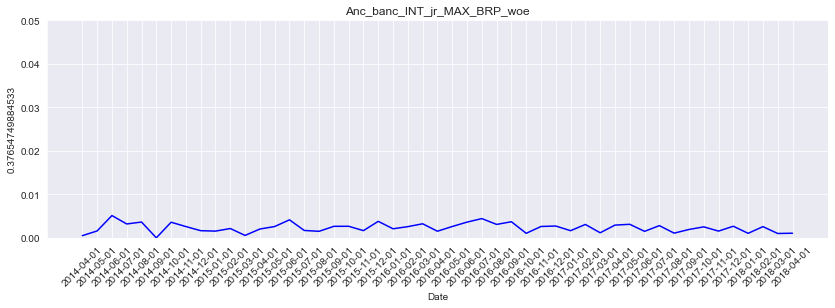

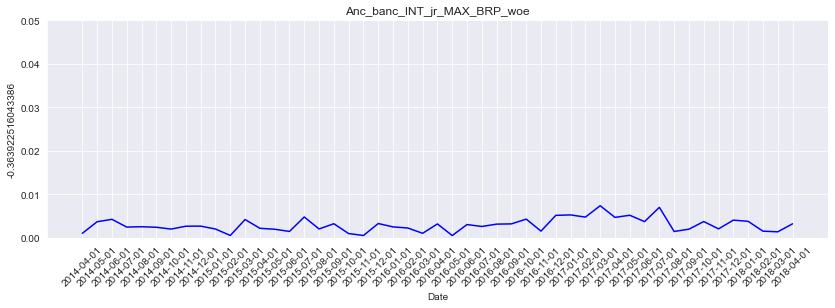

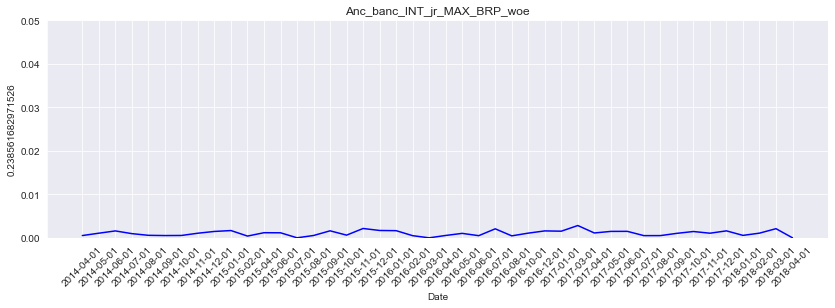

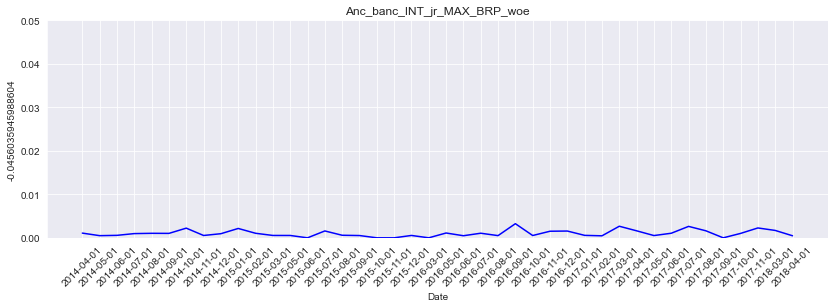

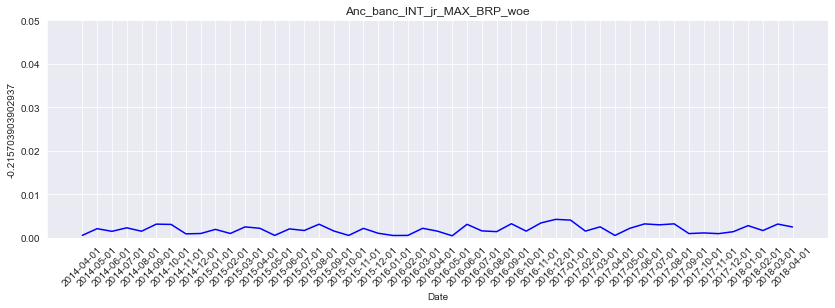

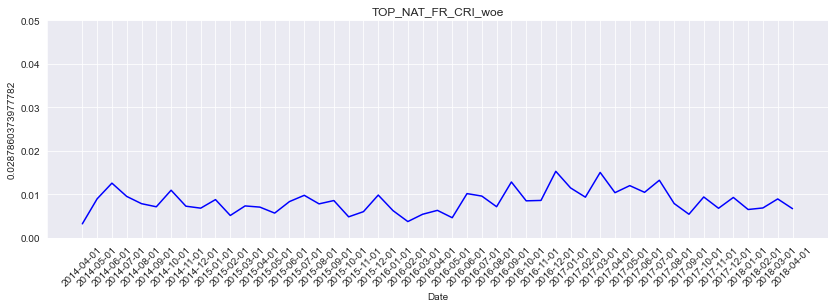

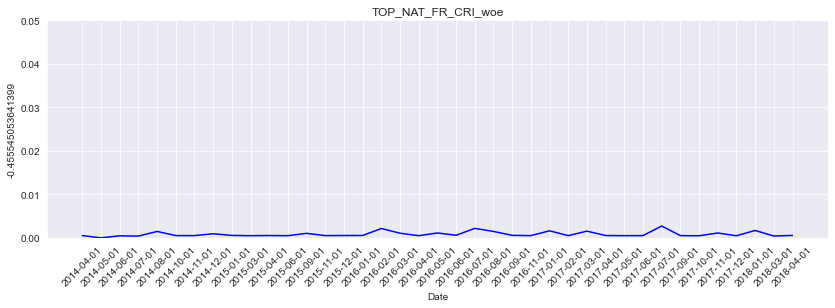

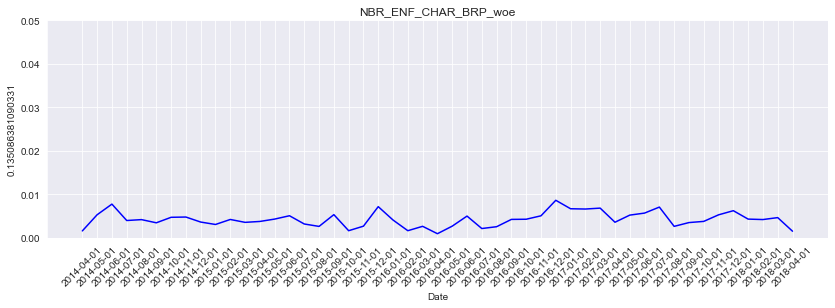

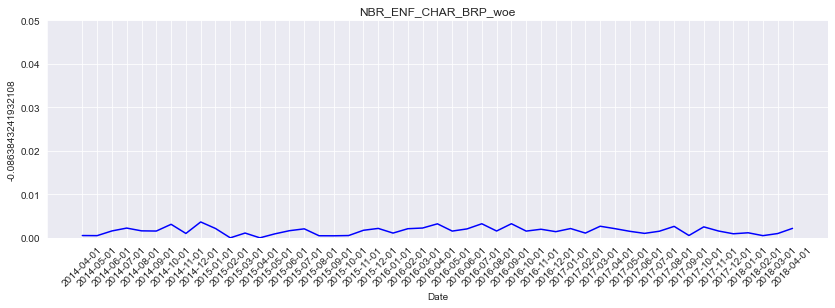

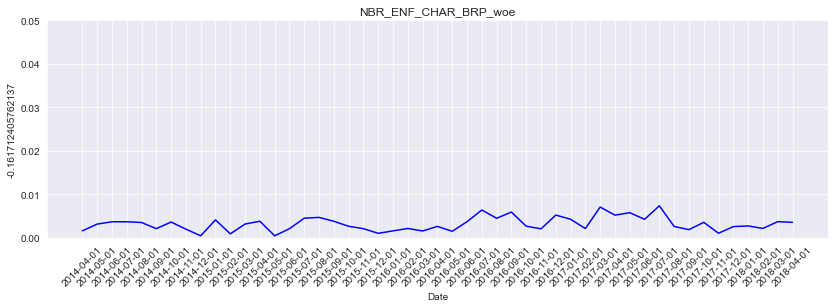

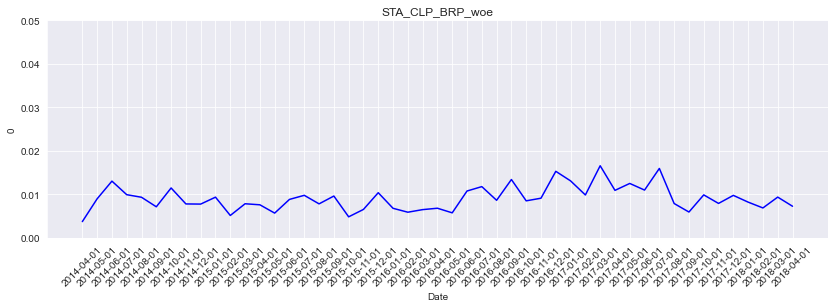

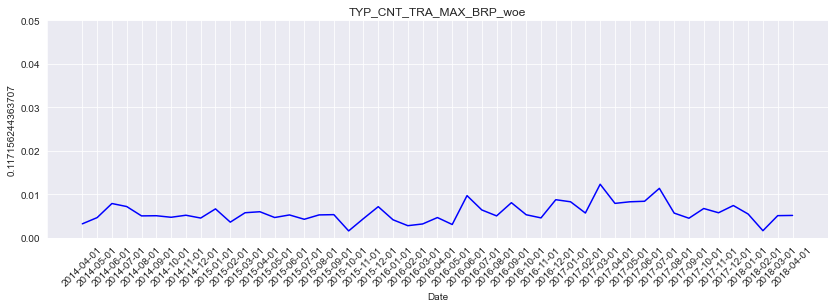

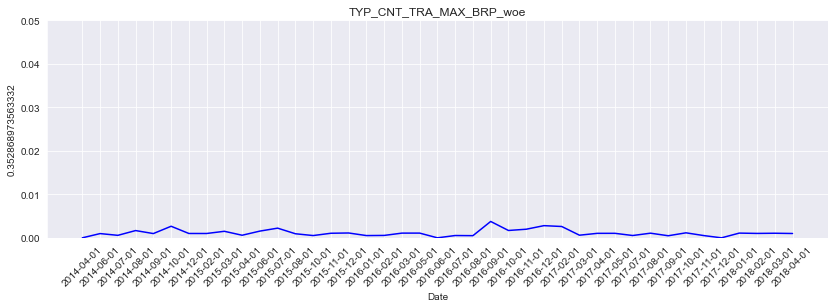

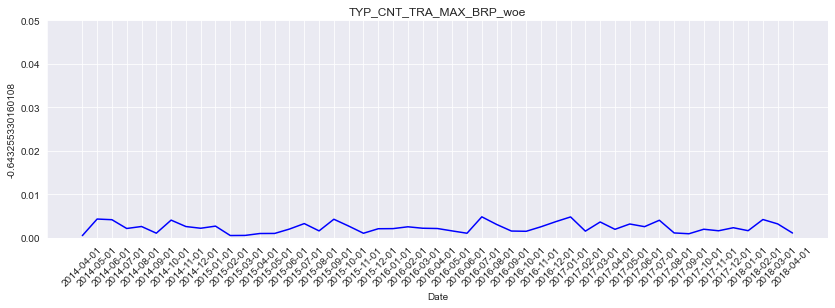

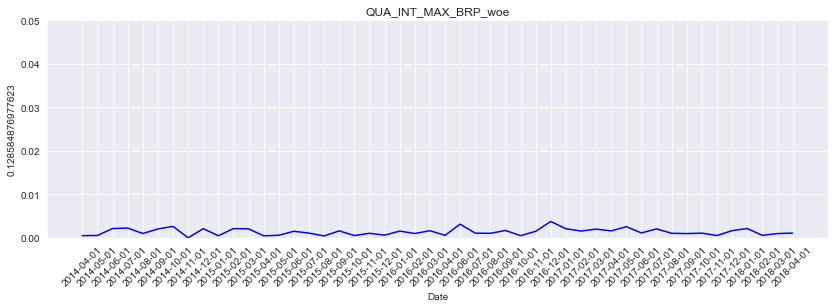

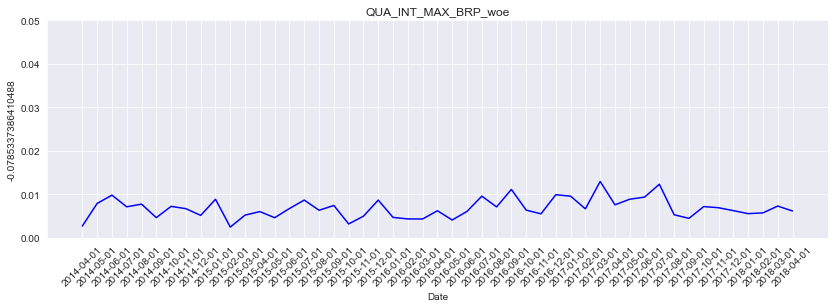

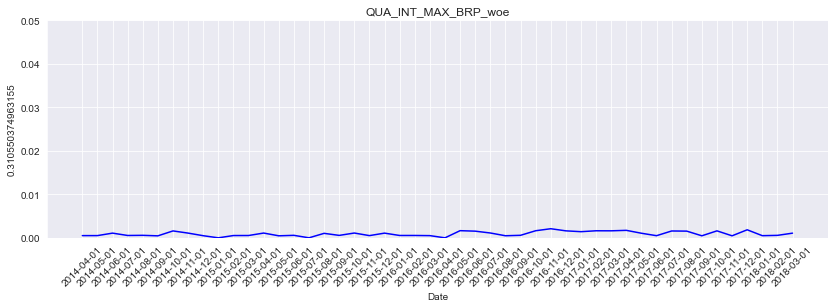

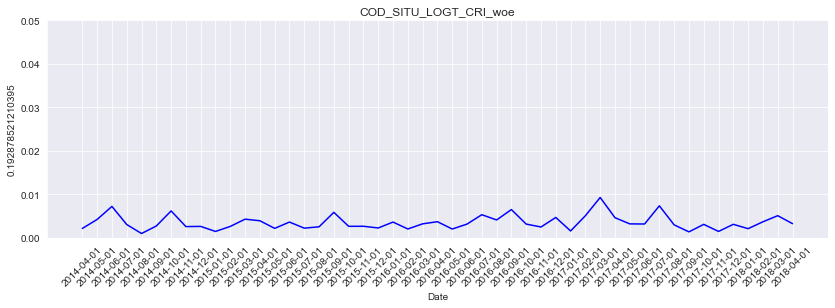

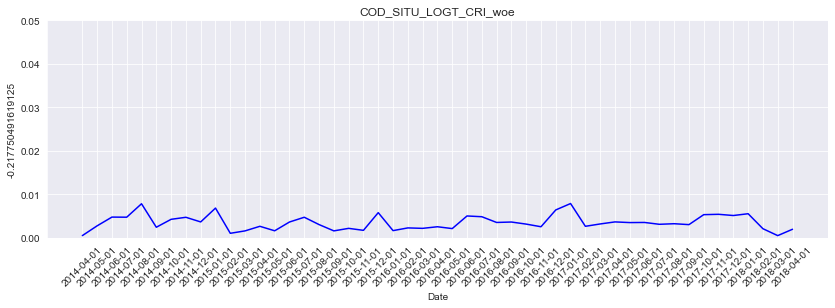

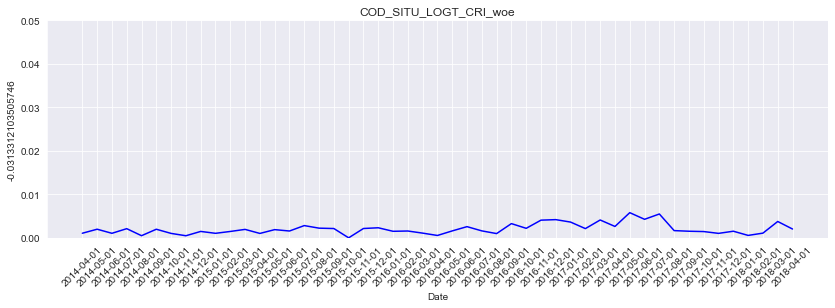

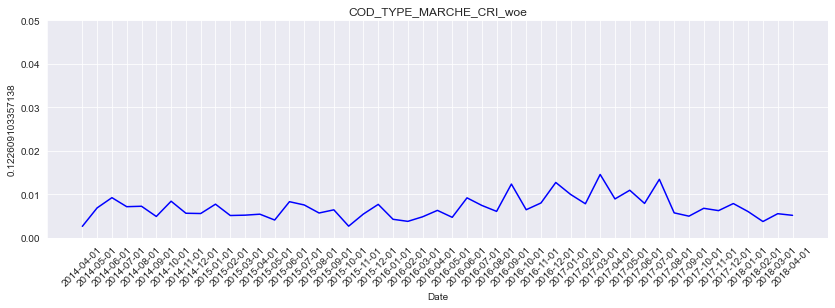

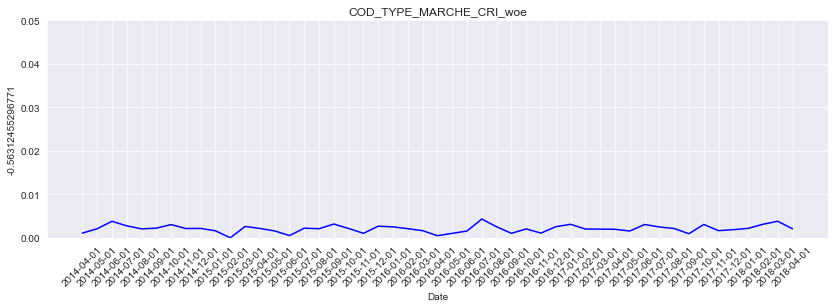

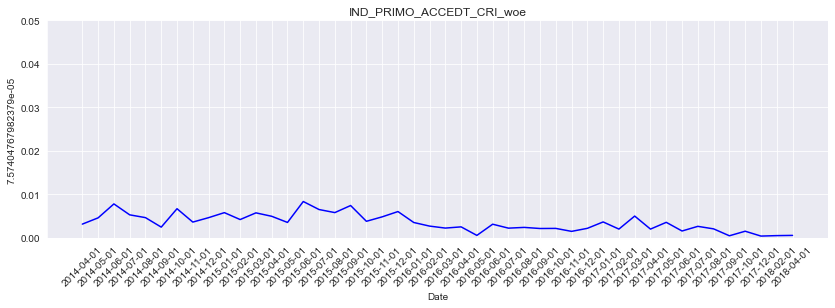

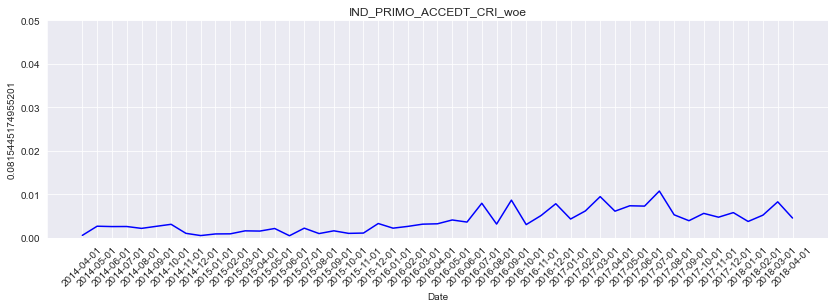

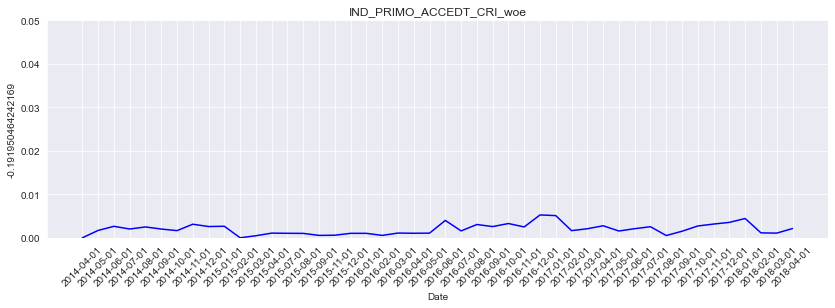

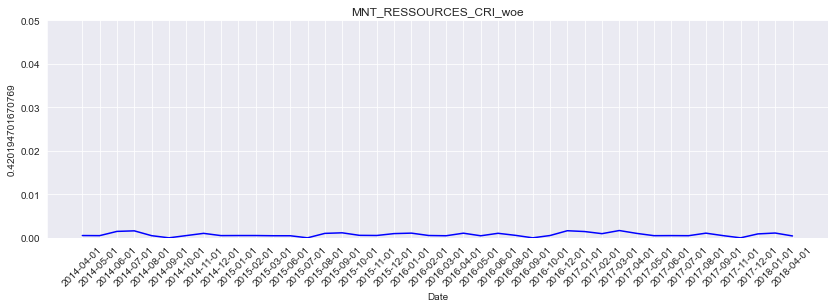

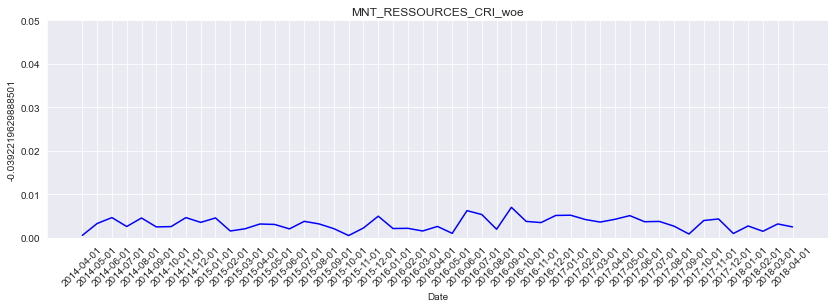

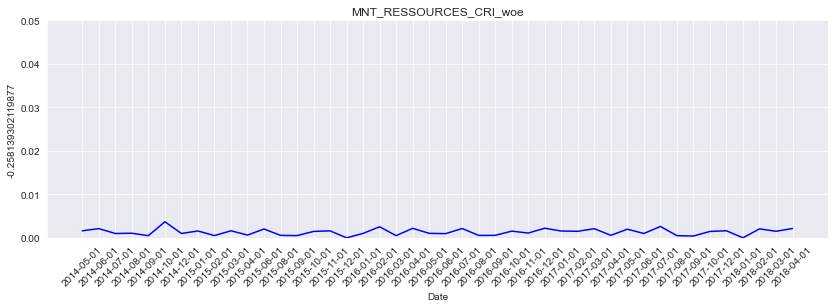

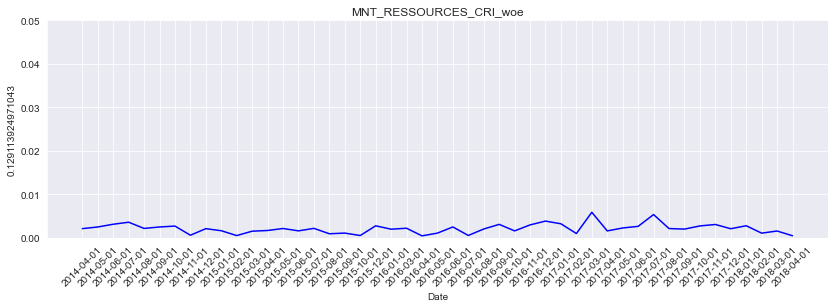

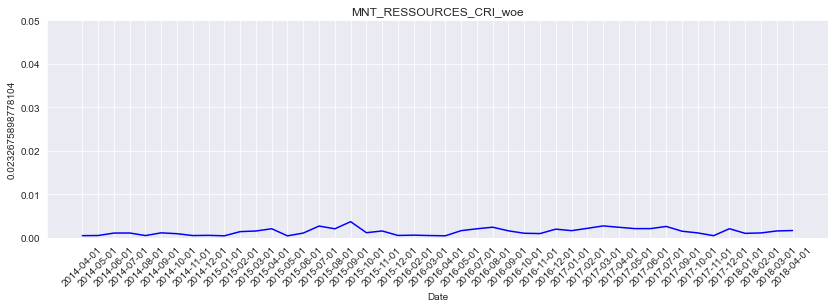

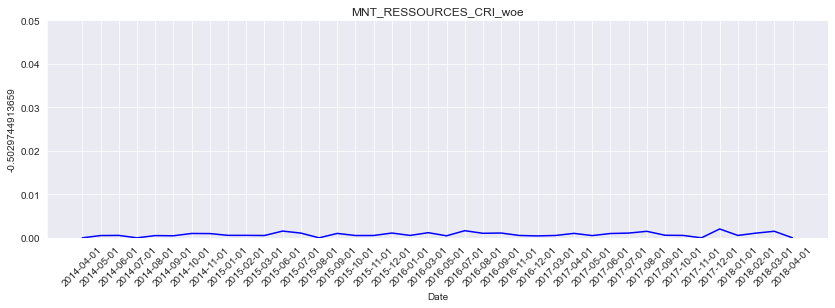

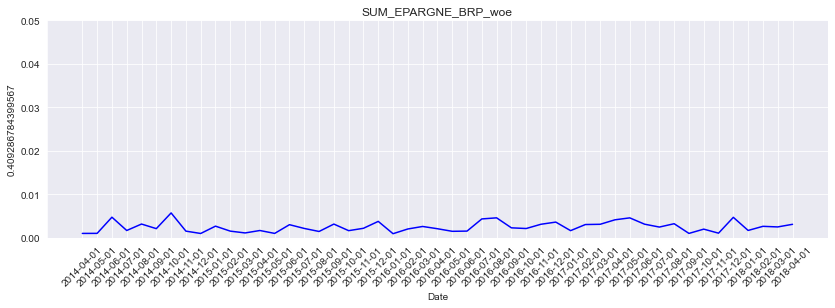

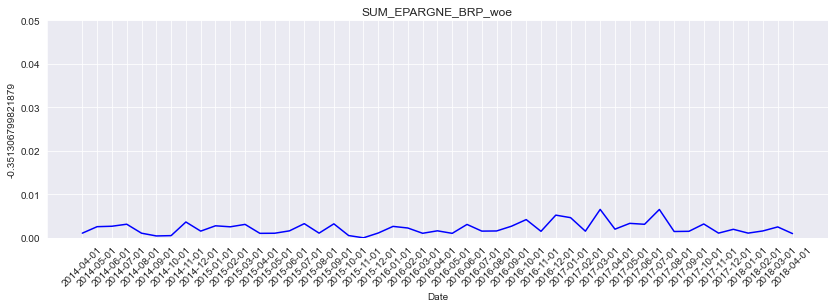

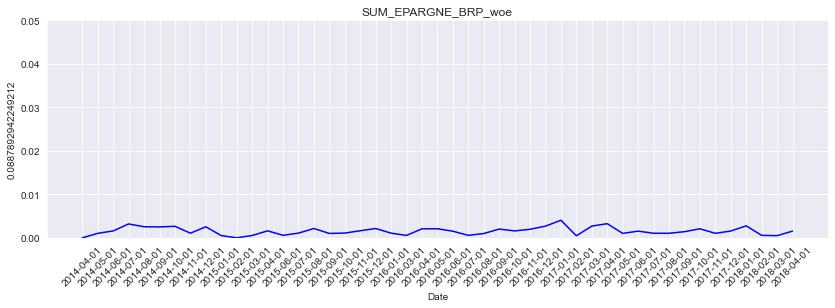

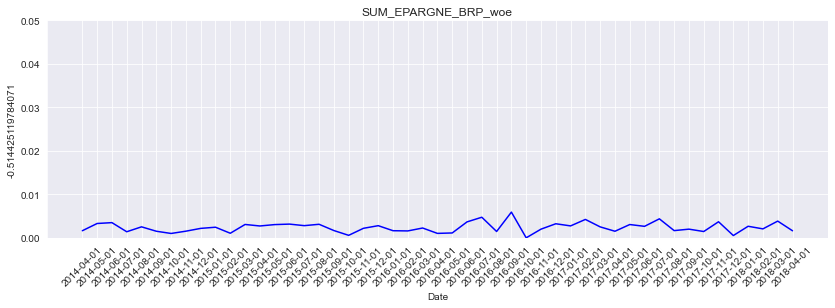

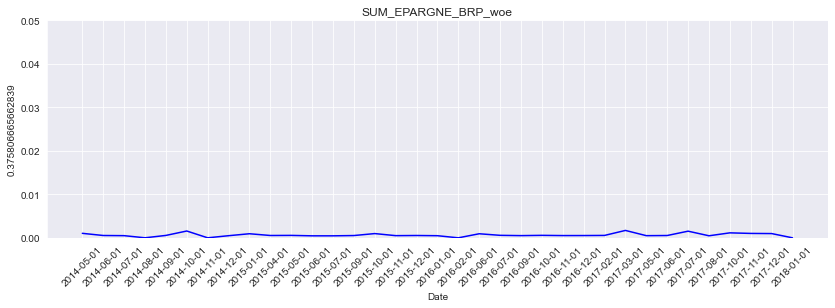

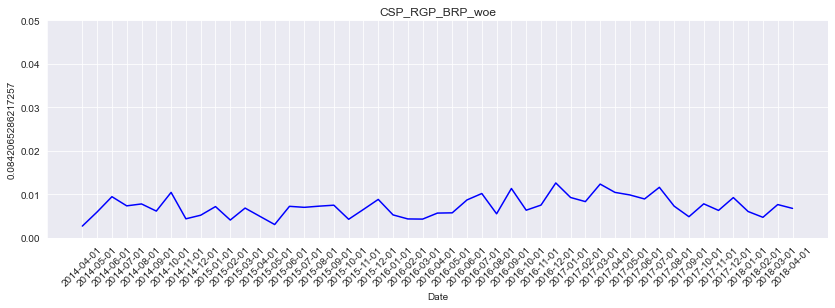

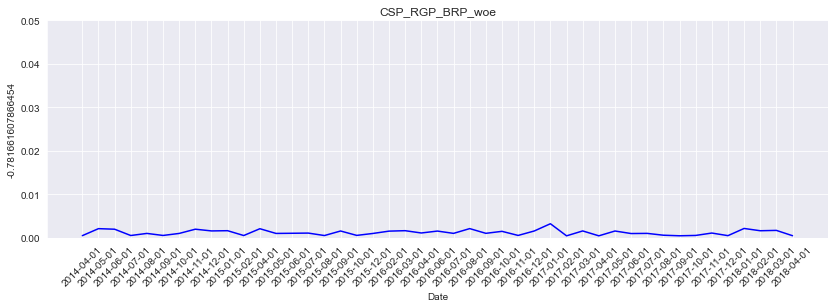

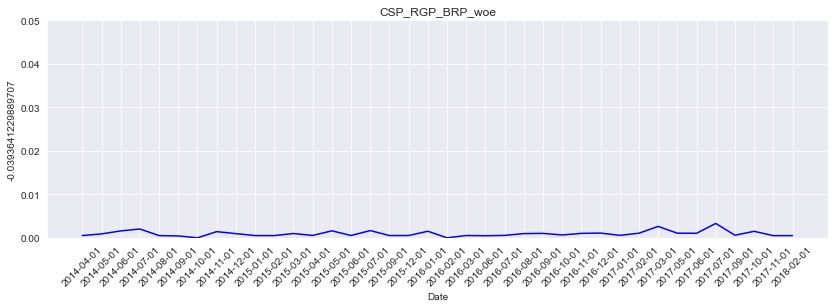

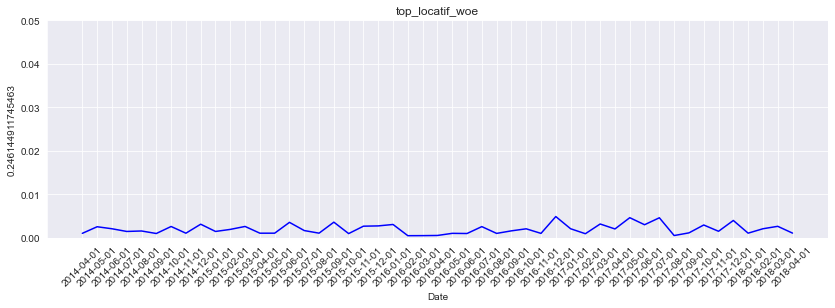

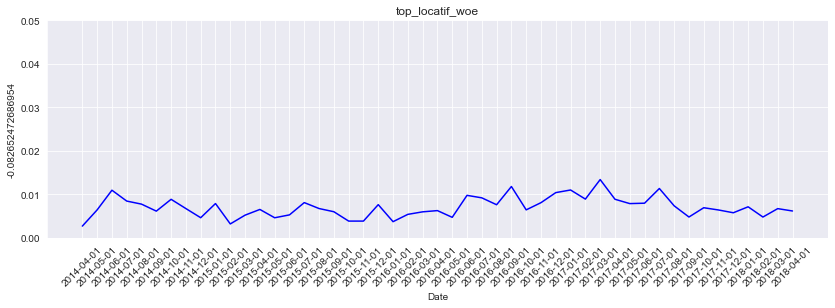

In [73]:
#Stabilité en risque des variables catégorielles
print ('\n' + 10*'-' + 'Stabilité mensuelle en risque des classes' + 10*'-' + '\n')
for col in base_up_woe.columns:
    if col not in ['defaut_36mois', 'date_debloc_avec_crd']:
        for group in base_up_woe[col].unique():
            table = base_up_woe[(base_up_woe[col]==group) & (base_up_woe['defaut_36mois']==1)].groupby(['date_debloc_avec_crd']).count()/base_up_woe.shape[0]
            plt.figure(figsize = (14, 4))
            plt.plot(table[col], color='b')
            plt.title(col)
            plt.xlabel("Date")
            plt.xticks(rotation = 45)
            plt.ylim(0.000, 0.05)
            plt.ylabel(group)
            plt.show()

# Modélisation

## Définition des bases

In [74]:
del_var_simple = ['defaut_36mois', 'date_debloc_avec_crd', 'COD_ETA_BIEN_CRI_woe', 'TOP_PRET_RELAIS_BRP_woe',
                  'NBR_INT_BRP_woe', 'TOP_NAT_FR_CRI_woe', 'NBR_ENF_CHAR_BRP_woe', 'STA_CLP_BRP_woe',
                  'QUA_INT_MAX_BRP_woe', 'IND_PRIMO_ACCEDT_CRI_woe']

X_train_up     =  train_up_woe.drop(del_var_simple, axis=1)
y_train_up     =  train_up_woe['defaut_36mois']

X_test_up      =  test_up_woe.drop(del_var_simple, axis=1)
y_test_up      =  test_up_woe['defaut_36mois'] 

## Régression logistique

In [75]:
X_train = X_train_up
y_train = y_train_up

X_test  = X_test_up
y_test  = y_test_up

### Sélection de variables

La sélection des variables s'est opérée ar diffétentes méthodes :
- RFE
- ExtraTreeClassifier
- Corrélations

[0.03115262 0.03634241 0.06897484 0.07165286 0.03484766 0.07438973
 0.06685038 0.03010473 0.16675482 0.08588483 0.04811516 0.06216868
 0.02211377 0.07268076 0.08136764 0.02638289 0.02021622]


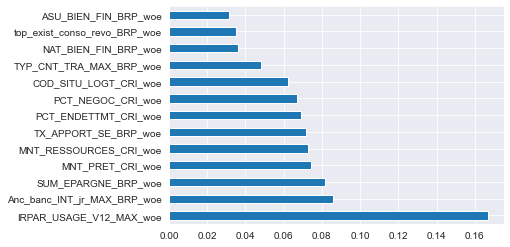

In [76]:
# selection des variables par la méthode de l'arbre
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
print(model.feature_importances_) 
 
# Afficher le graphique avec l'importance des variables 
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(13).plot(kind='barh')
plt.show()

In [77]:
feat_importances.nlargest(13)

IRPAR_USAGE_V12_MAX_woe         0.166755
Anc_banc_INT_jr_MAX_BRP_woe     0.085885
SUM_EPARGNE_BRP_woe             0.081368
MNT_PRET_CRI_woe                0.074390
MNT_RESSOURCES_CRI_woe          0.072681
TX_APPORT_SE_BRP_woe            0.071653
PCT_ENDETTMT_CRI_woe            0.068975
PCT_NEGOC_CRI_woe               0.066850
COD_SITU_LOGT_CRI_woe           0.062169
TYP_CNT_TRA_MAX_BRP_woe         0.048115
NAT_BIEN_FIN_BRP_woe            0.036342
top_exist_conso_revo_BRP_woe    0.034848
ASU_BIEN_FIN_BRP_woe            0.031153
dtype: float64

In [78]:
# selection des variables par RFE
rfe_model=RFE(estimator=model, verbose=1)
rfe_model.fit(X_train, y_train)

# l'affichage des variables selectionnées par RFE 
mask= rfe_model.support_

reduced_X_train=X_train.loc[:, mask]
reduced_X_test=X_test.loc[:, mask]
reduced_X_train.columns

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.


Index(['PCT_ENDETTMT_CRI_woe', 'TX_APPORT_SE_BRP_woe', 'MNT_PRET_CRI_woe',
       'PCT_NEGOC_CRI_woe', 'IRPAR_USAGE_V12_MAX_woe',
       'Anc_banc_INT_jr_MAX_BRP_woe', 'MNT_RESSOURCES_CRI_woe',
       'SUM_EPARGNE_BRP_woe'],
      dtype='object')

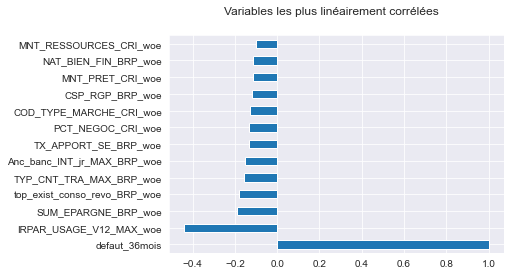

In [79]:
corr_matrix = train_up_woe.corr()
var_corr = corr_matrix['defaut_36mois'].reindex(corr_matrix['defaut_36mois'].abs().sort_values(ascending = False).index)[0:13]
var_corr.plot(kind = 'barh')
plt.suptitle('Variables les plus linéairement corrélées')
plt.show()

**Variables sélectionnées**

In [80]:
var_extra = ['IRPAR_USAGE_V12_MAX_woe', 'Anc_banc_INT_jr_MAX_BRP_woe', 'SUM_EPARGNE_BRP_woe', 'MNT_PRET_CRI_woe','MNT_RESSOURCES_CRI_woe',
            'TX_APPORT_SE_BRP_woe', 'PCT_ENDETTMT_CRI_woe', 'PCT_NEGOC_CRI_woe', 'COD_SITU_LOGT_CRI_woe',
             'TYP_CNT_TRA_MAX_BRP_woe', 'NAT_BIEN_FIN_BRP_woe', 'top_exist_conso_revo_BRP_woe']

In [81]:
var_RFE = ['PCT_ENDETTMT_CRI_woe', 'TX_APPORT_SE_BRP_woe', 'MNT_PRET_CRI_woe',
       'PCT_NEGOC_CRI_woe', 'IRPAR_USAGE_V12_MAX_woe',
       'Anc_banc_INT_jr_MAX_BRP_woe', 'MNT_RESSOURCES_CRI_woe',
       'SUM_EPARGNE_BRP_woe']

In [82]:
var_corr = ['MNT_RESSOURCES_CRI_woe', 'NAT_BIEN_FIN_BRP_woe', 'MNT_PRET_CRI_woe', 'CSP_RGP_BRP_woe', 'COD_TYPE_MARCHE_CRI_woe',
            'PCT_NEGOC_CRI_woe', 'TX_APPORT_SE_BRP_woe', 'Anc_banc_INT_jr_MAX_BRP_woe', 'TYP_CNT_TRA_MAX_BRP_woe',
            'top_exist_conso_revo_BRP_woe', 'SUM_EPARGNE_BRP_woe', 'IRPAR_USAGE_V12_MAX_woe']

In [83]:
# les variables sélectionnées 
# Choix possibles 
# var_extra --> 
# var_RFE   -->
# var_corr  --> 

X_train  = X_train_up[var_corr]
X_test   = X_test_up [var_corr]

### Obtention des meilleurs paramètres

In [84]:
from sklearn.metrics import make_scorer, recall_score, f1_score, precision_score
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 
           'Recall': make_scorer(recall_score), 'f1_score': make_scorer(f1_score),
          'Precision': make_scorer(precision_score)}

param={"penalty":["l2", "l1", "elasticnet"], 
       'C':[5,10,15,20], 
       "max_iter":[100,150,200]}

gs = GridSearchCV(LogisticRegression(random_state=42),
                  param_grid=param,
                  scoring=scoring, refit='AUC', return_train_score=True, cv = 3)

gs.fit(X_train, y_train)
results = gs.cv_results_

print("Les meilleurs paramètres sont:", gs.best_params_)
print("Le meilleur score est: %.2f" %gs.best_score_)

Les meilleurs paramètres sont: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Le meilleur score est: 0.78


### Entrainement du modèle

In [85]:
def model_perf(X_train, y_train, X_test, y_test, 
          smote = False, show_roc = False, show_conf_matrix = False, cut_off = 0.4, show_prc = True) : 

    if smote == True:
        
        print("SMOTE")
        print("--------")

        smote = SMOTE(random_state=42 , k_neighbors=15)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
    lr = LogisticRegression(C= 10, max_iter= 100, penalty= 'l2', random_state=42).fit(X_train, y_train)
    print("train score %.2f" %lr.score(X_train, y_train))
    print("--------")
    
        #PREDICTION DES Y_PRED
    train_pred = lr.predict_proba(X_train)[:,1]
    test_pred = lr.predict_proba(X_test)[:,1]
    print("test score %.2f" %lr.score(X_test, y_test))
    
    print("--------")
    print("Cut-off : ", cut_off)
    
        #ACCURACY, PRECISION ET TOUTE LA CLIQUE AU SEUIL DE 50% DE CONFIANCE (STANDARD)
    print("--------")
    print("classification_report\n")
    test_pred_b = (test_pred > cut_off).astype(bool)
    train_pred_b = (train_pred > cut_off).astype(bool)
    print("Train -------")
    print(classification_report(y_train, train_pred_b))
    print("\n")
    print("Test -------")
    print(classification_report(y_test, test_pred_b))
    print("\n")

    train_pred_b = (train_pred > cut_off).astype(bool)
    
        #MATRICE DE CONFUSION
    if show_conf_matrix == True : 
        print("Matrice de confusion\n")
        print(pd.crosstab(y_test, test_pred_b))
        print("--------")
        #AUC
    fpr, tpr, _= roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    fpr_, tpr_, _train= roc_curve(y_train, train_pred)
    roc_auc_ = auc(fpr_, tpr_)
    print("L'AUC est de %.2f" %roc_auc)
    print("--------")
    Gini = roc_auc * 2 - 1
    print('Gini test: %.2f' % (Gini))
    print("--------")
    Gini_ = roc_auc_ * 2 - 1
    print('Gini train: %.2f' % (Gini_))
    print("--------")
    if show_roc == True:
        print('roc curve')
        
        plt.figure(figsize=(6,6))
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr, tpr, lw=3, label='roc curve - Test (auc = {:0.2f})'.format(roc_auc))
        plt.plot(fpr_, tpr_, lw=3, label='roc curve - Train (auc = {:0.2f})'.format(roc_auc_))
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        #plt.title('roc curve ', fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.axes().set_aspect('equal')
        plt.show()
        print("\n")
 
    precision, recall, thresholds = precision_recall_curve(y_test, test_pred)
    precision_, recall_, thresholds_ = precision_recall_curve(y_train, train_pred)
    
    closest_zero = np.argmin(np.abs(thresholds))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]
    
    closest_zero_ = np.argmin(np.abs(thresholds_))
    closest_zero_p_ = precision_[closest_zero_]
    closest_zero_r_ = recall_[closest_zero_]
    
    if show_prc == True : 
        
        print("precision_recall_curve")
        plt.figure(figsize = (6,6))
        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.plot(precision, recall, label='prc - Test')
        plt.plot(precision_, recall_, label='prc - Train')
        plt.xlabel('Precision', fontsize=16)
        plt.ylabel('Recall', fontsize=16)
        plt.axes().set_aspect('equal')
        plt.legend(loc='lower left', fontsize=13)
        plt.show()

    J = tpr - fpr
    ix = np.argmax(J)
    seuil_opt = thresholds[ix]
    
    J_ = tpr_ - fpr_
    ix_ = np.argmax(J_)
    seuil_opt_ = thresholds_[ix_]
    print('Meilleur cut-off test : %.2f' % (seuil_opt))
    print('Meilleur cut-off train : %.2f' % (seuil_opt_))
    
    return train_pred, y_test, test_pred, fpr, tpr, roc_auc

train score 0.71
--------
test score 0.70
--------
Cut-off :  0.4
--------
classification_report

Train -------
              precision    recall  f1-score   support

           0       0.77      0.56      0.65    130044
           1       0.65      0.83      0.73    130044

    accuracy                           0.70    260088
   macro avg       0.71      0.70      0.69    260088
weighted avg       0.71      0.70      0.69    260088



Test -------
              precision    recall  f1-score   support

           0       1.00      0.56      0.72     32511
           1       0.01      0.81      0.02       212

    accuracy                           0.57     32723
   macro avg       0.50      0.69      0.37     32723
weighted avg       0.99      0.57      0.72     32723



Matrice de confusion

col_0          False   True
defaut_36mois              
0              18319  14192
1                 40    172
--------
L'AUC est de 0.78
--------
Gini test: 0.56
--------
Gini train: 0.57
-----

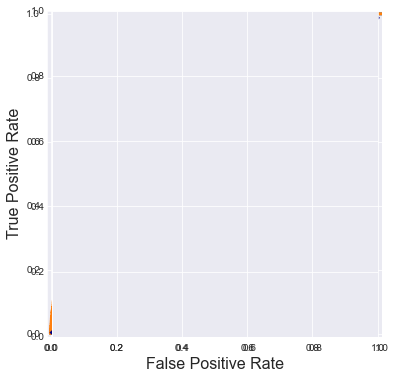

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




precision_recall_curve


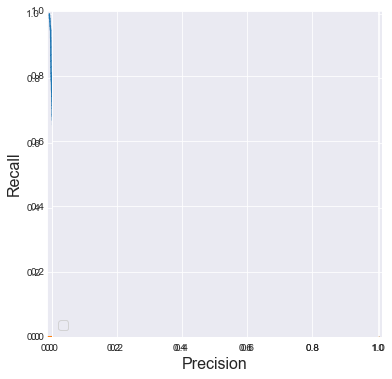

Meilleur cut-off test : 0.11
Meilleur cut-off train : 0.15


In [86]:
# Estimation
train_pred, y_test, test_pred, fpr, tpr, roc_auc = model_perf(X_train, y_train, X_test, y_test,
                                                              smote = False, show_roc= True,
                                                              show_prc=True, cut_off=0.4, show_conf_matrix=True)

## Grille de score

### Définition de la grille de score 

La fonction que nous avons construite nous permet :
    - de définir la grille de score
    - de l'appliquer à notre train et test
    - d'afficher les distributions conditionnelles

In [87]:
vars_to_keep = ['MNT_RESSOURCES_CRI',
                 'NAT_BIEN_FIN_BRP',
                 'MNT_PRET_CRI',
                 'CSP_RGP_BRP',
                 'COD_TYPE_MARCHE_CRI',
                 'PCT_NEGOC_CRI',
                 'TX_APPORT_SE_BRP',
                 'Anc_banc_INT_jr_MAX_BRP',
                 'TYP_CNT_TRA_MAX_BRP',
                 'top_exist_conso_revo_BRP',
                 'SUM_EPARGNE_BRP',
                 'IRPAR_USAGE_V12_MAX', 
                 'defaut_36mois']

train_ = train[vars_to_keep]
test_ = test[vars_to_keep]

In [88]:
def score(X, base = 1000, pdo = 30):
    
    # Entrainement du modèle et prediction
    lr = LogisticRegression(penalty='l2', C=10, max_iter= 100, random_state=42)
    lr.fit(X_train, y_train)
    test_pred = lr.predict_proba(X_test)[:,1]
    
    # Calcul des scores
    card = sc.scorecard(discret_up, lr, xcolumns=X_test.columns, odds0=1/500,  points0=base, pdo=pdo, basepoints_eq0 = True)
    
    
    # Application aux échantillons
    train_score = sc.scorecard_ply(train_up, card, print_step=0, only_total_score=False)
    
    test_score = sc.scorecard_ply(test, card, print_step=0, only_total_score=False)

    if X == "Test":
        a = test_score
        b = test
    else:
        X == "Train"
        a = train_score
        b = train
        
    score_avec_target = pd.concat([a, b['defaut_36mois']],axis=1)
    bon_score         = score_avec_target[score_avec_target["defaut_36mois"]== 0]['score']
    mauvais_score     = score_avec_target[score_avec_target["defaut_36mois"]== 1]['score']


    plt.figure()
    sns.distplot(mauvais_score, color='red', label = "defaut_36mois = 1")
    sns.distplot(bon_score, color = "green", label ="defaut_36mois = 0" )
    plt.legend(loc='upper left')
    plt.title("score distribution - " + str(X))

        
    plt.figure()
    sns.distplot(train_score["score"], color='blue', label = "train score")
    sns.distplot(test_score["score"], color = "orange", label ="test score" )
    plt.legend(loc='upper left')
    plt.title("Test & Train Comparaison")
    
    return card, train_score, test_score

### Application et densités conditionnelles 

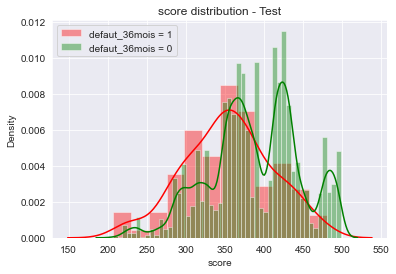

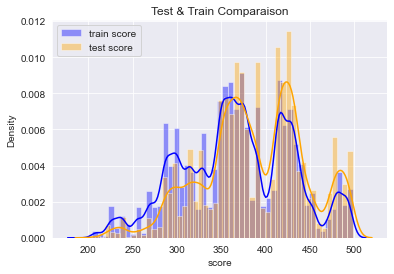

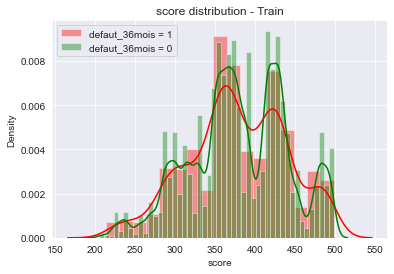

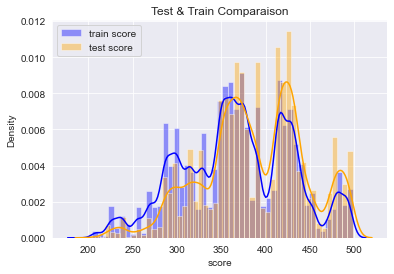

In [89]:
card, train_score, test_score = score("Test")
card, train_score, test_score = score("Train")

### Obtention de la grille de score 

In [90]:
GDS = pd.DataFrame(columns=['variable','bin','points'])
for var in card.keys():
    if var != 'basepoints':
        GDS = GDS.append(card[var], ignore_index=True)

In [91]:
GDS

variable  \
0         MNT_RESSOURCES_CRI   
1         MNT_RESSOURCES_CRI   
2         MNT_RESSOURCES_CRI   
3         MNT_RESSOURCES_CRI   
4         MNT_RESSOURCES_CRI   
5         MNT_RESSOURCES_CRI   
6           NAT_BIEN_FIN_BRP   
7           NAT_BIEN_FIN_BRP   
8               MNT_PRET_CRI   
9               MNT_PRET_CRI   
10              MNT_PRET_CRI   
11              MNT_PRET_CRI   
12              MNT_PRET_CRI   
13              MNT_PRET_CRI   
14               CSP_RGP_BRP   
15               CSP_RGP_BRP   
16               CSP_RGP_BRP   
17       COD_TYPE_MARCHE_CRI   
18       COD_TYPE_MARCHE_CRI   
19             PCT_NEGOC_CRI   
20             PCT_NEGOC_CRI   
21             PCT_NEGOC_CRI   
22             PCT_NEGOC_CRI   
23             PCT_NEGOC_CRI   
24          TX_APPORT_SE_BRP   
25          TX_APPORT_SE_BRP   
26          TX_APPORT_SE_BRP   
27          TX_APPORT_SE_BRP   
28          TX_APPORT_SE_BRP   
29   Anc_banc_INT_jr_MAX_BRP   
30   Anc_banc_INT_jr_MAX_BRP   
31   Anc_banc_INT_jr_MAX_BRP   
32   Anc_banc_INT_jr_MAX_BRP   
33   Anc_banc_INT_jr_MAX_BRP   
34       TYP_CNT_TRA_MAX_BRP   
35       TYP_CNT_TRA_MAX_BRP   
36       TYP_CNT_TRA_MAX_BRP   
37  top_exist_conso_revo_BRP   
38  top_exist_conso_revo_BRP   
39           SUM_EPARGNE_BRP   
40           SUM_EPARGNE_BRP   
41           SUM_EPARGNE_BRP   
42           SUM_EPARGNE_BRP   
43           SUM_EPARGNE_BRP   
44       IRPAR_USAGE_V12_MAX   
45       IRPAR_USAGE_V12_MAX   
46       IRPAR_USAGE_V12_MAX   
47       IRPAR_USAGE_V12_MAX   
48       IRPAR_USAGE_V12_MAX   

                                                  bin points  
0                                        [-Inf,40000)   67.0  
1                                       [40000,70000)   59.0  
2                                       [70000,85000)   82.0  
3                                      [85000,125000)   62.0  
4                                     [125000,220000)   48.0  
5                                       [220000, Inf)   36.0  
6                              80%,%30%,%50%,%60%,%20   55.0  
7   10%,%70%,%90%,%40%,%100%,%140%,%120%,%110%,%13...   68.0  
8                                        [-Inf,30000)   76.0  
9                                       [30000,50000)   57.0  
10                                      [50000,70000)   80.0  
11                                      [70000,90000)   71.0  
12                                     [90000,190000)   63.0  
13                                      [190000, Inf)   53.0  
14                                              2%,%1   60.0  
15                                           <NA>%,%6   61.0  
16                              5%,%3%,%4%,%7%,%8%,%9   61.0  
17                                                M21   57.0  
18                                            M2%,%M1   62.0  
19                                           [-Inf,1)   89.0  
20                                            [1,1.5)   67.0  
21                                          [1.5,2.5)   61.0  
22                                          [2.5,3.1)   52.0  
23                                         [3.1, Inf)   37.0  
24                                        [-Inf,0.06)   58.0  
25                                        [0.06,0.14)   63.0  
26                                         [0.14,0.2)   59.0  
27                                         [0.2,0.56)   65.0  
28                                        [0.56, Inf)   71.0  
29                                        [-Inf,2000)   53.0  
30                                        [2000,3000)   60.0  
31                                        [3000,4500)   66.0  
32                                        [4500,7000)   56.0  
33                                        [7000, Inf)   69.0  
34                                            13%,%11   48.0  
35                               3%,%NaN%,%1%,%12%,%8   63.0  
36                         2%,%4%,%6%,%7%,%9%,%5%,%10   68.0  
37                       

# Obtention des classes de risques

## Etude de la stabilité des classes de risques

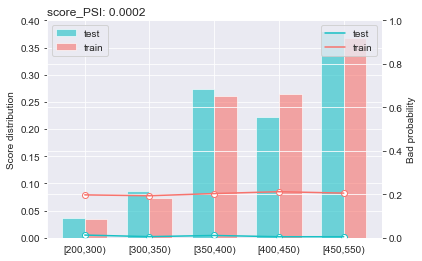

In [94]:
lr = LogisticRegression(penalty='l2', C=10, max_iter= 100, random_state=42)
lr.fit(X_train, y_train)

card = sc.scorecard(discret_up, lr, X_train.columns)
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0, only_total_score=True)
test_score = sc.scorecard_ply(test, card, print_step=0, only_total_score=True)

# psi
CR = sc.perf_psi(
      score = {'train':train_score, 'test':test_score},
      label = {'train':y_train, 'test':y_test},
      return_distr_dat=True
    )

In [95]:
CR.keys()

dict_keys(['psi', 'pic', 'dat'])

In [96]:
CR['psi']

variable      PSI
0    score  0.00016

In [97]:
CR['pic']

{'score': <Figure size 432x288 with 2 Axes>}

## Classes des risques

In [98]:
CR['dat']

{'score':           bin     N          badprob          
 ae             test  train      test     train
 0   [200,300)   239   4514  0.012552  0.197386
 1   [300,350)   558   9488  0.005376  0.193402
 2   [350,400)  1767  34125  0.010753  0.203487
 3   [400,450)  1430  34662  0.004895  0.212077
 4   [450,550)  2454  48102  0.004890  0.205480}

# Machine learning

## Random Forest Classifier

In [99]:
# Instancier le classifieur
random_forest = RandomForestClassifier()

# Entrainer le modèle
random_forest.fit(X_train, y_train)

# Prédiction du modèle
y_pred = random_forest.predict(X_test)

# Affichage du score
print('\n Le score du modèle est :', round(random_forest.score(X_test, y_test), 2))

# Affichage de la matrice de confusion
print('\n' + 10*'-' + '  La matrice de confusion  ' + 10*'-' + '\n')
print(confusion_matrix(y_test, y_pred))

print('\n' + 15*'-' + '  L\'AUC  ' + 15*'-' + '\n')
print(roc_auc_score(y_test, y_pred))

print('\n' + 10*'-' + '  Les métriques du modèle  ' + 10*'-' + '\n')
print(classification_report(y_test, y_pred))


 Le score du modèle est : 0.98

----------  La matrice de confusion  ----------

[[31943   568]
 [  207     5]]

---------------  L'AUC  ---------------

0.5030569479241569

----------  Les métriques du modèle  ----------

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     32511
           1       0.01      0.02      0.01       212

    accuracy                           0.98     32723
   macro avg       0.50      0.50      0.50     32723
weighted avg       0.99      0.98      0.98     32723




----------  Avec un seuil 0.4  ----------

col_0              0    1
defaut_36mois            
0              31895  616
1                207    5


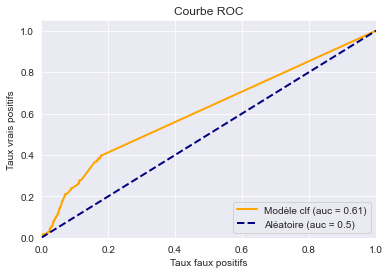

In [100]:
# Calcul des probas avec définition d'un seuil à 0.4
print('\n' + 10*'-' + '  Avec un seuil 0.4  ' + 10*'-' + '\n')
probs=random_forest.predict_proba(X_test)
y_preds=np.where(probs[:,1]>0.4,1,0)
print(pd.crosstab(y_test, y_preds))
# Affichage de la courbe roc
fpr, tpr, seuils=roc_curve(y_test, probs[:, 1], pos_label=1)
roc_auc=auc(fpr, tpr)
roc_auc

plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show();